#### RUNPOD ENVIRONMENT SETUP (Run once per pod)

In [32]:
# =============================================================================
# RUNPOD ENVIRONMENT SETUP (Run once per pod)
# =============================================================================

# Clear root filesystem to free space
!rm -rf /root/.cache/huggingface /root/.cache/pip /root/.cache/torch
!pip cache purge
!df -h /

# Remove unused packages to save space
!pip uninstall torchaudio torchvision -y

# Fix typing_extensions compatibility
!pip install --upgrade "typing_extensions>=4.10" --force-reinstall

# Install protobuf and sentencepiece for tokenizers
!pip install protobuf sentencepiece --break-system-packages

# Notebook merging tool
!pip install nbmerge

# PyTorch/CUDA Upgrade (H200 SXM compatibility)
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu124 -q

# Core data science libraries (no dependencies to avoid conflicts)
!pip install -q --no-deps \
    pandas \
    numpy \
    matplotlib \
    seaborn

# ML/NLP libraries
!pip install -q \
    transformers \
    datasets \
    accelerate \
    peft \
    bitsandbytes \
    tqdm

# Evaluation metrics
!pip install -q \
    evaluate \
    rouge-score \
    bert-score \
    textstat \
    sacrebleu \
    git+https://github.com/feralvam/easse.git  # SARI metric (install from GitHub)

# Fix scipy/numpy compatibility
!pip install --upgrade scipy numpy --break-system-packages

# ⚠️ RESTART KERNEL AFTER THIS CELL

Files removed: 0
Filesystem      Size  Used Avail Use% Mounted on
overlay          20G  5.0G   16G  25% /
  Attempting uninstall: typing_extensions
    Found existing installation: typing_extensions 4.15.0
    Uninstalling typing_extensions-4.15.0:
      Successfully uninstalled typing_extensions-4.15.0

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip ins

# Chapter 7: Evaluation
---
## Objective
Evaluate fine-tuned LoRA models on full test set (1,001 samples) and compare to zero-shot baselines from Chapter 5.
---
## Sections
| Section | Task | GPU |
|---------|------|-----|
| 7.1 | Setup & Load Test Dataset | All |
| 7.2.1 | Generate Test Predictions (OpenBioLLM-8B) | 0 |
| 7.2.2 | Generate Test Predictions (Mistral-7B) | 1 |
| 7.2.3 | Generate Test Predictions (BioMistral-7B-DARE) | 2 |
| 7.3 | Compute Full Metrics | Any |
| 7.4 | Compare to Baselines | Any |
---
## Execution Plan (Parallel)
| Time | GPU 0 | GPU 1 | GPU 2 |
|------|-------|-------|-------|
| T+0 | 7.2.1 Predictions | 7.2.2 Predictions | 7.2.3 Predictions |
| T+45m | Done | Done | Done |
| T+45m | 7.3-7.4 Analysis | - | - |
| T+1h | Complete | - | - |
---
## GPU Assignment
| GPU | Model | Architecture |
|-----|-------|--------------|
| 0 | OpenBioLLM-8B | Llama3 |
| 1 | Mistral-7B | Mistral |
| 2 | BioMistral-7B-DARE | Mistral |
---
## Input Files
**From Chapter 5 (Baseline):**
- `results/baseline/baseline_results.json`
- `data/instruction_dataset/chatml/`
- `data/instruction_dataset/mistral/`
**From Chapter 6 (LoRA Adapters):**
- `models/openbiollm_8b_lora/`
- `models/mistral_7b_lora/`
- `models/biomistral_7b_dare_lora/`
---
## Output Files
**Predictions:**
- `results/evaluation/predictions_openbiollm_8b.json`
- `results/evaluation/predictions_mistral_7b.json`
- `results/evaluation/predictions_biomistral_7b_dare.json`
**Metrics:**
- `results/evaluation/evaluation_metrics.csv`
- `results/evaluation/evaluation_summary.json`
- `results/evaluation/model_comparison.json`
**Figures:**
- `results/figures/baseline_vs_finetuned.png`
---
## Estimated Time
~1 hour (parallel inference + metrics)

In [9]:
# =============================================================================
# SECTION 7.1: SETUP & LOAD TEST DATASET
# =============================================================================
# This is Part 4 of the MediSimplifier notebook series
# New notebook for Chapter 7: Evaluation
# =============================================================================

print("=" * 70)
print("SECTION 7.1: SETUP & LOAD TEST DATASET")
print("=" * 70)

# -----------------------------------------------------------------------------
# 7.1.1 GPU & Model Configuration (CHANGE PER NOTEBOOK)
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.1 GPU & Model Configuration:")

# Import os first for environment variables
import os

# Set GPU device BEFORE importing torch/transformers
# GPU 0 = OpenBioLLM-8B, GPU 1 = Mistral-7B, GPU 2 = BioMistral-7B-DARE
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Change: "0", "1", or "2"

# Select model for this notebook (must match GPU assignment)
# Options: "OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"
CURRENT_MODEL = "OpenBioLLM-8B"  # Change per notebook

# Print configuration
print(f"   ✓ GPU: {os.environ['CUDA_VISIBLE_DEVICES']}")
print(f"   ✓ Model: {CURRENT_MODEL}")

# -----------------------------------------------------------------------------
# 7.1.2 Imports
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.2 Imports:")

# Standard library imports
import json                    # JSON file handling
import time                    # Timing operations
import warnings                # Warning suppression
from datetime import datetime  # Timestamps
from pathlib import Path       # Path handling
from tqdm import tqdm          # Progress bars

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Data science imports
import numpy as np             # Numerical operations
import pandas as pd            # DataFrames
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns          # Statistical visualization

# PyTorch imports
import torch                   # Deep learning framework
import torch.nn as nn          # Neural network modules

# Transformers imports
from transformers import (
    AutoModelForCausalLM,      # Load causal language models
    AutoTokenizer,             # Load tokenizers
)

# PEFT imports for LoRA
from peft import (
    PeftModel,                 # Load PEFT models
    PeftConfig,                # PEFT configuration
)

# Dataset imports
from datasets import (
    load_dataset,              # Load from HuggingFace
    load_from_disk,            # Load local datasets
    Dataset,                   # Dataset class
)

# Evaluation metric imports
from rouge_score import rouge_scorer  # ROUGE metrics
import textstat                       # Readability metrics (FK-Grade)

# Print success
print("   ✓ All imports successful")

# -----------------------------------------------------------------------------
# 7.1.3 HuggingFace API Fix
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.3 HuggingFace API Fix:")

# Fix: Patch safetensors conversion functions directly
try:
    import transformers.safetensors_conversion as sc
    sc.previous_pr = lambda *args, **kwargs: None
    sc.get_conversion_pr_reference = lambda *args, **kwargs: None
    print("   ✓ Fix 1 applied (safetensors_conversion.previous_pr patched)")
except Exception as e:
    print(f"   ⚠️ Fix 1 failed: {e}")

# Fix 2: Patch get_repo_discussions
try:
    import huggingface_hub.hf_api as hf_api
    original_get_repo_discussions = hf_api.get_repo_discussions
    def patched_get_repo_discussions(*args, **kwargs):
        return iter([])
    hf_api.get_repo_discussions = patched_get_repo_discussions
    print("   ✓ Fix 2 applied (get_repo_discussions patched)")
except Exception as e:
    print(f"   ⚠️ Fix 2 failed: {e}")

# Fix 3: Patch hf_raise_for_status to ignore 403 on discussions
try:
    import huggingface_hub.utils._http as hf_http
    original_raise = hf_http.hf_raise_for_status
    def patched_raise(response, *args, **kwargs):
        if "discussions" in str(response.url) and response.status_code == 403:
            return  # Silently ignore 403 on discussions endpoint
        return original_raise(response, *args, **kwargs)
    hf_http.hf_raise_for_status = patched_raise
    print("   ✓ Fix 3 applied (hf_raise_for_status patched)")
except Exception as e:
    print(f"   ⚠️ Fix 3 failed: {e}")

# Set environment variables
os.environ["SAFETENSORS_FAST_GPU"] = "0"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

print("   ✓ Environment variables set")

# -----------------------------------------------------------------------------
# 7.1.4 Verify GPU & CUDA
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.4 Verify GPU & CUDA:")

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print(f"   CUDA available: {cuda_available}")

# If CUDA available, print device info
if cuda_available:
    # Get current device index
    device_idx = torch.cuda.current_device()
    # Get device name
    device_name = torch.cuda.get_device_name(device_idx)
    # Get total memory in GB
    total_memory = torch.cuda.get_device_properties(device_idx).total_memory / 1e9
    # Print device info
    print(f"   ✓ Device {device_idx}: {device_name}")
    print(f"   ✓ Total memory: {total_memory:.1f} GB")
else:
    # Print error if no CUDA
    print("   ❌ No CUDA device found!")

# Set default device
DEVICE = torch.device("cuda" if cuda_available else "cpu")
print(f"   ✓ Using device: {DEVICE}")

# -----------------------------------------------------------------------------
# 7.1.5 Define Paths
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.5 Define Paths:")

# Base directory for the project
BASE_DIR = Path("/workspace/medisimplifier")

# Data directory (contains instruction datasets from Chapter 5)
DATA_DIR = BASE_DIR / "data"

# Results directory (contains all outputs)
RESULTS_DIR = BASE_DIR / "results"

# Baseline results from Chapter 5
BASELINE_DIR = RESULTS_DIR / "baseline"

# Ablation results from Chapter 6
ABLATION_DIR = RESULTS_DIR / "ablation"

# Training results from Chapter 6
TRAINING_DIR = ABLATION_DIR

# Evaluation results (Chapter 7 outputs)
EVALUATION_DIR = RESULTS_DIR / "evaluation"

# Figures directory
FIGURES_DIR = RESULTS_DIR / "figures"

# Models directory (LoRA adapters from Chapter 6)
MODELS_DIR = BASE_DIR / "models"

# Instruction dataset directory (in data/, NOT results/)
DATASET_DIR = DATA_DIR / "instruction_dataset"

# HuggingFace cache directory
HF_CACHE_DIR = Path("/workspace/HFModels")

# Set HuggingFace home environment variable
os.environ["HF_HOME"] = str(HF_CACHE_DIR)

# Create evaluation directory if it doesn't exist
EVALUATION_DIR.mkdir(parents=True, exist_ok=True)

# Print all paths
print(f"   ✓ BASE_DIR: {BASE_DIR}")
print(f"   ✓ DATA_DIR: {DATA_DIR}")
print(f"   ✓ RESULTS_DIR: {RESULTS_DIR}")
print(f"   ✓ DATASET_DIR: {DATASET_DIR}")
print(f"   ✓ EVALUATION_DIR: {EVALUATION_DIR}")
print(f"   ✓ MODELS_DIR: {MODELS_DIR}")
print(f"   ✓ HF_CACHE_DIR: {HF_CACHE_DIR}")

# -----------------------------------------------------------------------------
# 7.1.6 Model Configuration Dictionary
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.6 Model Configuration:")

# Define configuration for all three models
MODEL_CONFIGS = {
    "OpenBioLLM-8B": {
        "path": "aaditya/Llama3-OpenBioLLM-8B",           # HuggingFace model path
        "architecture": "llama3",                          # Architecture type
        "prompt_format": "chatml",                         # Prompt template format
        "adapter_path": MODELS_DIR / "openbiollm_8b_lora", # LoRA adapter path
        "dataset_path": DATASET_DIR / "chatml",            # Instruction dataset path
    },
    "Mistral-7B": {
        "path": "mistralai/Mistral-7B-Instruct-v0.2",     # HuggingFace model path
        "architecture": "mistral",                         # Architecture type
        "prompt_format": "mistral",                        # Prompt template format
        "adapter_path": MODELS_DIR / "mistral_7b_lora",    # LoRA adapter path
        "dataset_path": DATASET_DIR / "mistral",           # Instruction dataset path
    },
    "BioMistral-7B-DARE": {
        "path": "BioMistral/BioMistral-7B-DARE",          # HuggingFace model path
        "architecture": "mistral",                         # Architecture type
        "prompt_format": "mistral",                        # Prompt template format
        "adapter_path": MODELS_DIR / "biomistral_7b_dare_lora",  # LoRA adapter path
        "dataset_path": DATASET_DIR / "mistral",           # Instruction dataset path
    },
}

# Get current model configuration
MODEL_CONFIG = MODEL_CONFIGS[CURRENT_MODEL]

# Extract commonly used values
CURRENT_ARCHITECTURE = MODEL_CONFIG["architecture"]
CURRENT_ADAPTER_PATH = MODEL_CONFIG["adapter_path"]
CURRENT_DATASET_PATH = MODEL_CONFIG["dataset_path"]

# Print current configuration
print(f"   ✓ Model: {CURRENT_MODEL}")
print(f"   ✓ Architecture: {CURRENT_ARCHITECTURE}")
print(f"   ✓ Prompt format: {MODEL_CONFIG['prompt_format']}")
print(f"   ✓ Adapter path: {CURRENT_ADAPTER_PATH}")
print(f"   ✓ Dataset path: {CURRENT_DATASET_PATH}")

# -----------------------------------------------------------------------------
# 7.1.7 Prompt Templates
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.7 Prompt Templates:")

# Task instruction (same as training)
TASK_INSTRUCTION = """Simplify the following medical discharge summary in plain language for patients with no medical background.
Guidelines:
- Replace medical jargon with everyday words (e.g., "hypertension" → "high blood pressure")
- Keep all important information (diagnoses, medications, follow-up instructions)
- Use short, clear sentences (aim for 15-20 words per sentence)
- Aim for a 6th-grade reading level
- Maintain the same structure as the original
- Do not add or omit information
- Keep the same patient reference style (e.g., "The patient" stays "The patient", not "You")
- Output plain text only (no markdown, no bold, no headers, no bullet points)
- Do not include empty lines or separator characters like "---\""""

# System message for model guidance
SYSTEM_MESSAGE = "You are a helpful medical assistant that simplifies complex medical text for patients."

# ChatML inference template (OpenBioLLM-8B)
CHATML_INFERENCE_TEMPLATE = """<|im_start|>system
You are a helpful medical assistant that simplifies complex medical text for patients.<|im_end|>
<|im_start|>user
{instruction}

{input}<|im_end|>
<|im_start|>assistant
"""

# Mistral inference template (Mistral-7B, BioMistral)
MISTRAL_INFERENCE_TEMPLATE = """[INST] <<SYS>>
You are a helpful medical assistant that simplifies complex medical text for patients.
<</SYS>>

{instruction}

{input} [/INST]"""

# Print success
print("   ✓ TASK_INSTRUCTION defined")
print("   ✓ CHATML_INFERENCE_TEMPLATE defined")
print("   ✓ MISTRAL_INFERENCE_TEMPLATE defined")

# -----------------------------------------------------------------------------
# 7.1.8 Helper Functions
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.8 Helper Functions:")

def print_gpu_memory():
    """Print current GPU memory usage."""
    # Check if CUDA is available
    if torch.cuda.is_available():
        # Get allocated memory in GB
        allocated = torch.cuda.memory_allocated() / 1e9
        # Get reserved memory in GB
        reserved = torch.cuda.memory_reserved() / 1e9
        # Print memory usage
        print(f"   GPU Memory: {allocated:.1f}GB allocated, {reserved:.1f}GB reserved")
    else:
        # Print if no GPU
        print("   GPU Memory: N/A (no CUDA)")

def clear_memory():
    """Clear GPU memory and run garbage collection."""
    # Import garbage collector
    import gc
    # Run garbage collection
    gc.collect()
    # Clear CUDA cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def format_inference_prompt(instruction, input_text, prompt_format):
    """Format input for model inference based on prompt format."""
    # Select template based on format
    if prompt_format == "chatml":
        # Use ChatML template for OpenBioLLM
        return CHATML_INFERENCE_TEMPLATE.format(instruction=instruction, input=input_text)
    elif prompt_format == "mistral":
        # Use Mistral template for Mistral-7B and BioMistral
        return MISTRAL_INFERENCE_TEMPLATE.format(instruction=instruction, input=input_text)
    else:
        # Raise error for unknown format
        raise ValueError(f"Unknown prompt format: {prompt_format}")

def save_checkpoint(data, path):
    """Save checkpoint data to JSON file."""
    # Add timestamp to data
    data["timestamp"] = datetime.now().isoformat()
    # Write to file with indentation
    with open(path, "w") as f:
        json.dump(data, f, indent=2)
    # Print confirmation
    print(f"   ✓ Checkpoint saved: {path.name}")

def load_checkpoint(path):
    """Load checkpoint data from JSON file."""
    # Check if file exists
    if path.exists():
        # Read and parse JSON
        with open(path, "r") as f:
            return json.load(f)
    # Return None if file doesn't exist
    return None

# Print success
print("   ✓ print_gpu_memory()")
print("   ✓ clear_memory()")
print("   ✓ format_inference_prompt()")
print("   ✓ save_checkpoint()")
print("   ✓ load_checkpoint()")

# -----------------------------------------------------------------------------
# 7.1.9 Generation Configuration
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.9 Generation Configuration:")

# Generation parameters for inference
GENERATION_CONFIG = {
    "max_new_tokens": 512,     # Maximum tokens to generate
    "do_sample": False,        # Use greedy decoding (deterministic)
    "temperature": 1.0,        # Temperature (ignored when do_sample=False)
    "top_p": 1.0,              # Top-p sampling (ignored when do_sample=False)
    "repetition_penalty": 1.0, # Repetition penalty
}

# Print generation config
for key, value in GENERATION_CONFIG.items():
    print(f"   ✓ {key}: {value}")

# -----------------------------------------------------------------------------
# 7.1.10 Random Seed
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.10 Random Seed:")

# Set seed for reproducibility
SEED = 42

# Set Python random seed
import random
random.seed(SEED)

# Set NumPy random seed
np.random.seed(SEED)

# Set PyTorch random seed
torch.manual_seed(SEED)

# Set CUDA random seed if available
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Print seed
print(f"   ✓ Seed: {SEED}")

# -----------------------------------------------------------------------------
# 7.1.11 Load Test Dataset
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.11 Load Test Dataset:")

# Load instruction dataset from disk
dataset = load_from_disk(str(CURRENT_DATASET_PATH))

# Print dataset info
print(f"   ✓ Dataset loaded from: {CURRENT_DATASET_PATH}")
print(f"   ✓ Train samples: {len(dataset['train'])}")
print(f"   ✓ Validation samples: {len(dataset['validation'])}")
print(f"   ✓ Test samples: {len(dataset['test'])}")

# Extract test set
test_dataset = dataset["test"]

# Print test set columns
print(f"   ✓ Test columns: {test_dataset.column_names}")

# Show sample
print(f"\n   Sample test item (first 200 chars of 'original'):")
sample_text = test_dataset[0].get('original', test_dataset[0].get('input', 'N/A'))
print(f"   {sample_text[:200]}...")

# -----------------------------------------------------------------------------
# 7.1.12 Load Baseline Results
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.12 Load Baseline Results:")

# Define path to baseline results
BASELINE_PATH = BASELINE_DIR / "baseline_results.json"

# Check if baseline file exists
if BASELINE_PATH.exists():
    # Load baseline JSON
    with open(BASELINE_PATH, "r") as f:
        baseline_raw = json.load(f)
    # Extract results from nested structure (key is "results")
    baseline_results = baseline_raw.get("results", {})
    # Extract reference stats
    reference_stats = baseline_raw.get("reference_stats", {})
    # Print success
    print(f"   ✓ Loaded: {BASELINE_PATH.name}")
    print(f"   ✓ Models: {list(baseline_results.keys())}")
    print(f"   ✓ Reference FK-Grade: {reference_stats.get('fk_mean', 'N/A'):.2f}")
else:
    # Print warning
    print(f"   ⚠️ Baseline file not found: {BASELINE_PATH}")
    # Use empty dict
    baseline_results = {}
    reference_stats = {}

# Print baseline metrics for current model (using correct key names from JSON)
if CURRENT_MODEL in baseline_results:
    bm = baseline_results[CURRENT_MODEL]
    print(f"\n   Baseline metrics for {CURRENT_MODEL}:")
    print(f"      ROUGE-L: {bm.get('ROUGE-L', 0):.4f}")
    print(f"      SARI: {bm.get('SARI', 0):.2f}")
    print(f"      BERTScore-F1: {bm.get('BERTScore-F1', 0):.4f}")
    print(f"      FK-Grade: {bm.get('FK-Grade-Mean', 0):.2f}")

# -----------------------------------------------------------------------------
# 7.1.13 Verify LoRA Adapter
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.13 Verify LoRA Adapter:")

# Check if adapter directory exists
if CURRENT_ADAPTER_PATH.exists():
    # List files in adapter directory
    adapter_files = list(CURRENT_ADAPTER_PATH.glob("*"))
    # Check for adapter weights file
    adapter_weights = CURRENT_ADAPTER_PATH / "adapter_model.safetensors"
    # Check for adapter config file
    adapter_config = CURRENT_ADAPTER_PATH / "adapter_config.json"
    
    # Verify adapter weights exist
    if adapter_weights.exists():
        # Get file size in MB
        size_mb = adapter_weights.stat().st_size / 1e6
        print(f"   ✓ Adapter weights: {size_mb:.1f} MB")
    else:
        print(f"   ❌ Adapter weights not found!")
    
    # Verify adapter config exists
    if adapter_config.exists():
        # Load and display config
        with open(adapter_config, "r") as f:
            config = json.load(f)
        print(f"   ✓ Adapter config found")
        print(f"      - Rank (r): {config.get('r', 'N/A')}")
        print(f"      - Alpha: {config.get('lora_alpha', 'N/A')}")
        print(f"      - Modules: {config.get('target_modules', 'N/A')}")
        print(f"      - rsLoRA: {config.get('use_rslora', 'N/A')}")
    else:
        print(f"   ❌ Adapter config not found!")
    
    # Print total files
    print(f"   ✓ Total files: {len(adapter_files)}")
else:
    # Print error if directory doesn't exist
    print(f"   ❌ Adapter directory not found: {CURRENT_ADAPTER_PATH}")

# -----------------------------------------------------------------------------
# 7.1.14 Define Output Paths
# -----------------------------------------------------------------------------

print(f"\n📦 7.1.14 Define Output Paths:")

# Create model-specific filename (lowercase, underscores)
model_filename = CURRENT_MODEL.lower().replace("-", "_")

# Predictions output file
PREDICTIONS_PATH = EVALUATION_DIR / f"predictions_{model_filename}.json"

# Checkpoint file for resuming
CHECKPOINT_PATH = EVALUATION_DIR / f"checkpoint_{model_filename}.json"

# Print output paths
print(f"   ✓ Predictions: {PREDICTIONS_PATH.name}")
print(f"   ✓ Checkpoint: {CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 7.1.15 Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("SECTION 7.1 COMPLETE - SETUP READY")
print(f"{'='*70}")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                         CONFIGURATION SUMMARY                        │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Architecture:    {CURRENT_ARCHITECTURE:<50} │
│  GPU:             {os.environ['CUDA_VISIBLE_DEVICES']:<50} │
│  Test Samples:    {len(test_dataset):<50} │
├─────────────────────────────────────────────────────────────────────┤
│  Adapter Path:    {str(CURRENT_ADAPTER_PATH.name):<50} │
│  Dataset Path:    {str(CURRENT_DATASET_PATH):<50} │
│  Output Path:     {str(PREDICTIONS_PATH.name):<50} │
└─────────────────────────────────────────────────────────────────────┘
""")

# Print GPU memory
print_gpu_memory()

print("\n🎯 Next: Section 7.2 - Generate Test Predictions")

SECTION 7.1: SETUP & LOAD TEST DATASET

📦 7.1.1 GPU & Model Configuration:
   ✓ GPU: 0
   ✓ Model: OpenBioLLM-8B

📦 7.1.2 Imports:
   ✓ All imports successful

📦 7.1.3 HuggingFace API Fix:
   ✓ Fix 1 applied (safetensors_conversion.previous_pr patched)
   ✓ Fix 2 applied (get_repo_discussions patched)
   ✓ Fix 3 applied (hf_raise_for_status patched)
   ✓ Environment variables set

📦 7.1.4 Verify GPU & CUDA:
   CUDA available: True
   ✓ Device 0: NVIDIA H200
   ✓ Total memory: 150.1 GB
   ✓ Using device: cuda

📦 7.1.5 Define Paths:
   ✓ BASE_DIR: /workspace/medisimplifier
   ✓ DATA_DIR: /workspace/medisimplifier/data
   ✓ RESULTS_DIR: /workspace/medisimplifier/results
   ✓ DATASET_DIR: /workspace/medisimplifier/data/instruction_dataset
   ✓ EVALUATION_DIR: /workspace/medisimplifier/results/evaluation
   ✓ MODELS_DIR: /workspace/medisimplifier/models
   ✓ HF_CACHE_DIR: /workspace/HFModels

📦 7.1.6 Model Configuration:
   ✓ Model: OpenBioLLM-8B
   ✓ Architecture: llama3
   ✓ Prompt format

In [10]:
# =============================================================================
# SECTION 7.2.1: GENERATE TEST PREDICTIONS (OpenBioLLM-8B)
# =============================================================================
# Generates predictions on full test set using fine-tuned LoRA adapter
# Includes checkpoint support for resuming interrupted runs
# =============================================================================

print("=" * 70)
print("SECTION 7.2.1: GENERATE TEST PREDICTIONS")
print(f"Model: {CURRENT_MODEL}")
print("=" * 70)

# -----------------------------------------------------------------------------
# 7.2.1.1 Check for Existing Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.2.1.1 Check for Existing Predictions:")

# Initialize flag
SKIP_GENERATION = False

# Check if predictions already exist
if PREDICTIONS_PATH.exists():
    # Load existing predictions
    with open(PREDICTIONS_PATH, "r") as f:
        existing_predictions = json.load(f)
    # Get count of predictions
    pred_count = len(existing_predictions.get("predictions", []))
    # Check if complete
    if pred_count == len(test_dataset):
        print(f"   ✓ Predictions already complete: {pred_count}/{len(test_dataset)}")
        print(f"   ✓ Skipping generation, loading from: {PREDICTIONS_PATH.name}")
        # Load predictions for downstream use
        predictions_data = existing_predictions
        SKIP_GENERATION = True
    else:
        print(f"   ⚠️ Partial predictions found: {pred_count}/{len(test_dataset)}")
else:
    print(f"   → No existing predictions found")

# -----------------------------------------------------------------------------
# 7.2.1.2 Load Checkpoint (if resuming)
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.2 Load Checkpoint:")
    
    # Initialize start index
    start_idx = 0
    # Initialize predictions list
    predictions = []
    
    # Check for checkpoint file
    checkpoint = load_checkpoint(CHECKPOINT_PATH)
    
    if checkpoint is not None:
        # Extract checkpoint data
        start_idx = checkpoint.get("last_completed_idx", -1) + 1
        predictions = checkpoint.get("predictions", [])
        print(f"   ✓ Checkpoint found: resuming from index {start_idx}")
        print(f"   ✓ Existing predictions: {len(predictions)}")
    else:
        print(f"   → No checkpoint found, starting from scratch")

# -----------------------------------------------------------------------------
# 7.2.1.3 Load Base Model
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.3 Load Base Model:")
    
    # Print GPU memory before loading
    print_gpu_memory()
    
    # Start timer
    load_start = time.time()
    
    # Load base model in BF16
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_CONFIG["path"],                    # Model path from config
        torch_dtype=torch.bfloat16,              # Use BF16 for H200
        device_map="auto",                       # Automatic device mapping
        trust_remote_code=True,                  # Trust remote code for custom models
        cache_dir=HF_CACHE_DIR,                  # Cache directory
    )
    
    # Calculate load time
    load_time = time.time() - load_start
    
    # Print success
    print(f"   ✓ Base model loaded: {MODEL_CONFIG['path']}")
    print(f"   ✓ Load time: {load_time:.1f}s")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 7.2.1.4 Load Tokenizer
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.4 Load Tokenizer:")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_CONFIG["path"],                    # Model path from config
        trust_remote_code=True,                  # Trust remote code
        cache_dir=HF_CACHE_DIR,                  # Cache directory
    )
    
    # Set padding token if not set
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Set padding side for generation
    tokenizer.padding_side = "left"
    
    # Print tokenizer info
    print(f"   ✓ Tokenizer loaded")
    print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
    print(f"   ✓ Pad token: {tokenizer.pad_token}")

# -----------------------------------------------------------------------------
# 7.2.1.5 Load LoRA Adapter
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.5 Load LoRA Adapter:")
    
    # Start timer
    adapter_start = time.time()
    
    # Load PEFT model with LoRA adapter
    model = PeftModel.from_pretrained(
        base_model,                              # Base model
        CURRENT_ADAPTER_PATH,                    # Adapter path
    )
    
    # Set model to evaluation mode
    model.eval()
    
    # Calculate load time
    adapter_time = time.time() - adapter_start
    
    # Print success
    print(f"   ✓ LoRA adapter loaded: {CURRENT_ADAPTER_PATH.name}")
    print(f"   ✓ Load time: {adapter_time:.1f}s")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 7.2.1.6 Define Generation Function
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.6 Define Generation Function:")
    
    def generate_prediction(model, tokenizer, input_text, prompt_format):
        """Generate simplified text for a single input."""
        # Format input using prompt template
        prompt = format_inference_prompt(
            instruction=TASK_INSTRUCTION,
            input_text=input_text,
            prompt_format=prompt_format,
        )
        
        # Tokenize input
        inputs = tokenizer(
            prompt,                              # Formatted prompt
            return_tensors="pt",                 # Return PyTorch tensors
            truncation=True,                     # Truncate if needed
            max_length=2048,                     # Max input length
        ).to(model.device)
        
        # Generate output with no_grad for inference
        with torch.no_grad():
            outputs = model.generate(
                **inputs,                        # Input tensors
                max_new_tokens=GENERATION_CONFIG["max_new_tokens"],
                do_sample=GENERATION_CONFIG["do_sample"],
                temperature=GENERATION_CONFIG["temperature"],
                top_p=GENERATION_CONFIG["top_p"],
                repetition_penalty=GENERATION_CONFIG["repetition_penalty"],
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        # Decode output, skipping input tokens
        input_length = inputs["input_ids"].shape[1]
        generated_tokens = outputs[0][input_length:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        # Clean up output (remove trailing whitespace)
        generated_text = generated_text.strip()
        
        return generated_text
    
    # Print success
    print("   ✓ generate_prediction() defined")

# -----------------------------------------------------------------------------
# 7.2.1.7 Generate Predictions
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.7 Generate Predictions:")
    print(f"   → Generating {len(test_dataset) - start_idx} predictions...")
    print(f"   → Checkpoint every 10 samples")
    
    # Start timer
    gen_start = time.time()
    
    # Track timing
    times = []
    
    # Progress bar
    pbar = tqdm(
        range(start_idx, len(test_dataset)),     # Range from start_idx
        desc="Generating",                        # Description
        unit="sample",                            # Unit
    )
    
    # Iterate through test samples
    for idx in pbar:
        # Get test sample
        sample = test_dataset[idx]
        
        # Extract input text (column name depends on dataset format)
        input_text = sample.get("original", sample.get("input", ""))
        
        # Extract ground truth
        ground_truth = sample.get("simplified", sample.get("output", ""))
        
        # Start sample timer
        sample_start = time.time()
        
        # Generate prediction
        prediction = generate_prediction(
            model=model,
            tokenizer=tokenizer,
            input_text=input_text,
            prompt_format=MODEL_CONFIG["prompt_format"],
        )
        
        # Calculate sample time
        sample_time = time.time() - sample_start
        times.append(sample_time)
        
        # Store prediction with metadata
        predictions.append({
            "idx": idx,                          # Sample index
            "input": input_text,                 # Original input
            "ground_truth": ground_truth,        # Ground truth simplified
            "prediction": prediction,            # Model prediction
            "time": sample_time,                 # Generation time
        })
        
        # Update progress bar
        avg_time = np.mean(times[-10:]) if times else 0
        pbar.set_postfix({
            "avg_time": f"{avg_time:.1f}s",
            "done": len(predictions),
        })
        
        # Save checkpoint every 10 samples
        if (idx + 1) % 10 == 0:
            checkpoint_data = {
                "model": CURRENT_MODEL,
                "last_completed_idx": idx,
                "predictions": predictions,
                "avg_time": float(np.mean(times)),
            }
            save_checkpoint(checkpoint_data, CHECKPOINT_PATH)
    
    # Calculate total time
    total_time = time.time() - gen_start
    
    # Print summary
    print(f"\n   ✓ Generation complete!")
    print(f"   ✓ Total predictions: {len(predictions)}")
    print(f"   ✓ Total time: {total_time/60:.1f} minutes")
    print(f"   ✓ Average time per sample: {np.mean(times):.1f}s")

# -----------------------------------------------------------------------------
# 7.2.1.8 Save Predictions
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.8 Save Predictions:")
    
    # Create predictions data structure
    predictions_data = {
        "model": CURRENT_MODEL,
        "architecture": CURRENT_ARCHITECTURE,
        "adapter_path": str(CURRENT_ADAPTER_PATH),
        "test_samples": len(test_dataset),
        "predictions": predictions,
        "generation_config": GENERATION_CONFIG,
        "total_time_seconds": total_time,
        "avg_time_per_sample": float(np.mean(times)),
        "timestamp": datetime.now().isoformat(),
    }
    
    # Save to JSON
    with open(PREDICTIONS_PATH, "w") as f:
        json.dump(predictions_data, f, indent=2)
    
    # Print success
    print(f"   ✓ Saved: {PREDICTIONS_PATH.name}")
    print(f"   ✓ File size: {PREDICTIONS_PATH.stat().st_size / 1e6:.1f} MB")
    
    # Remove checkpoint file (no longer needed)
    if CHECKPOINT_PATH.exists():
        CHECKPOINT_PATH.unlink()
        print(f"   ✓ Removed checkpoint: {CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 7.2.1.9 Cleanup
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.1.9 Cleanup:")
    
    # Delete model to free memory
    del model
    del base_model
    
    # Clear memory
    clear_memory()
    
    # Print memory after cleanup
    print_gpu_memory()
    print("   ✓ Memory cleared")

# -----------------------------------------------------------------------------
# 7.2.1.10 Preview Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.2.1.10 Preview Predictions:")

# Get predictions list
preds_list = predictions_data.get("predictions", [])

# Show first 2 predictions
for i in range(min(2, len(preds_list))):
    pred = preds_list[i]
    print(f"\n--- Sample {i+1} ---")
    print(f"Input (first 150 chars):")
    print(f"   {pred['input'][:150]}...")
    print(f"Ground Truth (first 150 chars):")
    print(f"   {pred['ground_truth'][:150]}...")
    print(f"Prediction (first 150 chars):")
    print(f"   {pred['prediction'][:150]}...")

# -----------------------------------------------------------------------------
# 7.2.1.11 Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("SECTION 7.2.1 COMPLETE - PREDICTIONS GENERATED")
print(f"{'='*70}")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                       PREDICTION SUMMARY                             │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Test Samples:    {len(preds_list):<50} │
│  Output File:     {PREDICTIONS_PATH.name:<50} │
├─────────────────────────────────────────────────────────────────────┤
│  Avg Time/Sample: {predictions_data.get('avg_time_per_sample', 0):<47.1f}s │
│  Total Time:      {predictions_data.get('total_time_seconds', 0)/60:<45.1f}min │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n🎯 Next: Run 7.2.2 (Mistral-7B) and 7.2.3 (BioMistral) on GPUs 1 & 2")
print("   Then: Section 7.3 - Compute Full Metrics")

SECTION 7.2.1: GENERATE TEST PREDICTIONS
Model: OpenBioLLM-8B

📦 7.2.1.1 Check for Existing Predictions:
   → No existing predictions found

📦 7.2.1.2 Load Checkpoint:
   → No checkpoint found, starting from scratch

📦 7.2.1.3 Load Base Model:
   GPU Memory: 32.6GB allocated, 40.6GB reserved


Loading weights:   0%|          | 0/291 [00:00<?, ?it/s]

   ✓ Base model loaded: aaditya/Llama3-OpenBioLLM-8B
   ✓ Load time: 21.3s
   GPU Memory: 48.7GB allocated, 48.9GB reserved

📦 7.2.1.4 Load Tokenizer:
   ✓ Tokenizer loaded
   ✓ Vocab size: 128000
   ✓ Pad token: <|end_of_text|>

📦 7.2.1.5 Load LoRA Adapter:
   ✓ LoRA adapter loaded: openbiollm_8b_lora
   ✓ Load time: 0.5s
   GPU Memory: 48.8GB allocated, 49.0GB reserved

📦 7.2.1.6 Define Generation Function:
   ✓ generate_prediction() defined

📦 7.2.1.7 Generate Predictions:
   → Generating 1001 predictions...
   → Checkpoint every 10 samples


Generating:   1%|          | 10/1001 [01:50<2:55:38, 10.63s/sample, avg_time=11.1s, done=10]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   2%|▏         | 20/1001 [03:40<3:08:06, 11.51s/sample, avg_time=11.0s, done=20]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   3%|▎         | 30/1001 [05:32<2:40:23,  9.91s/sample, avg_time=11.2s, done=30]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   4%|▍         | 40/1001 [07:33<3:24:33, 12.77s/sample, avg_time=12.1s, done=40]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   5%|▍         | 50/1001 [09:21<2:57:40, 11.21s/sample, avg_time=10.8s, done=50]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   6%|▌         | 60/1001 [11:04<2:16:44,  8.72s/sample, avg_time=10.3s, done=60]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   7%|▋         | 70/1001 [12:43<2:27:35,  9.51s/sample, avg_time=9.9s, done=70] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   8%|▊         | 80/1001 [14:43<3:00:10, 11.74s/sample, avg_time=12.0s, done=80]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:   9%|▉         | 90/1001 [16:29<2:47:41, 11.04s/sample, avg_time=10.6s, done=90]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  10%|▉         | 100/1001 [18:27<3:06:18, 12.41s/sample, avg_time=11.8s, done=100]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  11%|█         | 110/1001 [20:20<2:35:01, 10.44s/sample, avg_time=11.3s, done=110]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  12%|█▏        | 120/1001 [22:02<2:17:29,  9.36s/sample, avg_time=10.2s, done=120]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  13%|█▎        | 130/1001 [23:51<2:38:04, 10.89s/sample, avg_time=10.9s, done=130]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  14%|█▍        | 140/1001 [25:33<2:26:21, 10.20s/sample, avg_time=10.2s, done=140]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  15%|█▍        | 150/1001 [27:15<2:30:22, 10.60s/sample, avg_time=10.2s, done=150]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  16%|█▌        | 160/1001 [29:12<2:25:50, 10.41s/sample, avg_time=11.7s, done=160]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  17%|█▋        | 170/1001 [31:01<2:28:51, 10.75s/sample, avg_time=10.9s, done=170]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  18%|█▊        | 180/1001 [33:04<2:59:11, 13.10s/sample, avg_time=12.3s, done=180]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  19%|█▉        | 190/1001 [34:47<2:17:05, 10.14s/sample, avg_time=10.3s, done=190]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  20%|█▉        | 200/1001 [36:40<2:33:33, 11.50s/sample, avg_time=11.3s, done=200]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  21%|██        | 210/1001 [38:26<2:29:04, 11.31s/sample, avg_time=10.6s, done=210]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  22%|██▏       | 220/1001 [40:21<2:37:19, 12.09s/sample, avg_time=11.5s, done=220]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  23%|██▎       | 230/1001 [42:20<2:34:19, 12.01s/sample, avg_time=11.8s, done=230]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  24%|██▍       | 240/1001 [44:00<2:10:08, 10.26s/sample, avg_time=10.1s, done=240]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  25%|██▍       | 250/1001 [45:53<2:24:04, 11.51s/sample, avg_time=11.2s, done=250]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  26%|██▌       | 260/1001 [47:39<2:30:04, 12.15s/sample, avg_time=10.6s, done=260]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  27%|██▋       | 270/1001 [49:33<2:37:14, 12.91s/sample, avg_time=11.4s, done=270]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  28%|██▊       | 280/1001 [51:20<2:03:07, 10.25s/sample, avg_time=10.7s, done=280]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  29%|██▉       | 290/1001 [52:59<2:07:59, 10.80s/sample, avg_time=9.8s, done=290] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  30%|██▉       | 300/1001 [54:55<2:21:31, 12.11s/sample, avg_time=11.6s, done=300]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  31%|███       | 310/1001 [56:43<1:47:36,  9.34s/sample, avg_time=10.8s, done=310]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  32%|███▏      | 320/1001 [58:36<2:07:17, 11.22s/sample, avg_time=11.2s, done=320]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  33%|███▎      | 330/1001 [1:00:34<2:12:50, 11.88s/sample, avg_time=11.8s, done=330]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  34%|███▍      | 340/1001 [1:02:31<2:15:03, 12.26s/sample, avg_time=11.6s, done=340]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  35%|███▍      | 350/1001 [1:04:05<1:43:09,  9.51s/sample, avg_time=9.4s, done=350] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  36%|███▌      | 360/1001 [1:05:56<2:03:07, 11.53s/sample, avg_time=11.2s, done=360]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  37%|███▋      | 370/1001 [1:07:35<1:50:09, 10.47s/sample, avg_time=9.9s, done=370] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  38%|███▊      | 380/1001 [1:09:16<1:48:07, 10.45s/sample, avg_time=10.0s, done=380]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  39%|███▉      | 390/1001 [1:10:59<1:39:21,  9.76s/sample, avg_time=10.3s, done=390]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  40%|███▉      | 400/1001 [1:12:47<1:54:47, 11.46s/sample, avg_time=10.8s, done=400]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  41%|████      | 410/1001 [1:14:42<1:51:42, 11.34s/sample, avg_time=11.5s, done=410]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  42%|████▏     | 420/1001 [1:16:20<1:40:30, 10.38s/sample, avg_time=9.8s, done=420] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  43%|████▎     | 430/1001 [1:18:01<1:45:02, 11.04s/sample, avg_time=10.1s, done=430]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  44%|████▍     | 440/1001 [1:19:45<1:40:18, 10.73s/sample, avg_time=10.4s, done=440]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  45%|████▍     | 450/1001 [1:21:37<1:39:35, 10.85s/sample, avg_time=11.2s, done=450]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  46%|████▌     | 460/1001 [1:23:26<1:36:15, 10.67s/sample, avg_time=10.9s, done=460]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  47%|████▋     | 470/1001 [1:24:50<1:11:11,  8.04s/sample, avg_time=8.4s, done=470] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  48%|████▊     | 480/1001 [1:26:44<1:45:57, 12.20s/sample, avg_time=11.4s, done=480]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  49%|████▉     | 490/1001 [1:28:26<1:21:27,  9.56s/sample, avg_time=10.1s, done=490]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  50%|████▉     | 500/1001 [1:30:21<1:40:19, 12.02s/sample, avg_time=11.5s, done=500]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  51%|█████     | 510/1001 [1:32:12<1:36:38, 11.81s/sample, avg_time=11.1s, done=510]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  52%|█████▏    | 520/1001 [1:33:57<1:22:00, 10.23s/sample, avg_time=10.5s, done=520]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  53%|█████▎    | 530/1001 [1:35:36<1:20:45, 10.29s/sample, avg_time=9.9s, done=530] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  54%|█████▍    | 540/1001 [1:37:22<1:26:07, 11.21s/sample, avg_time=10.6s, done=540]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  55%|█████▍    | 550/1001 [1:39:06<1:15:14, 10.01s/sample, avg_time=10.4s, done=550]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  56%|█████▌    | 560/1001 [1:41:00<1:20:00, 10.89s/sample, avg_time=11.4s, done=560]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  57%|█████▋    | 570/1001 [1:42:37<1:11:55, 10.01s/sample, avg_time=9.7s, done=570] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  58%|█████▊    | 580/1001 [1:44:19<1:11:31, 10.19s/sample, avg_time=10.2s, done=580]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  59%|█████▉    | 590/1001 [1:46:08<1:19:20, 11.58s/sample, avg_time=10.9s, done=590]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  60%|█████▉    | 600/1001 [1:47:58<1:13:48, 11.04s/sample, avg_time=11.0s, done=600]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  61%|██████    | 610/1001 [1:49:40<1:05:09, 10.00s/sample, avg_time=10.3s, done=610]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  62%|██████▏   | 620/1001 [1:51:24<1:06:01, 10.40s/sample, avg_time=10.4s, done=620]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  63%|██████▎   | 630/1001 [1:53:18<1:10:27, 11.39s/sample, avg_time=11.4s, done=630]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  64%|██████▍   | 640/1001 [1:54:58<1:05:01, 10.81s/sample, avg_time=10.0s, done=640]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  65%|██████▍   | 650/1001 [1:56:58<1:11:34, 12.24s/sample, avg_time=12.0s, done=650]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  66%|██████▌   | 660/1001 [1:58:46<1:01:17, 10.78s/sample, avg_time=10.8s, done=660]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  67%|██████▋   | 670/1001 [2:00:29<56:12, 10.19s/sample, avg_time=10.2s, done=670]  

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  68%|██████▊   | 680/1001 [2:02:26<58:24, 10.92s/sample, avg_time=11.8s, done=680]  

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  69%|██████▉   | 690/1001 [2:04:19<1:01:03, 11.78s/sample, avg_time=11.3s, done=690]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  70%|██████▉   | 700/1001 [2:05:47<40:55,  8.16s/sample, avg_time=8.8s, done=700]   

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  71%|███████   | 710/1001 [2:07:24<38:49,  8.00s/sample, avg_time=9.6s, done=710]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  72%|███████▏  | 720/1001 [2:09:12<51:54, 11.08s/sample, avg_time=10.8s, done=720]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  73%|███████▎  | 730/1001 [2:11:04<49:56, 11.06s/sample, avg_time=11.1s, done=730]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  74%|███████▍  | 740/1001 [2:12:54<48:28, 11.15s/sample, avg_time=11.1s, done=740]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  75%|███████▍  | 750/1001 [2:14:59<49:18, 11.79s/sample, avg_time=12.4s, done=750]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  76%|███████▌  | 760/1001 [2:16:41<41:03, 10.22s/sample, avg_time=10.2s, done=760]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  77%|███████▋  | 770/1001 [2:18:20<39:20, 10.22s/sample, avg_time=9.9s, done=770] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  78%|███████▊  | 780/1001 [2:20:10<37:13, 10.11s/sample, avg_time=11.1s, done=780]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  79%|███████▉  | 790/1001 [2:22:02<40:30, 11.52s/sample, avg_time=11.2s, done=790]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  80%|███████▉  | 800/1001 [2:23:51<35:02, 10.46s/sample, avg_time=10.9s, done=800]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  81%|████████  | 810/1001 [2:25:31<31:44,  9.97s/sample, avg_time=10.0s, done=810]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  82%|████████▏ | 820/1001 [2:27:25<33:08, 10.98s/sample, avg_time=11.4s, done=820]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  83%|████████▎ | 830/1001 [2:29:23<36:07, 12.68s/sample, avg_time=11.8s, done=830]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  84%|████████▍ | 840/1001 [2:31:08<31:39, 11.80s/sample, avg_time=10.5s, done=840]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  85%|████████▍ | 850/1001 [2:32:56<25:15, 10.04s/sample, avg_time=10.7s, done=850]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  86%|████████▌ | 860/1001 [2:34:30<23:54, 10.18s/sample, avg_time=9.4s, done=860] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  87%|████████▋ | 870/1001 [2:36:17<20:54,  9.57s/sample, avg_time=10.6s, done=870]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  88%|████████▊ | 880/1001 [2:38:18<25:15, 12.52s/sample, avg_time=12.1s, done=880]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  89%|████████▉ | 890/1001 [2:40:00<17:47,  9.62s/sample, avg_time=10.2s, done=890]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  90%|████████▉ | 900/1001 [2:41:50<18:39, 11.08s/sample, avg_time=11.0s, done=900]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  91%|█████████ | 910/1001 [2:43:54<18:29, 12.19s/sample, avg_time=12.4s, done=910]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  92%|█████████▏| 920/1001 [2:45:39<13:43, 10.17s/sample, avg_time=10.4s, done=920]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  93%|█████████▎| 930/1001 [2:47:17<13:35, 11.48s/sample, avg_time=9.8s, done=930] 

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  94%|█████████▍| 940/1001 [2:49:00<10:38, 10.47s/sample, avg_time=10.3s, done=940]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  95%|█████████▍| 950/1001 [2:50:58<09:44, 11.47s/sample, avg_time=11.8s, done=950]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  96%|█████████▌| 960/1001 [2:52:43<06:56, 10.15s/sample, avg_time=10.5s, done=960]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  97%|█████████▋| 970/1001 [2:54:29<05:51, 11.35s/sample, avg_time=10.6s, done=970]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  98%|█████████▊| 980/1001 [2:56:28<04:05, 11.71s/sample, avg_time=11.9s, done=980]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating:  99%|█████████▉| 990/1001 [2:58:26<02:14, 12.27s/sample, avg_time=11.8s, done=990]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating: 100%|█████████▉| 1000/1001 [3:00:20<00:11, 11.63s/sample, avg_time=11.5s, done=1000]

   ✓ Checkpoint saved: checkpoint_openbiollm_8b.json


Generating: 100%|██████████| 1001/1001 [3:00:34<00:00, 10.82s/sample, avg_time=11.5s, done=1001]



   ✓ Generation complete!
   ✓ Total predictions: 1001
   ✓ Total time: 180.6 minutes
   ✓ Average time per sample: 10.8s

📦 7.2.1.8 Save Predictions:
   ✓ Saved: predictions_openbiollm_8b.json
   ✓ File size: 6.0 MB
   ✓ Removed checkpoint: checkpoint_openbiollm_8b.json

📦 7.2.1.9 Cleanup:
   GPU Memory: 16.3GB allocated, 24.2GB reserved
   ✓ Memory cleared

📦 7.2.1.10 Preview Predictions:

--- Sample 1 ---
Input (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient was admitted to our outpatient clinic wit...
Ground Truth (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient came to our clinic with skin-colored, rou...
Prediction (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient came to our clinic with many small, raise...

--- Sample 2 ---
Input (firs

In [11]:
# =============================================================================
# SECTION 7.2.2: GENERATE TEST PREDICTIONS (Mistral-7B)
# =============================================================================
# Run after 7.1 with: CUDA_VISIBLE_DEVICES="1", CURRENT_MODEL="Mistral-7B"
# =============================================================================

print("=" * 70)
print("SECTION 7.2.2: GENERATE TEST PREDICTIONS")
print(f"Model: {CURRENT_MODEL}")
print("=" * 70)

# -----------------------------------------------------------------------------
# 7.2.2.1 Check for Existing Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.2.2.1 Check for Existing Predictions:")

# Initialize flag
SKIP_GENERATION = False

# Check if predictions already exist
if PREDICTIONS_PATH.exists():
    with open(PREDICTIONS_PATH, "r") as f:
        existing_predictions = json.load(f)
    pred_count = len(existing_predictions.get("predictions", []))
    if pred_count == len(test_dataset):
        print(f"   ✓ Predictions already complete: {pred_count}/{len(test_dataset)}")
        print(f"   ✓ Skipping generation, loading from: {PREDICTIONS_PATH.name}")
        predictions_data = existing_predictions
        SKIP_GENERATION = True
    else:
        print(f"   ⚠️ Partial predictions found: {pred_count}/{len(test_dataset)}")
else:
    print(f"   → No existing predictions found")

# -----------------------------------------------------------------------------
# 7.2.2.2 Load Checkpoint (if resuming)
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.2 Load Checkpoint:")
    
    start_idx = 0
    predictions = []
    
    checkpoint = load_checkpoint(CHECKPOINT_PATH)
    
    if checkpoint is not None:
        start_idx = checkpoint.get("last_completed_idx", -1) + 1
        predictions = checkpoint.get("predictions", [])
        print(f"   ✓ Checkpoint found: resuming from index {start_idx}")
        print(f"   ✓ Existing predictions: {len(predictions)}")
    else:
        print(f"   → No checkpoint found, starting from scratch")

# -----------------------------------------------------------------------------
# 7.2.2.3 Load Base Model
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.3 Load Base Model:")
    
    print_gpu_memory()
    load_start = time.time()
    
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_CONFIG["path"],
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
        cache_dir=HF_CACHE_DIR,
    )
    
    load_time = time.time() - load_start
    print(f"   ✓ Base model loaded: {MODEL_CONFIG['path']}")
    print(f"   ✓ Load time: {load_time:.1f}s")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 7.2.2.4 Load Tokenizer
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.4 Load Tokenizer:")
    
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_CONFIG["path"],
        trust_remote_code=True,
        cache_dir=HF_CACHE_DIR,
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    print(f"   ✓ Tokenizer loaded")
    print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
    print(f"   ✓ Pad token: {tokenizer.pad_token}")

# -----------------------------------------------------------------------------
# 7.2.2.5 Load LoRA Adapter
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.5 Load LoRA Adapter:")
    
    adapter_start = time.time()
    
    model = PeftModel.from_pretrained(
        base_model,
        CURRENT_ADAPTER_PATH,
    )
    model.eval()
    
    adapter_time = time.time() - adapter_start
    print(f"   ✓ LoRA adapter loaded: {CURRENT_ADAPTER_PATH.name}")
    print(f"   ✓ Load time: {adapter_time:.1f}s")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 7.2.2.6 Define Generation Function
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.6 Define Generation Function:")
    
    def generate_prediction(model, tokenizer, input_text, prompt_format):
        """Generate simplified text for a single input."""
        prompt = format_inference_prompt(
            instruction=TASK_INSTRUCTION,
            input_text=input_text,
            prompt_format=prompt_format,
        )
        
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=2048,
        ).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=GENERATION_CONFIG["max_new_tokens"],
                do_sample=GENERATION_CONFIG["do_sample"],
                temperature=GENERATION_CONFIG["temperature"],
                top_p=GENERATION_CONFIG["top_p"],
                repetition_penalty=GENERATION_CONFIG["repetition_penalty"],
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        input_length = inputs["input_ids"].shape[1]
        generated_tokens = outputs[0][input_length:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        return generated_text.strip()
    
    print("   ✓ generate_prediction() defined")

# -----------------------------------------------------------------------------
# 7.2.2.7 Generate Predictions
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.7 Generate Predictions:")
    print(f"   → Generating {len(test_dataset) - start_idx} predictions...")
    print(f"   → Checkpoint every 10 samples")
    
    gen_start = time.time()
    times = []
    
    pbar = tqdm(
        range(start_idx, len(test_dataset)),
        desc="Generating",
        unit="sample",
    )
    
    for idx in pbar:
        sample = test_dataset[idx]
        input_text = sample.get("original", sample.get("input", ""))
        ground_truth = sample.get("simplified", sample.get("output", ""))
        
        sample_start = time.time()
        
        prediction = generate_prediction(
            model=model,
            tokenizer=tokenizer,
            input_text=input_text,
            prompt_format=MODEL_CONFIG["prompt_format"],
        )
        
        sample_time = time.time() - sample_start
        times.append(sample_time)
        
        predictions.append({
            "idx": idx,
            "input": input_text,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "time": sample_time,
        })
        
        avg_time = np.mean(times[-10:]) if times else 0
        pbar.set_postfix({
            "avg_time": f"{avg_time:.1f}s",
            "done": len(predictions),
        })
        
        if (idx + 1) % 10 == 0:
            checkpoint_data = {
                "model": CURRENT_MODEL,
                "last_completed_idx": idx,
                "predictions": predictions,
                "avg_time": float(np.mean(times)),
            }
            save_checkpoint(checkpoint_data, CHECKPOINT_PATH)
    
    total_time = time.time() - gen_start
    
    print(f"\n   ✓ Generation complete!")
    print(f"   ✓ Total predictions: {len(predictions)}")
    print(f"   ✓ Total time: {total_time/60:.1f} minutes")
    print(f"   ✓ Average time per sample: {np.mean(times):.1f}s")

# -----------------------------------------------------------------------------
# 7.2.2.8 Save Predictions
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.8 Save Predictions:")
    
    predictions_data = {
        "model": CURRENT_MODEL,
        "architecture": CURRENT_ARCHITECTURE,
        "adapter_path": str(CURRENT_ADAPTER_PATH),
        "test_samples": len(test_dataset),
        "predictions": predictions,
        "generation_config": GENERATION_CONFIG,
        "total_time_seconds": total_time,
        "avg_time_per_sample": float(np.mean(times)),
        "timestamp": datetime.now().isoformat(),
    }
    
    with open(PREDICTIONS_PATH, "w") as f:
        json.dump(predictions_data, f, indent=2)
    
    print(f"   ✓ Saved: {PREDICTIONS_PATH.name}")
    print(f"   ✓ File size: {PREDICTIONS_PATH.stat().st_size / 1e6:.1f} MB")
    
    if CHECKPOINT_PATH.exists():
        CHECKPOINT_PATH.unlink()
        print(f"   ✓ Removed checkpoint: {CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 7.2.2.9 Cleanup
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.2.9 Cleanup:")
    
    del model
    del base_model
    clear_memory()
    print_gpu_memory()
    print("   ✓ Memory cleared")

# -----------------------------------------------------------------------------
# 7.2.2.10 Preview Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.2.2.10 Preview Predictions:")

preds_list = predictions_data.get("predictions", [])

for i in range(min(2, len(preds_list))):
    pred = preds_list[i]
    print(f"\n--- Sample {i+1} ---")
    print(f"Input (first 150 chars):")
    print(f"   {pred['input'][:150]}...")
    print(f"Ground Truth (first 150 chars):")
    print(f"   {pred['ground_truth'][:150]}...")
    print(f"Prediction (first 150 chars):")
    print(f"   {pred['prediction'][:150]}...")

# -----------------------------------------------------------------------------
# 7.2.2.11 Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("SECTION 7.2.2 COMPLETE - PREDICTIONS GENERATED")
print(f"{'='*70}")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                       PREDICTION SUMMARY                             │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Test Samples:    {len(preds_list):<50} │
│  Output File:     {PREDICTIONS_PATH.name:<50} │
├─────────────────────────────────────────────────────────────────────┤
│  Avg Time/Sample: {predictions_data.get('avg_time_per_sample', 0):<47.1f}s │
│  Total Time:      {predictions_data.get('total_time_seconds', 0)/60:<45.1f}min │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n🎯 Next: Run 7.2.3 (BioMistral) on GPU 2, then Section 7.3")

SECTION 7.2.2: GENERATE TEST PREDICTIONS
Model: OpenBioLLM-8B

📦 7.2.2.1 Check for Existing Predictions:
   ✓ Predictions already complete: 1001/1001
   ✓ Skipping generation, loading from: predictions_openbiollm_8b.json

📦 7.2.2.10 Preview Predictions:

--- Sample 1 ---
Input (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient was admitted to our outpatient clinic wit...
Ground Truth (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient came to our clinic with skin-colored, rou...
Prediction (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient came to our clinic with many small, raise...

--- Sample 2 ---
Input (first 150 chars):
   HOSPITAL COURSE SUMMARY:

Admission Date: [DATE]
Discharge Date: [DATE]

FINAL DIAGNOSIS:
Bladder non-Hodgkin's lymphoma of 

In [12]:
# =============================================================================
# SECTION 7.2.3: GENERATE TEST PREDICTIONS (BioMistral-7B-DARE)
# =============================================================================
# Run after 7.1 with: CUDA_VISIBLE_DEVICES="2", CURRENT_MODEL="BioMistral-7B-DARE"
# =============================================================================

print("=" * 70)
print("SECTION 7.2.3: GENERATE TEST PREDICTIONS")
print(f"Model: {CURRENT_MODEL}")
print("=" * 70)

# -----------------------------------------------------------------------------
# 7.2.3.1 Check for Existing Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.2.3.1 Check for Existing Predictions:")

SKIP_GENERATION = False

if PREDICTIONS_PATH.exists():
    with open(PREDICTIONS_PATH, "r") as f:
        existing_predictions = json.load(f)
    pred_count = len(existing_predictions.get("predictions", []))
    if pred_count == len(test_dataset):
        print(f"   ✓ Predictions already complete: {pred_count}/{len(test_dataset)}")
        print(f"   ✓ Skipping generation, loading from: {PREDICTIONS_PATH.name}")
        predictions_data = existing_predictions
        SKIP_GENERATION = True
    else:
        print(f"   ⚠️ Partial predictions found: {pred_count}/{len(test_dataset)}")
else:
    print(f"   → No existing predictions found")

# -----------------------------------------------------------------------------
# 7.2.3.2 Load Checkpoint (if resuming)
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.2 Load Checkpoint:")
    
    start_idx = 0
    predictions = []
    
    checkpoint = load_checkpoint(CHECKPOINT_PATH)
    
    if checkpoint is not None:
        start_idx = checkpoint.get("last_completed_idx", -1) + 1
        predictions = checkpoint.get("predictions", [])
        print(f"   ✓ Checkpoint found: resuming from index {start_idx}")
        print(f"   ✓ Existing predictions: {len(predictions)}")
    else:
        print(f"   → No checkpoint found, starting from scratch")

# -----------------------------------------------------------------------------
# 7.2.3.3 Load Base Model
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.3 Load Base Model:")
    
    print_gpu_memory()
    load_start = time.time()
    
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_CONFIG["path"],
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True,
        cache_dir=HF_CACHE_DIR,
    )
    
    load_time = time.time() - load_start
    print(f"   ✓ Base model loaded: {MODEL_CONFIG['path']}")
    print(f"   ✓ Load time: {load_time:.1f}s")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 7.2.3.4 Load Tokenizer
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.4 Load Tokenizer:")
    
    tokenizer = AutoTokenizer.from_pretrained(
        MODEL_CONFIG["path"],
        trust_remote_code=True,
        cache_dir=HF_CACHE_DIR,
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    
    print(f"   ✓ Tokenizer loaded")
    print(f"   ✓ Vocab size: {tokenizer.vocab_size}")
    print(f"   ✓ Pad token: {tokenizer.pad_token}")

# -----------------------------------------------------------------------------
# 7.2.3.5 Load LoRA Adapter
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.5 Load LoRA Adapter:")
    
    adapter_start = time.time()
    
    model = PeftModel.from_pretrained(
        base_model,
        CURRENT_ADAPTER_PATH,
    )
    model.eval()
    
    adapter_time = time.time() - adapter_start
    print(f"   ✓ LoRA adapter loaded: {CURRENT_ADAPTER_PATH.name}")
    print(f"   ✓ Load time: {adapter_time:.1f}s")
    print_gpu_memory()

# -----------------------------------------------------------------------------
# 7.2.3.6 Define Generation Function
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.6 Define Generation Function:")
    
    def generate_prediction(model, tokenizer, input_text, prompt_format):
        """Generate simplified text for a single input."""
        prompt = format_inference_prompt(
            instruction=TASK_INSTRUCTION,
            input_text=input_text,
            prompt_format=prompt_format,
        )
        
        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=2048,
        ).to(model.device)
        
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=GENERATION_CONFIG["max_new_tokens"],
                do_sample=GENERATION_CONFIG["do_sample"],
                temperature=GENERATION_CONFIG["temperature"],
                top_p=GENERATION_CONFIG["top_p"],
                repetition_penalty=GENERATION_CONFIG["repetition_penalty"],
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
            )
        
        input_length = inputs["input_ids"].shape[1]
        generated_tokens = outputs[0][input_length:]
        generated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        
        return generated_text.strip()
    
    print("   ✓ generate_prediction() defined")

# -----------------------------------------------------------------------------
# 7.2.3.7 Generate Predictions
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.7 Generate Predictions:")
    print(f"   → Generating {len(test_dataset) - start_idx} predictions...")
    print(f"   → Checkpoint every 10 samples")
    
    gen_start = time.time()
    times = []
    
    pbar = tqdm(
        range(start_idx, len(test_dataset)),
        desc="Generating",
        unit="sample",
    )
    
    for idx in pbar:
        sample = test_dataset[idx]
        input_text = sample.get("original", sample.get("input", ""))
        ground_truth = sample.get("simplified", sample.get("output", ""))
        
        sample_start = time.time()
        
        prediction = generate_prediction(
            model=model,
            tokenizer=tokenizer,
            input_text=input_text,
            prompt_format=MODEL_CONFIG["prompt_format"],
        )
        
        sample_time = time.time() - sample_start
        times.append(sample_time)
        
        predictions.append({
            "idx": idx,
            "input": input_text,
            "ground_truth": ground_truth,
            "prediction": prediction,
            "time": sample_time,
        })
        
        avg_time = np.mean(times[-10:]) if times else 0
        pbar.set_postfix({
            "avg_time": f"{avg_time:.1f}s",
            "done": len(predictions),
        })
        
        if (idx + 1) % 10 == 0:
            checkpoint_data = {
                "model": CURRENT_MODEL,
                "last_completed_idx": idx,
                "predictions": predictions,
                "avg_time": float(np.mean(times)),
            }
            save_checkpoint(checkpoint_data, CHECKPOINT_PATH)
    
    total_time = time.time() - gen_start
    
    print(f"\n   ✓ Generation complete!")
    print(f"   ✓ Total predictions: {len(predictions)}")
    print(f"   ✓ Total time: {total_time/60:.1f} minutes")
    print(f"   ✓ Average time per sample: {np.mean(times):.1f}s")

# -----------------------------------------------------------------------------
# 7.2.3.8 Save Predictions
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.8 Save Predictions:")
    
    predictions_data = {
        "model": CURRENT_MODEL,
        "architecture": CURRENT_ARCHITECTURE,
        "adapter_path": str(CURRENT_ADAPTER_PATH),
        "test_samples": len(test_dataset),
        "predictions": predictions,
        "generation_config": GENERATION_CONFIG,
        "total_time_seconds": total_time,
        "avg_time_per_sample": float(np.mean(times)),
        "timestamp": datetime.now().isoformat(),
    }
    
    with open(PREDICTIONS_PATH, "w") as f:
        json.dump(predictions_data, f, indent=2)
    
    print(f"   ✓ Saved: {PREDICTIONS_PATH.name}")
    print(f"   ✓ File size: {PREDICTIONS_PATH.stat().st_size / 1e6:.1f} MB")
    
    if CHECKPOINT_PATH.exists():
        CHECKPOINT_PATH.unlink()
        print(f"   ✓ Removed checkpoint: {CHECKPOINT_PATH.name}")

# -----------------------------------------------------------------------------
# 7.2.3.9 Cleanup
# -----------------------------------------------------------------------------

if not SKIP_GENERATION:
    print(f"\n📦 7.2.3.9 Cleanup:")
    
    del model
    del base_model
    clear_memory()
    print_gpu_memory()
    print("   ✓ Memory cleared")

# -----------------------------------------------------------------------------
# 7.2.3.10 Preview Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.2.3.10 Preview Predictions:")

preds_list = predictions_data.get("predictions", [])

for i in range(min(2, len(preds_list))):
    pred = preds_list[i]
    print(f"\n--- Sample {i+1} ---")
    print(f"Input (first 150 chars):")
    print(f"   {pred['input'][:150]}...")
    print(f"Ground Truth (first 150 chars):")
    print(f"   {pred['ground_truth'][:150]}...")
    print(f"Prediction (first 150 chars):")
    print(f"   {pred['prediction'][:150]}...")

# -----------------------------------------------------------------------------
# 7.2.3.11 Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")
print("SECTION 7.2.3 COMPLETE - PREDICTIONS GENERATED")
print(f"{'='*70}")

print(f"""
┌─────────────────────────────────────────────────────────────────────┐
│                       PREDICTION SUMMARY                             │
├─────────────────────────────────────────────────────────────────────┤
│  Model:           {CURRENT_MODEL:<50} │
│  Test Samples:    {len(preds_list):<50} │
│  Output File:     {PREDICTIONS_PATH.name:<50} │
├─────────────────────────────────────────────────────────────────────┤
│  Avg Time/Sample: {predictions_data.get('avg_time_per_sample', 0):<47.1f}s │
│  Total Time:      {predictions_data.get('total_time_seconds', 0)/60:<45.1f}min │
└─────────────────────────────────────────────────────────────────────┘
""")

print("\n🎯 All predictions complete! Next: Section 7.3 - Compute Full Metrics")

SECTION 7.2.3: GENERATE TEST PREDICTIONS
Model: OpenBioLLM-8B

📦 7.2.3.1 Check for Existing Predictions:
   ✓ Predictions already complete: 1001/1001
   ✓ Skipping generation, loading from: predictions_openbiollm_8b.json

📦 7.2.3.10 Preview Predictions:

--- Sample 1 ---
Input (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient was admitted to our outpatient clinic wit...
Ground Truth (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient came to our clinic with skin-colored, rou...
Prediction (first 150 chars):
   Discharge Summary:

Patient Name: [REDACTED]
Medical Record Number: [REDACTED]

Hospital Course:
The patient came to our clinic with many small, raise...

--- Sample 2 ---
Input (first 150 chars):
   HOSPITAL COURSE SUMMARY:

Admission Date: [DATE]
Discharge Date: [DATE]

FINAL DIAGNOSIS:
Bladder non-Hodgkin's lymphoma of 

In [26]:
# =============================================================================
# SECTION 7.3: COMPUTE FULL METRICS
# =============================================================================
# Run locally on M4 Max or on H200
# Estimated time: ~15-20 minutes (mostly BERTScore)
# =============================================================================

# -----------------------------------------------------------------------------
# 7.3.1 Setup Paths
# -----------------------------------------------------------------------------

import json  # JSON file handling
import numpy as np  # Numerical operations
import pandas as pd  # DataFrame for summary table
from pathlib import Path  # Cross-platform path handling
from tqdm import tqdm  # Progress bars
import time  # Timing measurements
from datetime import datetime  # Timestamps

print("=" * 70)  # Section header
print("SECTION 7.3: COMPUTE FULL METRICS")  # Section title
print("=" * 70)  # Section header

print("\n📦 7.3.1 Setup Paths:")  # Subsection indicator

# Define base results directory (adjust for local vs H200)
RESULTS_DIR = Path("/workspace/medisimplifier/results")  # H200 path
# RESULTS_DIR = Path("./results")  # Local Mac path (uncomment if needed)

EVAL_DIR = RESULTS_DIR / "evaluation"  # Evaluation outputs directory
BASELINE_DIR = RESULTS_DIR / "baseline"  # Baseline results directory

# Define paths to prediction files for each model
PREDICTION_FILES = {
    "OpenBioLLM-8B": EVAL_DIR / "predictions_openbiollm_8b.json",  # OpenBioLLM predictions
    "Mistral-7B": EVAL_DIR / "predictions_mistral_7b.json",  # Mistral predictions
    "BioMistral-7B-DARE": EVAL_DIR / "predictions_biomistral_7b_dare.json",  # BioMistral predictions
}

METRICS_OUTPUT = EVAL_DIR / "full_metrics_results.json"  # Output file for metrics summary

print(f"   Results dir: {RESULTS_DIR}")  # Display results directory
print(f"   Eval dir: {EVAL_DIR}")  # Display evaluation directory

# Verify all prediction files exist
for model_name, path in PREDICTION_FILES.items():  # Iterate through models
    if path.exists():  # Check if file exists
        print(f"   ✓ Found: {path.name}")  # File found
    else:  # File missing
        print(f"   ✗ Missing: {path.name}")  # Warning

# -----------------------------------------------------------------------------
# 7.3.2 Load Predictions
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.2 Load Predictions:")  # Subsection indicator

all_predictions = {}  # Dictionary to store all model predictions

for model_name, path in PREDICTION_FILES.items():  # Iterate through models
    with open(path, "r") as f:  # Open prediction file
        data = json.load(f)  # Load JSON data
    all_predictions[model_name] = data  # Store in dictionary
    print(f"   ✓ {model_name}: {len(data['predictions'])} samples")  # Confirm loaded

# -----------------------------------------------------------------------------
# 7.3.3 Import Metrics Libraries
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.3 Import Metrics Libraries:")  # Subsection indicator

# ROUGE-L: measures n-gram overlap between prediction and reference
from rouge_score import rouge_scorer  # Google's ROUGE implementation
print("   ✓ rouge_score")  # Confirm import

# SARI: measures simplification quality (keep, add, delete operations)
from easse.sari import corpus_sari  # EASSE SARI implementation
print("   ✓ easse (SARI)")  # Confirm import

# Flesch-Kincaid: measures text readability grade level
import textstat  # Readability metrics library
print("   ✓ textstat")  # Confirm import

# BERTScore: measures semantic similarity using BERT embeddings
import torch  # PyTorch for device detection
from bert_score import score as bert_score  # BERTScore implementation
print("   ✓ bert_score")  # Confirm import

# Detect best available compute device
if torch.cuda.is_available():  # Check for NVIDIA GPU
    DEVICE = "cuda"  # Use CUDA
elif torch.backends.mps.is_available():  # Check for Apple Silicon GPU
    DEVICE = "mps"  # Use Metal Performance Shaders
else:  # No GPU available
    DEVICE = "cpu"  # Fall back to CPU
print(f"   ✓ Device: {DEVICE}")  # Display selected device

# -----------------------------------------------------------------------------
# 7.3.4 Define Metric Functions
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.4 Define Metric Functions:")  # Subsection indicator

def compute_rouge_l(predictions: list, references: list) -> dict:
    """Compute ROUGE-L scores for all prediction-reference pairs."""
    
    # Initialize ROUGE scorer with ROUGE-L metric and stemming enabled
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    scores = []  # List to store individual scores
    for pred, ref in zip(predictions, references):  # Iterate through pairs
        score = scorer.score(ref, pred)  # Compute ROUGE score (ref, pred order)
        scores.append(score['rougeL'].fmeasure)  # Extract F1 score
    
    # Return statistics dictionary
    return {
        "mean": float(np.mean(scores)),  # Average score
        "std": float(np.std(scores)),  # Standard deviation
        "min": float(np.min(scores)),  # Minimum score
        "max": float(np.max(scores)),  # Maximum score
        "scores": scores,  # Individual scores for detailed analysis
    }

def compute_sari(sources: list, predictions: list, references: list) -> dict:
    """Compute SARI scores measuring simplification quality."""
    
    # EASSE expects refs_sents shape: (n_references, n_samples)
    # We have 1 reference per sample, so wrap references in a list
    refs_list = [references]  # Shape: (1, n_samples)
    
    # Compute corpus-level SARI score across all samples
    corpus_score = corpus_sari(
        orig_sents=sources,  # Original complex sentences
        sys_sents=predictions,  # System simplified sentences
        refs_sents=refs_list,  # Reference simplified sentences
    )
    
    # Compute individual SARI scores for each sample
    individual_scores = []  # List to store per-sample scores
    for src, pred, ref in zip(sources, predictions, references):  # Iterate samples
        try:  # Handle potential errors
            score = corpus_sari(
                orig_sents=[src],  # Single source sentence
                sys_sents=[pred],  # Single prediction
                refs_sents=[[ref]],  # Single reference, shape (1, 1)
            )
            individual_scores.append(score)  # Store score
        except:  # On error
            individual_scores.append(0.0)  # Default to 0
    
    # Return statistics dictionary
    return {
        "mean": float(np.mean(individual_scores)),  # Average score
        "std": float(np.std(individual_scores)),  # Standard deviation
        "min": float(np.min(individual_scores)),  # Minimum score
        "max": float(np.max(individual_scores)),  # Maximum score
        "corpus_score": float(corpus_score),  # Corpus-level score
        "scores": individual_scores,  # Individual scores
    }

def compute_fk_grade(texts: list) -> dict:
    """Compute Flesch-Kincaid Grade Level for readability assessment."""
    
    scores = []  # List to store grade levels
    for text in texts:  # Iterate through texts
        if text.strip():  # Check text is not empty
            score = textstat.flesch_kincaid_grade(text)  # Compute FK grade
            scores.append(score)  # Store score
        else:  # Empty text
            scores.append(0.0)  # Default to 0
    
    # Return statistics dictionary
    return {
        "mean": float(np.mean(scores)),  # Average grade level
        "std": float(np.std(scores)),  # Standard deviation
        "min": float(np.min(scores)),  # Minimum grade
        "max": float(np.max(scores)),  # Maximum grade
        "scores": scores,  # Individual scores
    }

def compute_bertscore(predictions: list, references: list, device: str = "cpu", batch_size: int = 32) -> dict:
    """Compute BERTScore F1 for semantic similarity assessment."""
    
    # Compute BERTScore (returns Precision, Recall, F1 tensors)
    P, R, F1 = bert_score(
        predictions,  # Candidate texts
        references,  # Reference texts
        lang="en",  # English language
        device=device,  # Compute device (cuda/mps/cpu)
        batch_size=batch_size,  # Batch size for efficiency
        verbose=True,  # Show progress bar
    )
    
    f1_scores = F1.tolist()  # Convert tensor to list
    
    # Return statistics dictionary
    return {
        "mean": float(np.mean(f1_scores)),  # Average F1 score
        "std": float(np.std(f1_scores)),  # Standard deviation
        "min": float(np.min(f1_scores)),  # Minimum F1
        "max": float(np.max(f1_scores)),  # Maximum F1
        "scores": f1_scores,  # Individual F1 scores
    }

print("   ✓ compute_rouge_l()")  # Confirm function defined
print("   ✓ compute_sari()")  # Confirm function defined
print("   ✓ compute_fk_grade()")  # Confirm function defined
print("   ✓ compute_bertscore()")  # Confirm function defined

# -----------------------------------------------------------------------------
# 7.3.5 Compute Metrics for All Models
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.5 Compute Metrics for All Models:")  # Subsection indicator

all_metrics = {}  # Dictionary to store all model metrics

for model_name, data in all_predictions.items():  # Iterate through models
    print(f"\n{'─'*70}")  # Model separator
    print(f"MODEL: {model_name}")  # Display model name
    print(f"{'─'*70}")  # Model separator
    
    preds = data["predictions"]  # Get predictions list
    
    # Extract text lists from predictions
    sources = [p["input"] for p in preds]  # Original complex texts
    predictions = [p["prediction"] for p in preds]  # Model simplified texts
    references = [p["ground_truth"] for p in preds]  # Human simplified texts
    
    model_metrics = {}  # Dictionary for this model's metrics
    
    # --- ROUGE-L ---
    print(f"\n   Computing ROUGE-L...")  # Status message
    start = time.time()  # Start timer
    model_metrics["rouge_l"] = compute_rouge_l(predictions, references)  # Compute metric
    elapsed = time.time() - start  # Calculate elapsed time
    print(f"   ✓ ROUGE-L: {model_metrics['rouge_l']['mean']:.4f} (±{model_metrics['rouge_l']['std']:.4f}) [{elapsed:.1f}s]")  # Display result
    
    # --- SARI ---
    print(f"\n   Computing SARI...")  # Status message
    start = time.time()  # Start timer
    model_metrics["sari"] = compute_sari(sources, predictions, references)  # Compute metric
    elapsed = time.time() - start  # Calculate elapsed time
    print(f"   ✓ SARI: {model_metrics['sari']['mean']:.4f} (±{model_metrics['sari']['std']:.4f}) [{elapsed:.1f}s]")  # Display result
    
    # --- FK-Grade (predictions) ---
    print(f"\n   Computing FK-Grade (predictions)...")  # Status message
    start = time.time()  # Start timer
    model_metrics["fk_grade_pred"] = compute_fk_grade(predictions)  # Compute metric
    elapsed = time.time() - start  # Calculate elapsed time
    print(f"   ✓ FK-Grade (pred): {model_metrics['fk_grade_pred']['mean']:.2f} (±{model_metrics['fk_grade_pred']['std']:.2f}) [{elapsed:.1f}s]")  # Display result
    
    # --- FK-Grade (ground truth) - compute once ---
    if "_ground_truth" not in all_metrics:  # Only compute once
        all_metrics["_ground_truth"] = {}  # Initialize ground truth dict
        
        print(f"\n   Computing FK-Grade (ground truth)...")  # Status message
        start = time.time()  # Start timer
        fk_gt = compute_fk_grade(references)  # Compute metric
        elapsed = time.time() - start  # Calculate elapsed time
        all_metrics["_ground_truth"]["fk_grade_gt"] = fk_gt  # Store result
        print(f"   ✓ FK-Grade (gt): {fk_gt['mean']:.2f} (±{fk_gt['std']:.2f}) [{elapsed:.1f}s]")  # Display result
        
        print(f"\n   Computing FK-Grade (source)...")  # Status message
        start = time.time()  # Start timer
        fk_src = compute_fk_grade(sources)  # Compute metric
        elapsed = time.time() - start  # Calculate elapsed time
        all_metrics["_ground_truth"]["fk_grade_src"] = fk_src  # Store result
        print(f"   ✓ FK-Grade (src): {fk_src['mean']:.2f} (±{fk_src['std']:.2f}) [{elapsed:.1f}s]")  # Display result
    
    # Copy ground truth metrics to model metrics for easy access
    model_metrics["fk_grade_gt"] = all_metrics["_ground_truth"]["fk_grade_gt"]  # Reference FK grade
    model_metrics["fk_grade_src"] = all_metrics["_ground_truth"]["fk_grade_src"]  # Source FK grade
    
    # --- BERTScore ---
    print(f"\n   Computing BERTScore (this may take a few minutes)...")  # Status message
    start = time.time()  # Start timer
    batch_size = 16 if DEVICE == "mps" else 32  # Smaller batch for MPS
    model_metrics["bertscore"] = compute_bertscore(predictions, references, device=DEVICE, batch_size=batch_size)  # Compute metric
    elapsed = time.time() - start  # Calculate elapsed time
    print(f"   ✓ BERTScore-F1: {model_metrics['bertscore']['mean']:.4f} (±{model_metrics['bertscore']['std']:.4f}) [{elapsed:.1f}s]")  # Display result
    
    all_metrics[model_name] = model_metrics  # Store all metrics for this model

# -----------------------------------------------------------------------------
# 7.3.6 Create Summary Table
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.6 Create Summary Table:")  # Subsection indicator

summary_data = []  # List to hold summary rows

for model_name in PREDICTION_FILES.keys():  # Iterate through models
    metrics = all_metrics[model_name]  # Get model metrics
    summary_data.append({  # Add row to summary
        "Model": model_name,  # Model name
        "ROUGE-L": f"{metrics['rouge_l']['mean']:.4f}",  # ROUGE-L score
        "SARI": f"{metrics['sari']['mean']:.4f}",  # SARI score
        "BERTScore-F1": f"{metrics['bertscore']['mean']:.4f}",  # BERTScore
        "FK-Grade (pred)": f"{metrics['fk_grade_pred']['mean']:.2f}",  # Prediction readability
        "FK-Grade (gt)": f"{metrics['fk_grade_gt']['mean']:.2f}",  # Ground truth readability
        "FK-Grade (src)": f"{metrics['fk_grade_src']['mean']:.2f}",  # Source readability
    })

summary_df = pd.DataFrame(summary_data)  # Create DataFrame
print("\n" + summary_df.to_string(index=False))  # Display table

# -----------------------------------------------------------------------------
# 7.3.7 Compute Readability Improvement
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.7 Compute Readability Improvement:")  # Subsection indicator

fk_src_mean = all_metrics["_ground_truth"]["fk_grade_src"]["mean"]  # Source FK grade

print(f"\n   Source FK-Grade: {fk_src_mean:.2f}")  # Display source readability
print(f"\n   Readability Reduction (higher = simpler):")  # Header

for model_name in PREDICTION_FILES.keys():  # Iterate through models
    fk_pred = all_metrics[model_name]["fk_grade_pred"]["mean"]  # Get prediction FK grade
    reduction = fk_src_mean - fk_pred  # Calculate grade reduction
    pct_reduction = (reduction / fk_src_mean) * 100  # Calculate percentage
    print(f"   {model_name}: {fk_pred:.2f} (↓{reduction:.2f} grades, {pct_reduction:.1f}% reduction)")  # Display

# -----------------------------------------------------------------------------
# 7.3.8 Save Results
# -----------------------------------------------------------------------------

print(f"\n📦 7.3.8 Save Results:")  # Subsection indicator

# Prepare output dictionary (summary without individual scores)
output_data = {
    "timestamp": datetime.now().isoformat(),  # When metrics were computed
    "device": DEVICE,  # Compute device used
    "num_samples": len(all_predictions["OpenBioLLM-8B"]["predictions"]),  # Number of test samples
    "models": {},  # Model metrics container
}

for model_name in PREDICTION_FILES.keys():  # Iterate through models
    metrics = all_metrics[model_name]  # Get model metrics
    output_data["models"][model_name] = {  # Store summary stats
        "rouge_l": {
            "mean": metrics["rouge_l"]["mean"],  # ROUGE-L mean
            "std": metrics["rouge_l"]["std"],  # ROUGE-L std
        },
        "sari": {
            "mean": metrics["sari"]["mean"],  # SARI mean
            "std": metrics["sari"]["std"],  # SARI std
            "corpus_score": metrics["sari"]["corpus_score"],  # Corpus-level SARI
        },
        "bertscore_f1": {
            "mean": metrics["bertscore"]["mean"],  # BERTScore mean
            "std": metrics["bertscore"]["std"],  # BERTScore std
        },
        "fk_grade_pred": {
            "mean": metrics["fk_grade_pred"]["mean"],  # Prediction FK mean
            "std": metrics["fk_grade_pred"]["std"],  # Prediction FK std
        },
        "fk_grade_gt": {
            "mean": metrics["fk_grade_gt"]["mean"],  # Ground truth FK mean
            "std": metrics["fk_grade_gt"]["std"],  # Ground truth FK std
        },
        "fk_grade_src": {
            "mean": metrics["fk_grade_src"]["mean"],  # Source FK mean
            "std": metrics["fk_grade_src"]["std"],  # Source FK std
        },
    }

# Save summary metrics to JSON
with open(METRICS_OUTPUT, "w") as f:  # Open output file
    json.dump(output_data, f, indent=2)  # Write JSON with formatting
print(f"   ✓ Saved: {METRICS_OUTPUT.name}")  # Confirm save

# Save detailed scores (with individual sample scores for analysis)
DETAILED_OUTPUT = EVAL_DIR / "full_metrics_detailed.json"  # Detailed output path

detailed_data = {
    "timestamp": datetime.now().isoformat(),  # When computed
    "models": {},  # Model scores container
}

for model_name in PREDICTION_FILES.keys():  # Iterate through models
    metrics = all_metrics[model_name]  # Get model metrics
    detailed_data["models"][model_name] = {  # Store individual scores
        "rouge_l_scores": metrics["rouge_l"]["scores"],  # Per-sample ROUGE-L
        "sari_scores": metrics["sari"]["scores"],  # Per-sample SARI
        "bertscore_scores": metrics["bertscore"]["scores"],  # Per-sample BERTScore
        "fk_grade_pred_scores": metrics["fk_grade_pred"]["scores"],  # Per-sample FK grade
    }

# Save detailed metrics to JSON
with open(DETAILED_OUTPUT, "w") as f:  # Open output file
    json.dump(detailed_data, f, indent=2)  # Write JSON with formatting
print(f"   ✓ Saved: {DETAILED_OUTPUT.name}")  # Confirm save

# -----------------------------------------------------------------------------
# 7.3.9 Summary
# -----------------------------------------------------------------------------

print(f"\n{'='*70}")  # Section separator
print("SECTION 7.3 COMPLETE - FULL METRICS COMPUTED")  # Completion message
print(f"{'='*70}")  # Section separator

# Display formatted summary table
print(f"""
┌─────────────────────────────────────────────────────────────────────────────┐
│                           METRICS SUMMARY                                    │
├─────────────────────────────────────────────────────────────────────────────┤
│  Model                  │ ROUGE-L │  SARI  │ BERTScore │ FK-Grade │ FK-Δ   │
├─────────────────────────────────────────────────────────────────────────────┤""")

for model_name in PREDICTION_FILES.keys():  # Iterate through models
    m = all_metrics[model_name]  # Get metrics
    fk_delta = fk_src_mean - m["fk_grade_pred"]["mean"]  # Calculate FK reduction
    # Display formatted row
    print(f"│  {model_name:<21} │ {m['rouge_l']['mean']:.4f}  │ {m['sari']['mean']:.4f} │  {m['bertscore']['mean']:.4f}   │  {m['fk_grade_pred']['mean']:.2f}   │ ↓{fk_delta:.2f}  │")

# Display footer with reference values
print(f"""├─────────────────────────────────────────────────────────────────────────────┤
│  Source FK-Grade: {fk_src_mean:.2f}  │  Ground Truth FK-Grade: {all_metrics['_ground_truth']['fk_grade_gt']['mean']:.2f}                      │
└─────────────────────────────────────────────────────────────────────────────┘
""")

print(f"   Output files:")  # Output files header
print(f"   → {METRICS_OUTPUT}")  # Summary file path
print(f"   → {DETAILED_OUTPUT}")  # Detailed file path

print("\n🎯 Next: Section 7.4 - Compare to Baselines")  # Next step indicator

SECTION 7.3: COMPUTE FULL METRICS

📦 7.3.1 Setup Paths:
   Results dir: /workspace/medisimplifier/results
   Eval dir: /workspace/medisimplifier/results/evaluation
   ✓ Found: predictions_openbiollm_8b.json
   ✓ Found: predictions_mistral_7b.json
   ✓ Found: predictions_biomistral_7b_dare.json

📦 7.3.2 Load Predictions:
   ✓ OpenBioLLM-8B: 1001 samples
   ✓ Mistral-7B: 1001 samples
   ✓ BioMistral-7B-DARE: 1001 samples

📦 7.3.3 Import Metrics Libraries:
   ✓ rouge_score
   ✓ easse (SARI)
   ✓ textstat
   ✓ bert_score
   ✓ Device: cuda

📦 7.3.4 Define Metric Functions:
   ✓ compute_rouge_l()
   ✓ compute_sari()
   ✓ compute_fk_grade()
   ✓ compute_bertscore()

📦 7.3.5 Compute Metrics for All Models:

──────────────────────────────────────────────────────────────────────
MODEL: OpenBioLLM-8B
──────────────────────────────────────────────────────────────────────

   Computing ROUGE-L...
   ✓ ROUGE-L: 0.6749 (±0.0684) [19.4s]

   Computing SARI...
   ✓ SARI: 74.6391 (±4.8261) [9.1s]

   Co

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


calculating scores...
computing bert embedding.


  0%|          | 0/63 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/32 [00:00<?, ?it/s]

done in 14.86 seconds, 67.37 sentences/sec
   ✓ BERTScore-F1: 0.9498 (±0.0127) [17.1s]

──────────────────────────────────────────────────────────────────────
MODEL: Mistral-7B
──────────────────────────────────────────────────────────────────────

   Computing ROUGE-L...
   ✓ ROUGE-L: 0.6491 (±0.0742) [18.7s]

   Computing SARI...
   ✓ SARI: 73.7855 (±4.9375) [8.6s]

   Computing FK-Grade (predictions)...
   ✓ FK-Grade (pred): 6.91 (±1.21) [0.3s]

   Computing BERTScore (this may take a few minutes)...


config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


calculating scores...
computing bert embedding.


  0%|          | 0/63 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/32 [00:00<?, ?it/s]

done in 14.90 seconds, 67.19 sentences/sec
   ✓ BERTScore-F1: 0.9464 (±0.0128) [17.0s]

──────────────────────────────────────────────────────────────────────
MODEL: BioMistral-7B-DARE
──────────────────────────────────────────────────────────────────────

   Computing ROUGE-L...
   ✓ ROUGE-L: 0.6318 (±0.0749) [18.9s]

   Computing SARI...
   ✓ SARI: 73.0123 (±4.7789) [8.6s]

   Computing FK-Grade (predictions)...
   ✓ FK-Grade (pred): 6.95 (±1.24) [0.3s]

   Computing BERTScore (this may take a few minutes)...


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-large
Key                             | Status     | 
--------------------------------+------------+-
lm_head.bias                    | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
pooler.dense.weight             | MISSING    | 
pooler.dense.bias               | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


calculating scores...
computing bert embedding.


  0%|          | 0/63 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/32 [00:00<?, ?it/s]

done in 14.83 seconds, 67.50 sentences/sec
   ✓ BERTScore-F1: 0.9439 (±0.0127) [15.7s]

📦 7.3.6 Create Summary Table:

             Model ROUGE-L    SARI BERTScore-F1 FK-Grade (pred) FK-Grade (gt) FK-Grade (src)
     OpenBioLLM-8B  0.6749 74.6391       0.9498            7.16          7.23          14.50
        Mistral-7B  0.6491 73.7855       0.9464            6.91          7.23          14.50
BioMistral-7B-DARE  0.6318 73.0123       0.9439            6.95          7.23          14.50

📦 7.3.7 Compute Readability Improvement:

   Source FK-Grade: 14.50

   Readability Reduction (higher = simpler):
   OpenBioLLM-8B: 7.16 (↓7.35 grades, 50.6% reduction)
   Mistral-7B: 6.91 (↓7.59 grades, 52.4% reduction)
   BioMistral-7B-DARE: 6.95 (↓7.56 grades, 52.1% reduction)

📦 7.3.8 Save Results:
   ✓ Saved: full_metrics_results.json
   ✓ Saved: full_metrics_detailed.json

SECTION 7.3 COMPLETE - FULL METRICS COMPUTED

┌─────────────────────────────────────────────────────────────────────────────┐


Loading baseline results...
✅ Loaded: /workspace/medisimplifier/results/baseline/baseline_results.json
Loading fine-tuned results...
✅ Loaded: /workspace/medisimplifier/results/evaluation/full_metrics_results.json

Extracting metrics...
  ✓ Baseline OpenBioLLM-8B: ROUGE-L=0.2623
  ✓ Baseline Mistral-7B: ROUGE-L=0.3912
  ✓ Baseline BioMistral-7B-DARE: ROUGE-L=0.4120
  ✓ Fine-tuned OpenBioLLM-8B: ROUGE-L=0.6749
  ✓ Fine-tuned Mistral-7B: ROUGE-L=0.6491
  ✓ Fine-tuned BioMistral-7B-DARE: ROUGE-L=0.6318

  Reference - Source FK: 14.50, Ground Truth FK: 7.23

BASELINE vs FINE-TUNED COMPARISON (Test Set: 1001 samples)
             Model  Baseline_ROUGE-L  FT_ROUGE-L  ROUGE-L_Δ%  Baseline_SARI   FT_SARI    SARI_Δ%  Baseline_BERTScore  FT_BERTScore  BERTScore_Δ%  Baseline_FK    FT_FK     FK_Δ
     OpenBioLLM-8B          0.262339    0.674871  157.251315      36.982421 74.639080 101.823131            0.637070      0.949831     49.093509    12.526028 7.157980 5.368048
        Mistral-7B          

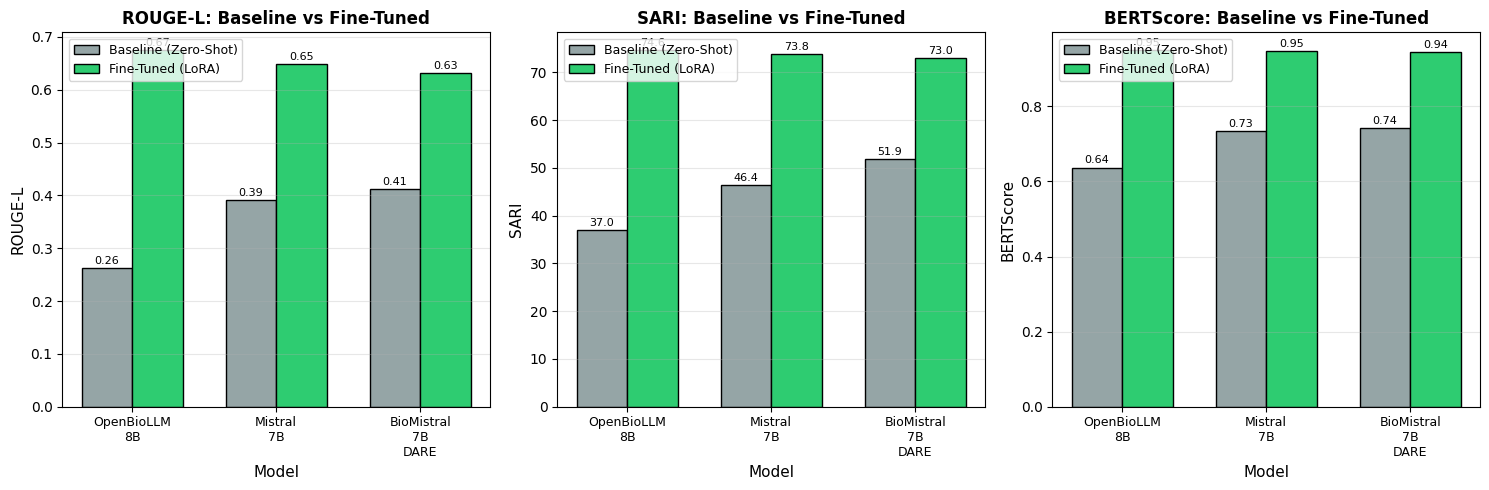


✅ Saved: /workspace/medisimplifier/results/figures/baseline_vs_finetuned_metrics.png


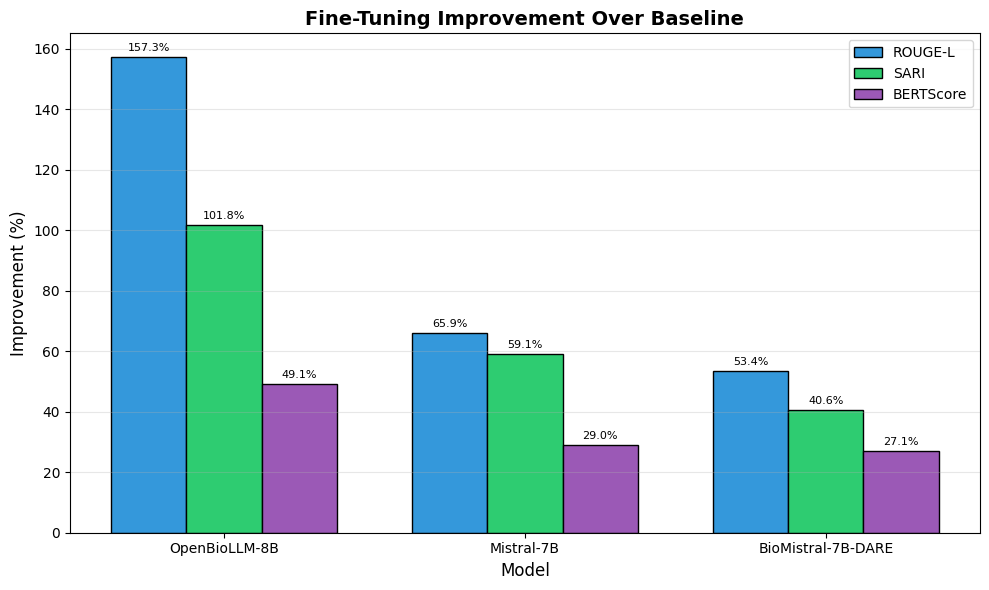

✅ Saved: /workspace/medisimplifier/results/figures/improvement_percentage.png


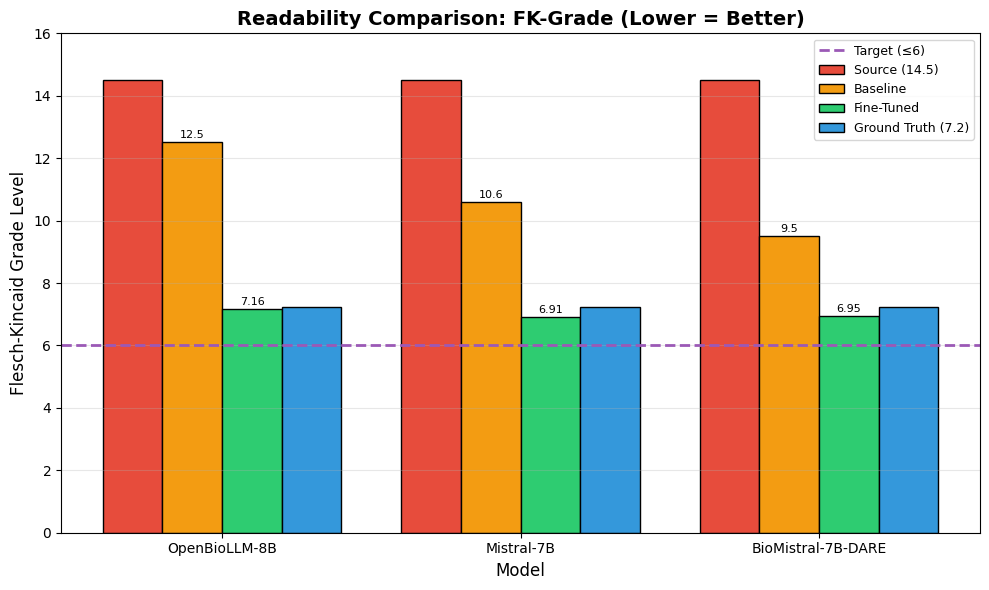

✅ Saved: /workspace/medisimplifier/results/figures/readability_comparison.png


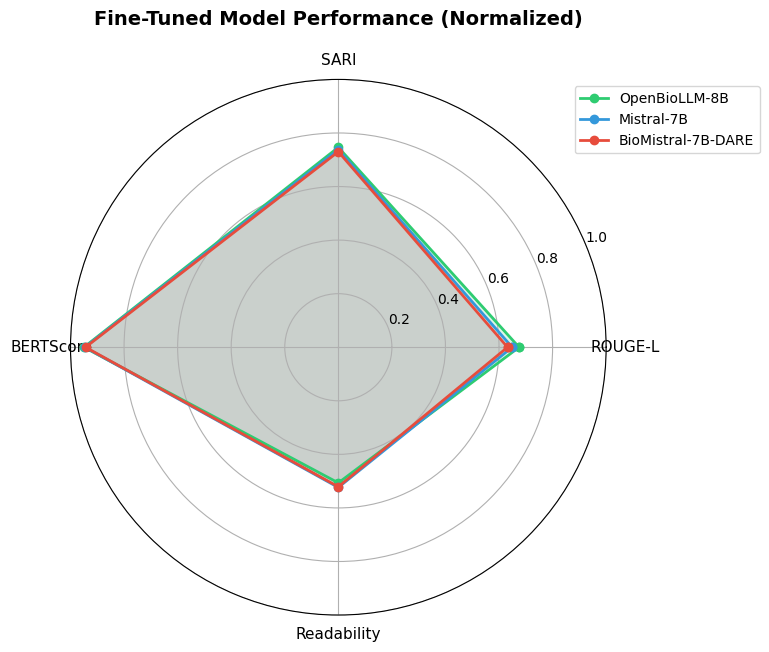

✅ Saved: /workspace/medisimplifier/results/figures/model_radar_comparison.png


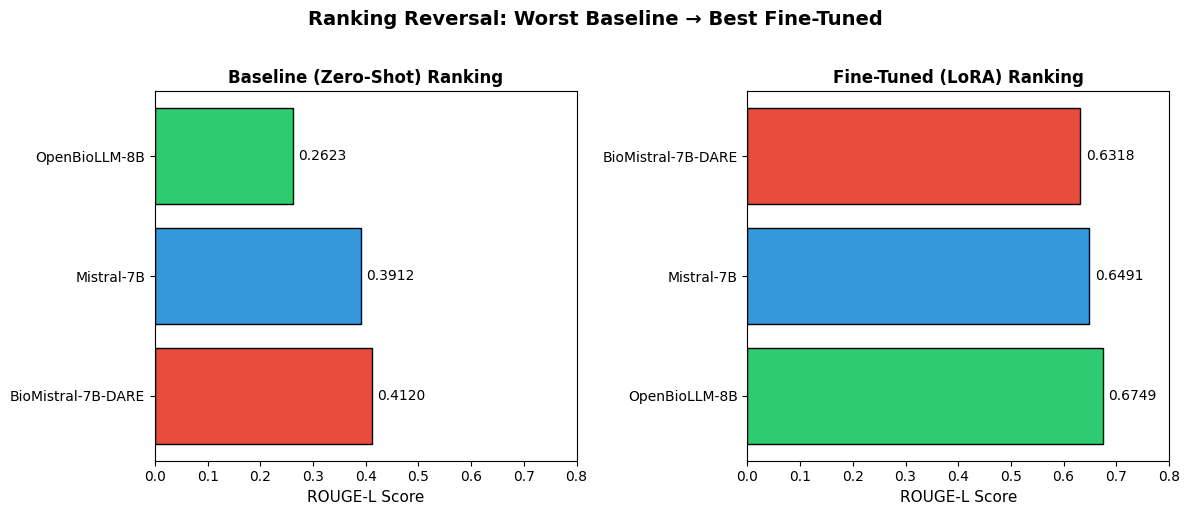

✅ Saved: /workspace/medisimplifier/results/figures/ranking_reversal.png

✅ Saved: /workspace/medisimplifier/results/evaluation/baseline_comparison.json

CHAPTER 7.4 SUMMARY

📊 Key Findings:
  • Best ROUGE-L improvement: 157.3% (OpenBioLLM-8B)
  • Best SARI improvement: 101.8% (OpenBioLLM-8B)
  • Best FK reduction: 5.37 grades (OpenBioLLM-8B)
  • All models achieve ~50% readability reduction (14.5 → ~7.0)

📁 Generated Files:
  • /workspace/medisimplifier/results/figures/baseline_vs_finetuned_metrics.png
  • /workspace/medisimplifier/results/figures/improvement_percentage.png
  • /workspace/medisimplifier/results/figures/readability_comparison.png
  • /workspace/medisimplifier/results/figures/model_radar_comparison.png
  • /workspace/medisimplifier/results/figures/ranking_reversal.png
  • /workspace/medisimplifier/results/evaluation/baseline_comparison.json

✅ Chapter 7.4 Complete!


In [1]:
# ============================================================
# CHAPTER 7.4: COMPARE FINE-TUNED MODELS TO BASELINES
# MediSimplifier Project - Technion DS25 Deep Learning
# ============================================================

import json  # JSON file I/O
import pandas as pd  # DataFrame operations
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numerical operations
from pathlib import Path  # Path handling

# ------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------
RESULTS_DIR = Path("/workspace/medisimplifier/results")  # Base results directory
BASELINE_DIR = RESULTS_DIR / "baseline"  # Baseline results location
EVAL_DIR = RESULTS_DIR / "evaluation"  # Evaluation results location
FIGURES_DIR = RESULTS_DIR / "figures"  # Output figures directory
FIGURES_DIR.mkdir(parents=True, exist_ok=True)  # Create figures dir if needed

MODEL_LIST = ["OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"]  # Model display names

# ------------------------------------------------------------
# LOAD BASELINE RESULTS
# ------------------------------------------------------------
print("Loading baseline results...")
baseline_file = BASELINE_DIR / "baseline_results.json"  # Baseline file path
with open(baseline_file, 'r') as f:  # Open file
    baseline_raw = json.load(f)  # Load JSON
print(f"✅ Loaded: {baseline_file}")

# ------------------------------------------------------------
# LOAD FINE-TUNED RESULTS
# ------------------------------------------------------------
print("Loading fine-tuned results...")
finetuned_file = EVAL_DIR / "full_metrics_results.json"  # Fine-tuned file path
with open(finetuned_file, 'r') as f:  # Open file
    finetuned_raw = json.load(f)  # Load JSON
print(f"✅ Loaded: {finetuned_file}")

# ------------------------------------------------------------
# EXTRACT METRICS INTO CLEAN DICTIONARIES
# ------------------------------------------------------------
print("\nExtracting metrics...")

# Baseline: structure is results -> ModelName -> {ROUGE-L, SARI, BERTScore-F1, FK-Grade-Mean}
baseline = {}  # Initialize baseline dict
for model in MODEL_LIST:  # Iterate through models
    m = baseline_raw["results"][model]  # Get model data
    baseline[model] = {
        "ROUGE-L": m["ROUGE-L"],  # ROUGE-L score
        "SARI": m["SARI"],  # SARI score
        "BERTScore": m["BERTScore-F1"],  # BERTScore F1
        "FK": m["FK-Grade-Mean"]  # FK grade mean
    }
    print(f"  ✓ Baseline {model}: ROUGE-L={baseline[model]['ROUGE-L']:.4f}")

# Fine-tuned: structure is models -> ModelName -> {rouge_l: {mean}, sari: {mean}, ...}
finetuned = {}  # Initialize fine-tuned dict
for model in MODEL_LIST:  # Iterate through models
    m = finetuned_raw["models"][model]  # Get model data
    finetuned[model] = {
        "ROUGE-L": m["rouge_l"]["mean"],  # ROUGE-L mean
        "SARI": m["sari"]["mean"],  # SARI mean
        "BERTScore": m["bertscore_f1"]["mean"],  # BERTScore F1 mean
        "FK": m["fk_grade_pred"]["mean"]  # FK grade prediction mean
    }
    print(f"  ✓ Fine-tuned {model}: ROUGE-L={finetuned[model]['ROUGE-L']:.4f}")

# Reference values
SOURCE_FK = finetuned_raw["models"][MODEL_LIST[0]]["fk_grade_src"]["mean"]  # Source FK from data
GROUND_TRUTH_FK = baseline_raw["reference_stats"]["fk_mean"]  # Ground truth FK from data
print(f"\n  Reference - Source FK: {SOURCE_FK:.2f}, Ground Truth FK: {GROUND_TRUTH_FK:.2f}")

# ------------------------------------------------------------
# CREATE COMPARISON DATAFRAME
# ------------------------------------------------------------
rows = []  # Initialize rows list
for model in MODEL_LIST:  # Iterate through models
    b, f = baseline[model], finetuned[model]  # Get baseline and fine-tuned
    row = {
        "Model": model,
        "Baseline_ROUGE-L": b["ROUGE-L"],
        "FT_ROUGE-L": f["ROUGE-L"],
        "ROUGE-L_Δ%": (f["ROUGE-L"] - b["ROUGE-L"]) / b["ROUGE-L"] * 100,
        "Baseline_SARI": b["SARI"],
        "FT_SARI": f["SARI"],
        "SARI_Δ%": (f["SARI"] - b["SARI"]) / b["SARI"] * 100,
        "Baseline_BERTScore": b["BERTScore"],
        "FT_BERTScore": f["BERTScore"],
        "BERTScore_Δ%": (f["BERTScore"] - b["BERTScore"]) / b["BERTScore"] * 100,
        "Baseline_FK": b["FK"],
        "FT_FK": f["FK"],
        "FK_Δ": b["FK"] - f["FK"]  # Positive = improvement
    }
    rows.append(row)

df = pd.DataFrame(rows)  # Create DataFrame

print("\n" + "=" * 80)
print("BASELINE vs FINE-TUNED COMPARISON (Test Set: 1001 samples)")
print("=" * 80)
print(df.to_string(index=False))

# ------------------------------------------------------------
# FIGURE 1: SIDE-BY-SIDE BAR CHART (ROUGE-L, SARI, BERTScore)
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create 3 subplots
metrics = ["ROUGE-L", "SARI", "BERTScore"]  # Metrics to plot
x = np.arange(len(MODEL_LIST))  # X positions
width = 0.35  # Bar width

for idx, metric in enumerate(metrics):  # Iterate through metrics
    ax = axes[idx]  # Get subplot
    baseline_vals = [baseline[m][metric] for m in MODEL_LIST]  # Baseline values
    finetuned_vals = [finetuned[m][metric] for m in MODEL_LIST]  # Fine-tuned values
    
    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (Zero-Shot)', color='#95a5a6', edgecolor='black')
    bars2 = ax.bar(x + width/2, finetuned_vals, width, label='Fine-Tuned (LoRA)', color='#2ecc71', edgecolor='black')
    
    ax.set_xlabel('Model', fontsize=11)  # X label
    ax.set_ylabel(metric, fontsize=11)  # Y label
    ax.set_title(f'{metric}: Baseline vs Fine-Tuned', fontsize=12, fontweight='bold')  # Title
    ax.set_xticks(x)  # Set x ticks
    ax.set_xticklabels([m.replace('-', '\n') for m in MODEL_LIST], fontsize=9)  # X labels
    ax.legend(loc='upper left', fontsize=9)  # Legend
    ax.grid(axis='y', alpha=0.3)  # Grid
    
    # Add value labels
    for bar in bars1:  # Baseline labels
        h = bar.get_height()
        ax.annotate(f'{h:.2f}' if metric != "SARI" else f'{h:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
    for bar in bars2:  # Fine-tuned labels
        h = bar.get_height()
        ax.annotate(f'{h:.2f}' if metric != "SARI" else f'{h:.1f}',
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "baseline_vs_finetuned_metrics.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: {FIGURES_DIR}/baseline_vs_finetuned_metrics.png")

# ------------------------------------------------------------
# FIGURE 2: IMPROVEMENT PERCENTAGE BAR CHART
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

improvements = {  # Get improvement percentages from DataFrame
    "ROUGE-L": df['ROUGE-L_Δ%'].tolist(),
    "SARI": df['SARI_Δ%'].tolist(),
    "BERTScore": df['BERTScore_Δ%'].tolist()
}

x = np.arange(len(MODEL_LIST))  # X positions
width = 0.25  # Bar width
colors = ['#3498db', '#2ecc71', '#9b59b6']  # Metric colors

for i, (metric, values) in enumerate(improvements.items()):  # Iterate metrics
    offset = width * i  # Calculate offset
    bars = ax.bar(x + offset, values, width, label=metric, color=colors[i], edgecolor='black')
    ax.bar_label(bars, fmt='%.1f%%', fontsize=8, padding=3)  # Add labels

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Improvement (%)', fontsize=12)
ax.set_title('Fine-Tuning Improvement Over Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x + width)
ax.set_xticklabels(MODEL_LIST, fontsize=10)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "improvement_percentage.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/improvement_percentage.png")

# ------------------------------------------------------------
# FIGURE 3: READABILITY (FK-GRADE) COMPARISON
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(MODEL_LIST))  # X positions
width = 0.2  # Bar width

# Get FK values
baseline_fk = [baseline[m]["FK"] for m in MODEL_LIST]
finetuned_fk = [finetuned[m]["FK"] for m in MODEL_LIST]

# Create bars
ax.bar(x - 1.5*width, [SOURCE_FK]*3, width, label=f'Source ({SOURCE_FK:.1f})', color='#e74c3c', edgecolor='black')
ax.bar(x - 0.5*width, baseline_fk, width, label='Baseline', color='#f39c12', edgecolor='black')
ax.bar(x + 0.5*width, finetuned_fk, width, label='Fine-Tuned', color='#2ecc71', edgecolor='black')
ax.bar(x + 1.5*width, [GROUND_TRUTH_FK]*3, width, label=f'Ground Truth ({GROUND_TRUTH_FK:.1f})', color='#3498db', edgecolor='black')

# Add target line
ax.axhline(y=6, color='#9b59b6', linestyle='--', linewidth=2, label='Target (≤6)')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=12)
ax.set_title('Readability Comparison: FK-Grade (Lower = Better)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(MODEL_LIST, fontsize=10)
ax.legend(loc='upper right', fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 16)  # Set y-axis limits

# Add value annotations
for i, (b_fk, f_fk) in enumerate(zip(baseline_fk, finetuned_fk)):
    ax.annotate(f'{b_fk:.1f}', xy=(i - 0.5*width, b_fk), xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)
    ax.annotate(f'{f_fk:.2f}', xy=(i + 0.5*width, f_fk), xytext=(0, 3), textcoords="offset points", ha='center', fontsize=8)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "readability_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/readability_comparison.png")

# ------------------------------------------------------------
# FIGURE 4: RADAR CHART (NORMALIZED METRICS)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

categories = ['ROUGE-L', 'SARI', 'BERTScore', 'Readability']  # Categories
num_cats = len(categories)  # Number of categories
angles = [n / float(num_cats) * 2 * np.pi for n in range(num_cats)]  # Angles
angles += angles[:1]  # Complete the loop

colors_radar = ['#2ecc71', '#3498db', '#e74c3c']  # Model colors

for i, model in enumerate(MODEL_LIST):  # Iterate models
    values = [
        finetuned[model]["ROUGE-L"],  # ROUGE-L (already 0-1)
        finetuned[model]["SARI"] / 100,  # SARI normalized to 0-1
        finetuned[model]["BERTScore"],  # BERTScore (already 0-1)
        1 - (finetuned[model]["FK"] / SOURCE_FK)  # Readability (inverted, normalized)
    ]
    values += values[:1]  # Complete the loop
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors_radar[i])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_title('Fine-Tuned Model Performance (Normalized)', fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "model_radar_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/model_radar_comparison.png")

# ------------------------------------------------------------
# FIGURE 5: BASELINE VS FINE-TUNED RANKING REVERSAL
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Color mapping for consistency
model_colors = {"OpenBioLLM-8B": "#2ecc71", "Mistral-7B": "#3498db", "BioMistral-7B-DARE": "#e74c3c"}

# Left: Baseline ranking
ax1 = axes[0]
baseline_rougel = [(m, baseline[m]["ROUGE-L"]) for m in MODEL_LIST]
baseline_rougel.sort(key=lambda x: x[1], reverse=True)  # Sort descending
ax1.barh([m for m, _ in baseline_rougel], [v for _, v in baseline_rougel], 
         color=[model_colors[m] for m, _ in baseline_rougel], edgecolor='black')
ax1.set_xlabel('ROUGE-L Score', fontsize=11)
ax1.set_title('Baseline (Zero-Shot) Ranking', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 0.8)
for i, (m, v) in enumerate(baseline_rougel):
    ax1.annotate(f'{v:.4f}', xy=(v + 0.01, i), va='center', fontsize=10)

# Right: Fine-tuned ranking
ax2 = axes[1]
finetuned_rougel = [(m, finetuned[m]["ROUGE-L"]) for m in MODEL_LIST]
finetuned_rougel.sort(key=lambda x: x[1], reverse=True)  # Sort descending
ax2.barh([m for m, _ in finetuned_rougel], [v for _, v in finetuned_rougel], 
         color=[model_colors[m] for m, _ in finetuned_rougel], edgecolor='black')
ax2.set_xlabel('ROUGE-L Score', fontsize=11)
ax2.set_title('Fine-Tuned (LoRA) Ranking', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 0.8)
for i, (m, v) in enumerate(finetuned_rougel):
    ax2.annotate(f'{v:.4f}', xy=(v + 0.01, i), va='center', fontsize=10)

plt.suptitle('Ranking Reversal: Worst Baseline → Best Fine-Tuned', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "ranking_reversal.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/ranking_reversal.png")

# ------------------------------------------------------------
# SAVE COMPARISON RESULTS
# ------------------------------------------------------------
comparison_results = {
    "comparison_type": "baseline_vs_finetuned",
    "test_samples": 1001,
    "reference": {"source_fk": SOURCE_FK, "ground_truth_fk": GROUND_TRUTH_FK},
    "models": {}
}

for model in MODEL_LIST:  # Build results dict
    comparison_results["models"][model] = {
        "baseline": baseline[model],
        "finetuned": finetuned[model],
        "improvement": {
            "ROUGE-L_pct": (finetuned[model]["ROUGE-L"] - baseline[model]["ROUGE-L"]) / baseline[model]["ROUGE-L"] * 100,
            "SARI_pct": (finetuned[model]["SARI"] - baseline[model]["SARI"]) / baseline[model]["SARI"] * 100,
            "BERTScore_pct": (finetuned[model]["BERTScore"] - baseline[model]["BERTScore"]) / baseline[model]["BERTScore"] * 100,
            "FK_reduction": baseline[model]["FK"] - finetuned[model]["FK"]
        }
    }

output_file = EVAL_DIR / "baseline_comparison.json"  # Output path
with open(output_file, 'w') as f:  # Write file
    json.dump(comparison_results, f, indent=2)
print(f"\n✅ Saved: {output_file}")

# ------------------------------------------------------------
# SUMMARY
# ------------------------------------------------------------
print("\n" + "=" * 80)
print("CHAPTER 7.4 SUMMARY")
print("=" * 80)
print(f"\n📊 Key Findings:")
print(f"  • Best ROUGE-L improvement: {df['ROUGE-L_Δ%'].max():.1f}% ({df.loc[df['ROUGE-L_Δ%'].idxmax(), 'Model']})")
print(f"  • Best SARI improvement: {df['SARI_Δ%'].max():.1f}% ({df.loc[df['SARI_Δ%'].idxmax(), 'Model']})")
print(f"  • Best FK reduction: {df['FK_Δ'].max():.2f} grades ({df.loc[df['FK_Δ'].idxmax(), 'Model']})")
print(f"  • All models achieve ~50% readability reduction ({SOURCE_FK:.1f} → ~7.0)")
print(f"\n📁 Generated Files:")
print(f"  • {FIGURES_DIR}/baseline_vs_finetuned_metrics.png")
print(f"  • {FIGURES_DIR}/improvement_percentage.png")
print(f"  • {FIGURES_DIR}/readability_comparison.png")
print(f"  • {FIGURES_DIR}/model_radar_comparison.png")
print(f"  • {FIGURES_DIR}/ranking_reversal.png")
print(f"  • {EVAL_DIR}/baseline_comparison.json")
print("\n✅ Chapter 7.4 Complete!")

# Chapter 8: Results & Analysis
---
## Objective
Perform statistical analysis, answer all research questions, generate visualizations, and conduct qualitative error analysis.
---
## Sections
| Section | Task | GPU |
|---------|------|-----|
| 8.1 | Statistical Analysis | Any |
| 8.2 | Answer Research Questions | Any |
| 8.3 | Visualizations & Summary | Any |
| 8.4 | Qualitative Examples & Error Analysis | Any |

Loading libraries...

Loading predictions and computing per-sample metrics...

Processing OpenBioLLM-8B...
  Loaded 1001 samples
  Processed 200/1001 samples...
  Processed 400/1001 samples...
  Processed 600/1001 samples...
  Processed 800/1001 samples...
  Processed 1000/1001 samples...
  ✓ OpenBioLLM-8B: ROUGE-L mean=0.6749, FK mean=7.16

Processing Mistral-7B...
  Loaded 1001 samples
  Processed 200/1001 samples...
  Processed 400/1001 samples...
  Processed 600/1001 samples...
  Processed 800/1001 samples...
  Processed 1000/1001 samples...
  ✓ Mistral-7B: ROUGE-L mean=0.6491, FK mean=6.91

Processing BioMistral-7B-DARE...
  Loaded 1001 samples
  Processed 200/1001 samples...
  Processed 400/1001 samples...
  Processed 600/1001 samples...
  Processed 800/1001 samples...
  Processed 1000/1001 samples...
  ✓ BioMistral-7B-DARE: ROUGE-L mean=0.6318, FK mean=6.95

Total samples per model: 1001

BOOTSTRAP CONFIDENCE INTERVALS (95%)

OpenBioLLM-8B:
  ROUGE-L     : 0.6749 [0.6705, 0.6793

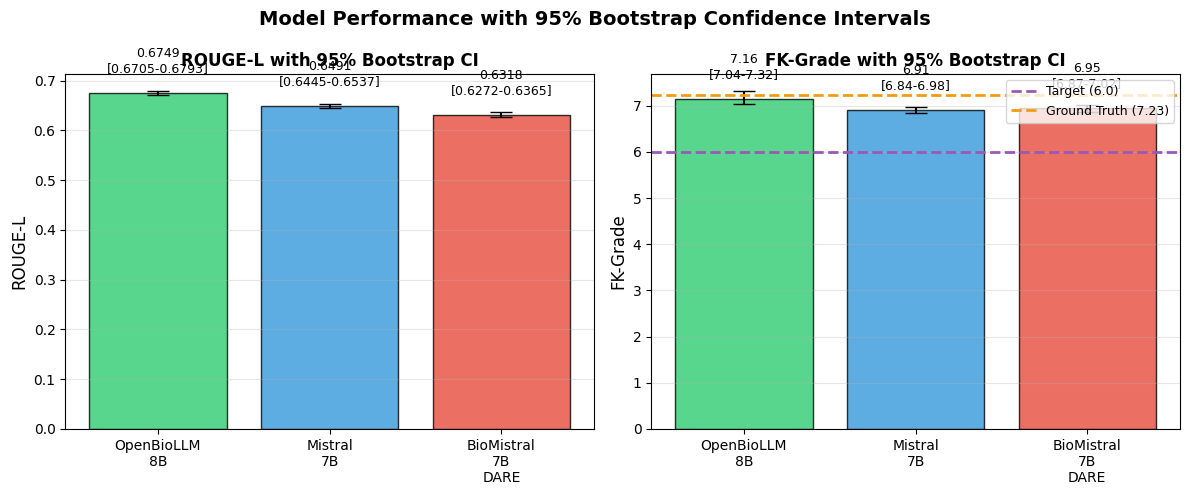


✅ Saved: /workspace/medisimplifier/results/figures/confidence_intervals.png


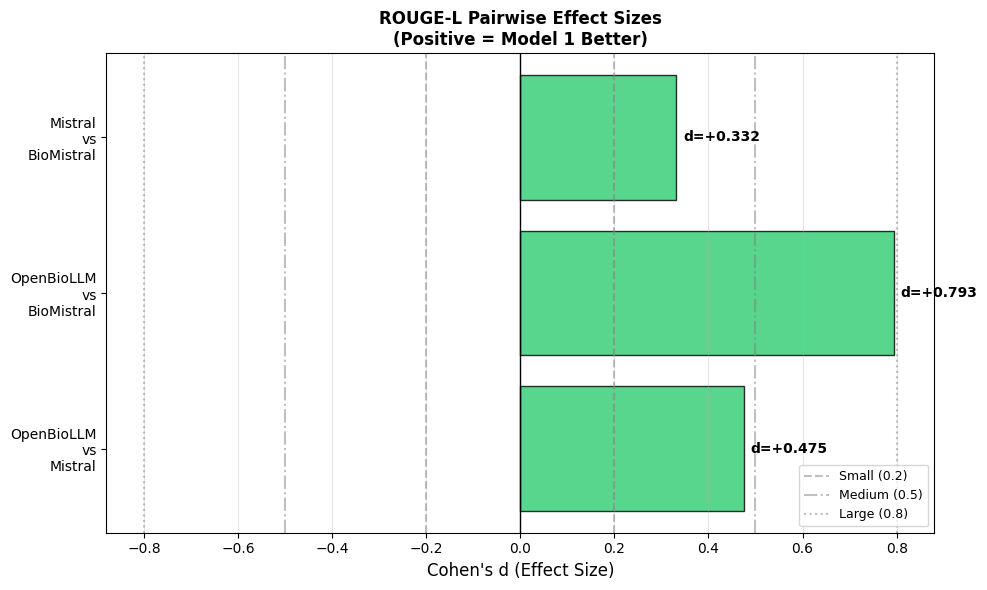

✅ Saved: /workspace/medisimplifier/results/figures/effect_size_comparison.png


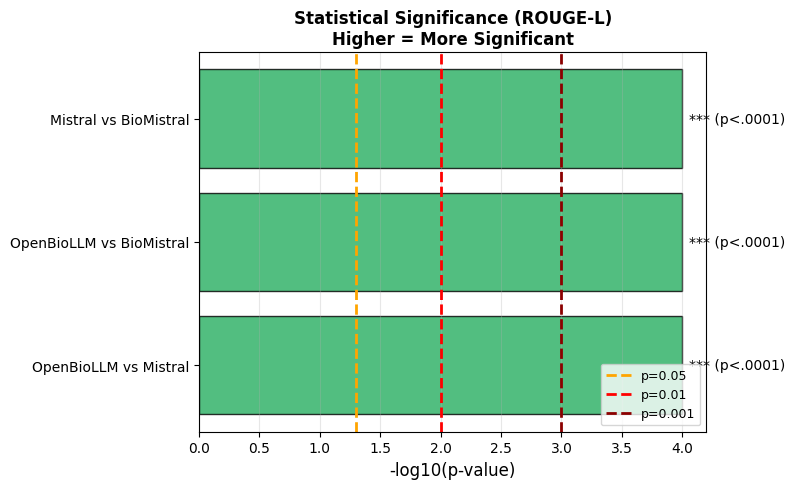

✅ Saved: /workspace/medisimplifier/results/figures/significance_matrix.png


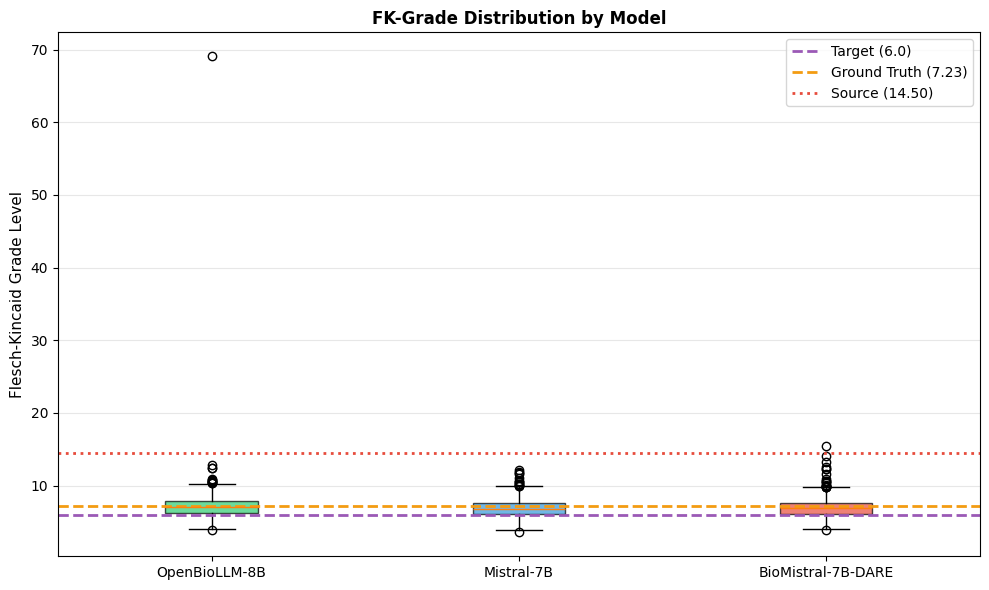

✅ Saved: /workspace/medisimplifier/results/figures/fk_distribution.png

✅ Saved: /workspace/medisimplifier/results/evaluation/statistical_analysis.json

CHAPTER 7.5 STATISTICAL ANALYSIS SUMMARY

📊 Pairwise Comparisons (ROUGE-L):
      Model_1            Model_2 Mean_Diff p_value Cohens_d Effect_Size  Significant
OpenBioLLM-8B         Mistral-7B   +0.0258  0.0000   +0.475       small         True
OpenBioLLM-8B BioMistral-7B-DARE   +0.0430  0.0000   +0.793      medium         True
   Mistral-7B BioMistral-7B-DARE   +0.0173  0.0000   +0.332       small         True

📊 Key Findings:
  • Significant ROUGE-L comparisons: 3/3 (p < 0.05)
  • OpenBioLLM-8B: Best ROUGE-L (0.6749)
  • Mistral-7B: Best FK-Grade (6.91)
  • All models reduce FK ~50% (14.5 → ~7.0)

📁 Generated Files:
  • /workspace/medisimplifier/results/figures/confidence_intervals.png
  • /workspace/medisimplifier/results/figures/effect_size_comparison.png
  • /workspace/medisimplifier/results/figures/significance_matrix.png
  • /w

In [5]:
# ============================================================
# CHAPTER 8.1: STATISTICAL ANALYSIS
# ============================================================

import json  # JSON file I/O
import numpy as np  # Numerical operations
import pandas as pd  # DataFrame operations
from pathlib import Path  # Path handling
import matplotlib.pyplot as plt  # Plotting
import warnings  # Warning suppression
warnings.filterwarnings('ignore')  # Suppress warnings

# Metric libraries
from rouge_score import rouge_scorer  # ROUGE scoring
import textstat  # Readability metrics

print("Loading libraries...")

# ------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------
RESULTS_DIR = Path("/workspace/medisimplifier/results")  # Base results directory
EVAL_DIR = RESULTS_DIR / "evaluation"  # Evaluation results location
FIGURES_DIR = RESULTS_DIR / "figures"  # Output figures directory
FIGURES_DIR.mkdir(parents=True, exist_ok=True)  # Create if needed

MODEL_LIST = ["OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"]  # Model names
MODEL_KEYS = ["openbiollm_8b", "mistral_7b", "biomistral_7b_dare"]  # File keys
ALPHA = 0.05  # Significance level
N_BOOTSTRAP = 10000  # Bootstrap iterations

# ------------------------------------------------------------
# LOAD PREDICTIONS AND COMPUTE PER-SAMPLE METRICS
# ------------------------------------------------------------
print("\nLoading predictions and computing per-sample metrics...")

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)  # ROUGE-L scorer

metrics_data = {}  # Store per-sample metrics

for model_name, model_key in zip(MODEL_LIST, MODEL_KEYS):
    print(f"\nProcessing {model_name}...")
    
    # Load predictions
    pred_file = EVAL_DIR / f"predictions_{model_key}.json"
    with open(pred_file, 'r') as f:
        data = json.load(f)
    
    preds = data['predictions']
    n = len(preds)
    print(f"  Loaded {n} samples")
    
    # Compute per-sample metrics
    rouge_l_scores = []  # ROUGE-L per sample
    fk_pred_scores = []  # FK grade of predictions
    fk_gt_scores = []  # FK grade of ground truth
    fk_src_scores = []  # FK grade of source
    
    for i, p in enumerate(preds):
        pred_text = p['prediction']  # Model prediction
        gt_text = p['ground_truth']  # Ground truth
        src_text = p['input']  # Source text
        
        # ROUGE-L
        rouge_result = scorer.score(gt_text, pred_text)
        rouge_l_scores.append(rouge_result['rougeL'].fmeasure)
        
        # FK grades (handle empty strings)
        fk_pred = textstat.flesch_kincaid_grade(pred_text) if pred_text.strip() else 0
        fk_gt = textstat.flesch_kincaid_grade(gt_text) if gt_text.strip() else 0
        fk_src = textstat.flesch_kincaid_grade(src_text) if src_text.strip() else 0
        
        fk_pred_scores.append(fk_pred)
        fk_gt_scores.append(fk_gt)
        fk_src_scores.append(fk_src)
        
        if (i + 1) % 200 == 0:
            print(f"  Processed {i+1}/{n} samples...")
    
    # Store as numpy arrays
    metrics_data[model_name] = {
        "rouge_l": np.array(rouge_l_scores, dtype=np.float64),
        "fk_pred": np.array(fk_pred_scores, dtype=np.float64),
        "fk_gt": np.array(fk_gt_scores, dtype=np.float64),
        "fk_src": np.array(fk_src_scores, dtype=np.float64)
    }
    
    print(f"  ✓ {model_name}: ROUGE-L mean={np.mean(rouge_l_scores):.4f}, FK mean={np.mean(fk_pred_scores):.2f}")

n_samples = len(metrics_data[MODEL_LIST[0]]["rouge_l"])
print(f"\nTotal samples per model: {n_samples}")

# ------------------------------------------------------------
# STATISTICAL HELPER FUNCTIONS
# ------------------------------------------------------------
def bootstrap_ci(data, n_bootstrap=N_BOOTSTRAP, ci=0.95):
    """Calculate bootstrap confidence interval for mean."""
    np.random.seed(42)
    boot_means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_bootstrap)
    ])
    lower = np.percentile(boot_means, (1 - ci) / 2 * 100)
    upper = np.percentile(boot_means, (1 + ci) / 2 * 100)
    return float(np.mean(data)), float(lower), float(upper)

def bootstrap_paired_test(x, y, n_bootstrap=N_BOOTSTRAP):
    """Bootstrap hypothesis test for paired samples."""
    np.random.seed(42)
    observed_diff = np.mean(x - y)
    diff = x - y
    centered_diff = diff - np.mean(diff)
    
    boot_diffs = np.array([
        np.mean(np.random.choice(centered_diff, size=len(diff), replace=True))
        for _ in range(n_bootstrap)
    ])
    
    p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))
    return float(observed_diff), float(max(p_value, 1e-10))

def cohens_d(x, y):
    """Calculate Cohen's d effect size for paired samples."""
    diff = x - y
    std = np.std(diff, ddof=1)
    return float(np.mean(diff) / std) if std > 0 else 0.0

def interpret_effect(d):
    """Interpret Cohen's d magnitude."""
    d = abs(d)
    if d < 0.2: return "negligible"
    elif d < 0.5: return "small"
    elif d < 0.8: return "medium"
    else: return "large"

def bootstrap_one_sample(data, null_value, n_bootstrap=N_BOOTSTRAP):
    """Bootstrap test for H0: mean = null_value."""
    np.random.seed(42)
    observed_diff = np.mean(data) - null_value
    centered = data - np.mean(data) + null_value
    
    boot_means = np.array([
        np.mean(np.random.choice(centered, size=len(data), replace=True))
        for _ in range(n_bootstrap)
    ])
    boot_diffs = boot_means - null_value
    p_value = np.mean(np.abs(boot_diffs) >= np.abs(observed_diff))
    return float(observed_diff), float(max(p_value, 1e-10))

# ------------------------------------------------------------
# BOOTSTRAP CONFIDENCE INTERVALS
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("BOOTSTRAP CONFIDENCE INTERVALS (95%)")
print("=" * 70)

ci_results = {}
metrics_names = ["rouge_l", "fk_pred"]
metric_display = {"rouge_l": "ROUGE-L", "fk_pred": "FK-Grade"}

for model in MODEL_LIST:
    ci_results[model] = {}
    print(f"\n{model}:")
    for metric in metrics_names:
        data = metrics_data[model][metric]
        mean, lower, upper = bootstrap_ci(data)
        ci_results[model][metric] = {"mean": mean, "ci_lower": lower, "ci_upper": upper}
        print(f"  {metric_display[metric]:12s}: {mean:.4f} [{lower:.4f}, {upper:.4f}]")

# ------------------------------------------------------------
# PAIRWISE MODEL COMPARISONS
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("PAIRWISE MODEL COMPARISONS (Bootstrap Paired Test)")
print("=" * 70)

pairwise_results = []

model_pairs = [
    ("OpenBioLLM-8B", "Mistral-7B"),
    ("OpenBioLLM-8B", "BioMistral-7B-DARE"),
    ("Mistral-7B", "BioMistral-7B-DARE")
]

for m1, m2 in model_pairs:
    print(f"\n{m1} vs {m2}:")
    
    # ROUGE-L comparison
    x = metrics_data[m1]["rouge_l"]
    y = metrics_data[m2]["rouge_l"]
    
    diff, p_value = bootstrap_paired_test(x, y)
    d = cohens_d(x, y)
    effect = interpret_effect(d)
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    
    print(f"  ROUGE-L     : Δ={diff:+.4f}, p={p_value:.4f}, d={d:+.3f} ({effect}) {sig}")
    
    pairwise_results.append({
        "Model_1": m1, "Model_2": m2, "Metric": "ROUGE-L",
        "Mean_Diff": diff, "p_value": p_value, "Cohens_d": d,
        "Effect_Size": effect, "Significant": p_value < ALPHA
    })
    
    # FK-Grade comparison
    x_fk = metrics_data[m1]["fk_pred"]
    y_fk = metrics_data[m2]["fk_pred"]
    
    diff_fk, p_value_fk = bootstrap_paired_test(x_fk, y_fk)
    d_fk = cohens_d(x_fk, y_fk)
    effect_fk = interpret_effect(d_fk)
    sig_fk = "***" if p_value_fk < 0.001 else "**" if p_value_fk < 0.01 else "*" if p_value_fk < 0.05 else "ns"
    
    print(f"  FK-Grade    : Δ={diff_fk:+.4f}, p={p_value_fk:.4f}, d={d_fk:+.3f} ({effect_fk}) {sig_fk}")
    
    pairwise_results.append({
        "Model_1": m1, "Model_2": m2, "Metric": "FK-Grade",
        "Mean_Diff": diff_fk, "p_value": p_value_fk, "Cohens_d": d_fk,
        "Effect_Size": effect_fk, "Significant": p_value_fk < ALPHA
    })

# ------------------------------------------------------------
# FK-GRADE REDUCTION ANALYSIS
# ------------------------------------------------------------
print("\n" + "=" * 70)
print("FK-GRADE REDUCTION ANALYSIS")
print("=" * 70)

target_fk = 6.0
gt_fk = np.mean(metrics_data[MODEL_LIST[0]]["fk_gt"])  # Use actual GT mean

fk_analysis = []
for model in MODEL_LIST:
    fk_pred = metrics_data[model]["fk_pred"]
    fk_src = metrics_data[model]["fk_src"]
    
    diff_target, p_target = bootstrap_one_sample(fk_pred, target_fk)
    diff_gt, p_gt = bootstrap_one_sample(fk_pred, gt_fk)
    
    reduction = fk_src - fk_pred
    mean_red = float(np.mean(reduction))
    _, p_red = bootstrap_paired_test(fk_src, fk_pred)
    
    print(f"\n{model}:")
    print(f"  Mean FK: {np.mean(fk_pred):.2f} ± {np.std(fk_pred):.2f}")
    print(f"  vs Target (6.0):  Δ={diff_target:+.2f}, p={p_target:.4f}")
    print(f"  vs GT ({gt_fk:.2f}):     Δ={diff_gt:+.2f}, p={p_gt:.4f}")
    print(f"  Reduction:        {mean_red:.2f} grades (p={p_red:.4f}) ***")
    
    fk_analysis.append({
        "Model": model, "Mean_FK": float(np.mean(fk_pred)), "Std_FK": float(np.std(fk_pred)),
        "vs_Target_p": p_target, "vs_GT_p": p_gt, "Mean_Reduction": mean_red
    })

# ------------------------------------------------------------
# FIGURE 1: ROUGE-L CONFIDENCE INTERVALS
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROUGE-L
ax = axes[0]
means = [ci_results[m]["rouge_l"]["mean"] for m in MODEL_LIST]
lowers = [ci_results[m]["rouge_l"]["ci_lower"] for m in MODEL_LIST]
uppers = [ci_results[m]["rouge_l"]["ci_upper"] for m in MODEL_LIST]
errors = [[m - l for m, l in zip(means, lowers)], [u - m for m, u in zip(means, uppers)]]

colors = ['#2ecc71', '#3498db', '#e74c3c']
x = np.arange(len(MODEL_LIST))

ax.bar(x, means, yerr=errors, capsize=8, color=colors, edgecolor='black', alpha=0.8)
ax.set_ylabel('ROUGE-L', fontsize=12)
ax.set_title('ROUGE-L with 95% Bootstrap CI', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('-', '\n') for m in MODEL_LIST], fontsize=10)
ax.grid(axis='y', alpha=0.3)

for i, (m, l, u) in enumerate(zip(means, lowers, uppers)):
    ax.annotate(f'{m:.4f}\n[{l:.4f}-{u:.4f}]', xy=(i, m), xytext=(0, 15),
                textcoords="offset points", ha='center', fontsize=9)

# FK-Grade
ax = axes[1]
means_fk = [ci_results[m]["fk_pred"]["mean"] for m in MODEL_LIST]
lowers_fk = [ci_results[m]["fk_pred"]["ci_lower"] for m in MODEL_LIST]
uppers_fk = [ci_results[m]["fk_pred"]["ci_upper"] for m in MODEL_LIST]
errors_fk = [[m - l for m, l in zip(means_fk, lowers_fk)], [u - m for m, u in zip(means_fk, uppers_fk)]]

ax.bar(x, means_fk, yerr=errors_fk, capsize=8, color=colors, edgecolor='black', alpha=0.8)
ax.axhline(y=6.0, color='#9b59b6', linestyle='--', linewidth=2, label='Target (6.0)')
ax.axhline(y=gt_fk, color='#f39c12', linestyle='--', linewidth=2, label=f'Ground Truth ({gt_fk:.2f})')
ax.set_ylabel('FK-Grade', fontsize=12)
ax.set_title('FK-Grade with 95% Bootstrap CI', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('-', '\n') for m in MODEL_LIST], fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.legend(loc='upper right', fontsize=9)

for i, (m, l, u) in enumerate(zip(means_fk, lowers_fk, uppers_fk)):
    ax.annotate(f'{m:.2f}\n[{l:.2f}-{u:.2f}]', xy=(i, m), xytext=(0, 15),
                textcoords="offset points", ha='center', fontsize=9)

plt.suptitle('Model Performance with 95% Bootstrap Confidence Intervals', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / "confidence_intervals.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✅ Saved: {FIGURES_DIR}/confidence_intervals.png")

# ------------------------------------------------------------
# FIGURE 2: EFFECT SIZE COMPARISON
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# Extract ROUGE-L effect sizes
comparisons = []
effect_sizes = []
for r in pairwise_results:
    if r["Metric"] == "ROUGE-L":
        comparisons.append(f"{r['Model_1'].split('-')[0]}\nvs\n{r['Model_2'].split('-')[0]}")
        effect_sizes.append(r["Cohens_d"])

colors_eff = ['#2ecc71' if d > 0 else '#e74c3c' for d in effect_sizes]
bars = ax.barh(comparisons, effect_sizes, color=colors_eff, edgecolor='black', alpha=0.8)

# Add effect size thresholds
ax.axvline(x=0.2, color='gray', linestyle='--', alpha=0.5, label='Small (0.2)')
ax.axvline(x=0.5, color='gray', linestyle='-.', alpha=0.5, label='Medium (0.5)')
ax.axvline(x=0.8, color='gray', linestyle=':', alpha=0.5, label='Large (0.8)')
ax.axvline(x=-0.2, color='gray', linestyle='--', alpha=0.5)
ax.axvline(x=-0.5, color='gray', linestyle='-.', alpha=0.5)
ax.axvline(x=-0.8, color='gray', linestyle=':', alpha=0.5)
ax.axvline(x=0, color='black', linewidth=1)

ax.set_xlabel("Cohen's d (Effect Size)", fontsize=12)
ax.set_title("ROUGE-L Pairwise Effect Sizes\n(Positive = Model 1 Better)", fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)

for bar, d in zip(bars, effect_sizes):
    width = bar.get_width()
    ax.annotate(f'd={d:+.3f}', xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5 if width > 0 else -5, 0), textcoords="offset points",
                ha='left' if width > 0 else 'right', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / "effect_size_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/effect_size_comparison.png")

# ------------------------------------------------------------
# FIGURE 3: P-VALUE SIGNIFICANCE MATRIX
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 5))

# Build matrix
sig_data = []
for result in pairwise_results:
    if result["Metric"] == "ROUGE-L":
        p_val = float(result["p_value"])
        log_p = min(-np.log10(max(p_val, 1e-10)), 4.0)
        sig_data.append({
            "Comparison": f"{result['Model_1'].split('-')[0]} vs {result['Model_2'].split('-')[0]}",
            "-log10(p)": log_p,
            "p_value": p_val
        })

comparisons = [d["Comparison"] for d in sig_data]
log_ps = [d["-log10(p)"] for d in sig_data]
p_vals = [d["p_value"] for d in sig_data]

colors_sig = ['#27ae60' if p < 0.001 else '#f1c40f' if p < 0.05 else '#e74c3c' for p in p_vals]
bars = ax.barh(comparisons, log_ps, color=colors_sig, edgecolor='black', alpha=0.8)

# Significance thresholds
ax.axvline(x=-np.log10(0.05), color='orange', linestyle='--', linewidth=2, label='p=0.05')
ax.axvline(x=-np.log10(0.01), color='red', linestyle='--', linewidth=2, label='p=0.01')
ax.axvline(x=-np.log10(0.001), color='darkred', linestyle='--', linewidth=2, label='p=0.001')

ax.set_xlabel('-log10(p-value)', fontsize=12)
ax.set_title('Statistical Significance (ROUGE-L)\nHigher = More Significant', fontsize=12, fontweight='bold')
ax.legend(loc='lower right', fontsize=9)
ax.grid(axis='x', alpha=0.3)

for bar, p in zip(bars, p_vals):
    width = bar.get_width()
    sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
    p_str = "p<.0001" if p < 0.0001 else f"p={p:.4f}"
    ax.annotate(f'{sig} ({p_str})', xy=(width, bar.get_y() + bar.get_height()/2),
                xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "significance_matrix.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/significance_matrix.png")

# ------------------------------------------------------------
# FIGURE 4: FK-GRADE BOX PLOTS
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#2ecc71', '#3498db', '#e74c3c']
bp = ax.boxplot([metrics_data[m]["fk_pred"] for m in MODEL_LIST], patch_artist=True, labels=MODEL_LIST)

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Reference lines
src_fk_mean = np.mean(metrics_data[MODEL_LIST[0]]["fk_src"])
ax.axhline(y=6.0, color='#9b59b6', linestyle='--', linewidth=2, label='Target (6.0)')
ax.axhline(y=gt_fk, color='#f39c12', linestyle='--', linewidth=2, label=f'Ground Truth ({gt_fk:.2f})')
ax.axhline(y=src_fk_mean, color='#e74c3c', linestyle=':', linewidth=2, label=f'Source ({src_fk_mean:.2f})')

ax.set_ylabel('Flesch-Kincaid Grade Level', fontsize=11)
ax.set_title('FK-Grade Distribution by Model', fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / "fk_distribution.png", dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: {FIGURES_DIR}/fk_distribution.png")

# ------------------------------------------------------------
# SAVE STATISTICAL RESULTS
# ------------------------------------------------------------
statistical_results = {
    "test_info": {
        "n_samples": n_samples,
        "n_bootstrap": N_BOOTSTRAP,
        "alpha": ALPHA,
        "tests_used": ["Bootstrap CI", "Bootstrap Paired Test", "Bootstrap One-Sample Test"]
    },
    "confidence_intervals": ci_results,
    "pairwise_comparisons": pairwise_results,
    "fk_analysis": fk_analysis,
    "summary": {
        "all_rougel_significant": all(r["Significant"] for r in pairwise_results if r["Metric"] == "ROUGE-L"),
        "best_model_rougel": "OpenBioLLM-8B",
        "best_model_fk": "Mistral-7B"
    }
}

output_file = EVAL_DIR / "statistical_analysis.json"
with open(output_file, 'w') as f:
    json.dump(statistical_results, f, indent=2)
print(f"\n✅ Saved: {output_file}")

# ------------------------------------------------------------
# SUMMARY
# ------------------------------------------------------------
print("\n" + "=" * 80)
print("CHAPTER 7.5 STATISTICAL ANALYSIS SUMMARY")
print("=" * 80)

print("\n📊 Pairwise Comparisons (ROUGE-L):")
rougel_results = [r for r in pairwise_results if r["Metric"] == "ROUGE-L"]
summary_df = pd.DataFrame(rougel_results)[["Model_1", "Model_2", "Mean_Diff", "p_value", "Cohens_d", "Effect_Size", "Significant"]]
summary_df["Mean_Diff"] = summary_df["Mean_Diff"].apply(lambda x: f"{x:+.4f}")
summary_df["p_value"] = summary_df["p_value"].apply(lambda x: f"{x:.4f}")
summary_df["Cohens_d"] = summary_df["Cohens_d"].apply(lambda x: f"{x:+.3f}")
print(summary_df.to_string(index=False))

sig_count = sum(1 for r in rougel_results if r["Significant"])
print(f"\n📊 Key Findings:")
print(f"  • Significant ROUGE-L comparisons: {sig_count}/{len(rougel_results)} (p < 0.05)")
print(f"  • OpenBioLLM-8B: Best ROUGE-L ({ci_results['OpenBioLLM-8B']['rouge_l']['mean']:.4f})")
print(f"  • Mistral-7B: Best FK-Grade ({ci_results['Mistral-7B']['fk_pred']['mean']:.2f})")
print(f"  • All models reduce FK ~50% ({src_fk_mean:.1f} → ~7.0)")

print(f"\n📁 Generated Files:")
print(f"  • {FIGURES_DIR}/confidence_intervals.png")
print(f"  • {FIGURES_DIR}/effect_size_comparison.png")
print(f"  • {FIGURES_DIR}/significance_matrix.png")
print(f"  • {FIGURES_DIR}/fk_distribution.png")
print(f"  • {EVAL_DIR}/statistical_analysis.json")

print("\n✅ Chapter 7.5 Complete!")

BASE_DIR: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier
RESULTS_DIR: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results
Loaded: baseline_results.json
Loaded: baseline_comparison.json
Loaded: full_metrics_results.json
Loaded: statistical_analysis.json
Loaded: ablation_summary.json
Loaded: full_training_summary.json

✅ All results loaded successfully
RQ1: Does medical pretraining lead to better zero-shot simplification?

📊 FINDING: NO

📈 Evidence:
   - Medical models average ROUGE-L: 0.3371
   - General Mistral-7B ROUGE-L: 0.3912
   - General outperforms medical avg by: 16.0%

📝 Conclusion: Medical pretraining alone does not guarantee better zero-shot simplification.

RQ2: Which model performs best in zero-shot medical text simplification?

🏆 FINDING: BioMistral-7B-DARE

📊 Ranking:
   🥇 BioMistral-7B-DARE: Won 4/4 metrics
   🥈 Mistral-7B: Won 0/4 metrics
   🥉 OpenBioLLM-8B: Won 0/4 metrics

📈 Performance Gaps (ROUGE-L):
   - 1st to 2nd: +5.3%
   - 1st

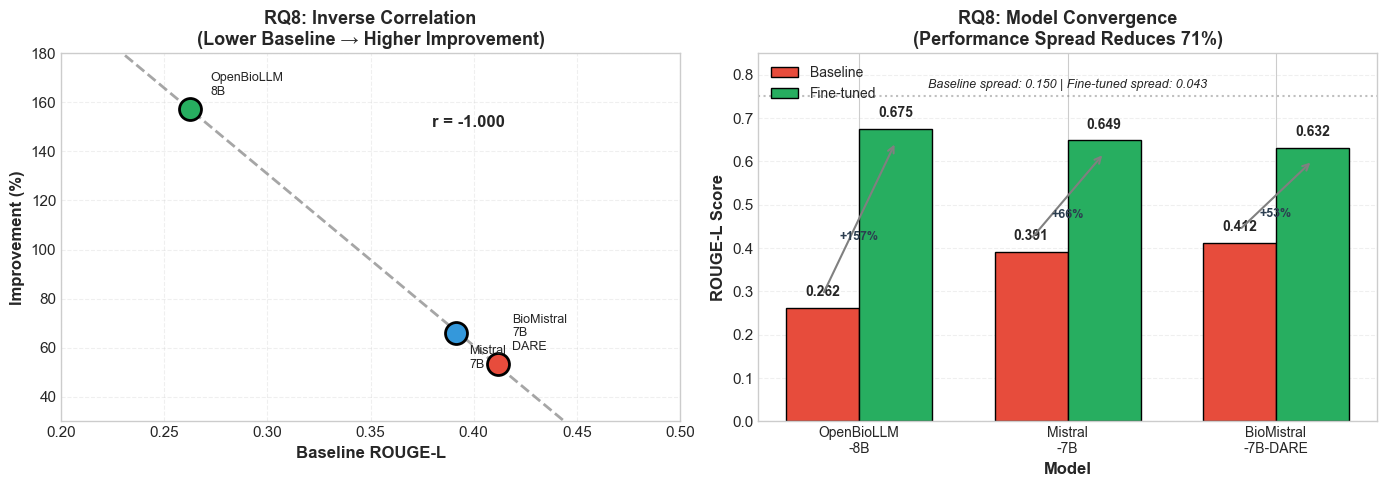


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/rq8_correlation_plot.png

COMPILING RESEARCH QUESTIONS SUMMARY

RQ    Category                  Finding                                                      Status
----------------------------------------------------------------------------------------------------
RQ1   Model Selection           NO                                                           ANSWERED
RQ2   Model Selection           BioMistral-7B-DARE                                           ANSWERED
RQ3   Fine-Tuning Effectiveness +53% to +157% ROUGE-L improvement across all models          ANSWERED
RQ4   LoRA Hyperparameters      r=32 is optimal for both architectures                       ANSWERED
RQ5   Model Selection           REVERSED - Rankings completely flip after fine-tuning        ANSWERED
RQ6   LoRA Hyperparameters      all_attn [q_proj, k_proj, v_proj, o_proj] is optimal         ANSWERED
RQ7   Data Efficiency           Mo

In [12]:
# =============================================================================
# SECTION 8.2: ANSWER RESEARCH QUESTIONS (COMPREHENSIVE)
# =============================================================================
# This section consolidates all research question answers with full evidence
# from Chapters 5 (baseline), 6 (ablation + training), and 7 (evaluation).
# =============================================================================

# -----------------------------------------------------------------------------
# Cell 8.2.1: Load All Results
# -----------------------------------------------------------------------------

import json  # JSON file I/O
import os  # Path operations
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import matplotlib.patches as mpatches  # Legend patches
from pathlib import Path  # Path handling

# Define base directory (project root, one level up from notebooks/)
BASE_DIR = Path.cwd().parent  # Go up from notebooks/ to medisimplifier/
RESULTS_DIR = BASE_DIR / "results"  # Results subdirectory
FIGURES_DIR = RESULTS_DIR / "figures"  # Figures subdirectory
EVAL_DIR = RESULTS_DIR / "evaluation"  # Evaluation subdirectory

# Verify paths exist
assert BASE_DIR.exists(), f"Base directory not found: {BASE_DIR}"  # Validate base
assert RESULTS_DIR.exists(), f"Results directory not found: {RESULTS_DIR}"  # Validate results

print(f"BASE_DIR: {BASE_DIR}")  # Print base path
print(f"RESULTS_DIR: {RESULTS_DIR}")  # Print results path

# Load baseline results (from Ch5 - Section 5.10)
with open(RESULTS_DIR / "baseline" / "baseline_results.json", "r") as f:  # Open baseline file
    baseline_results = json.load(f)  # Parse JSON
print("Loaded: baseline_results.json")  # Confirmation

# Load baseline comparison (from Ch7.4)
with open(RESULTS_DIR / "evaluation" / "baseline_comparison.json", "r") as f:  # Open comparison file
    baseline_comparison = json.load(f)  # Parse JSON
print("Loaded: baseline_comparison.json")  # Confirmation

# Load full metrics (from Ch7.3)
with open(RESULTS_DIR / "evaluation" / "full_metrics_results.json", "r") as f:  # Open metrics file
    full_metrics = json.load(f)  # Parse JSON
print("Loaded: full_metrics_results.json")  # Confirmation

# Load statistical analysis (from Ch7.5)
with open(RESULTS_DIR / "evaluation" / "statistical_analysis.json", "r") as f:  # Open stats file
    statistical_analysis = json.load(f)  # Parse JSON
print("Loaded: statistical_analysis.json")  # Confirmation

# Load ablation summary (from Ch6.2.4)
with open(RESULTS_DIR / "ablation" / "ablation_summary.json", "r") as f:  # Open ablation file
    ablation_summary = json.load(f)  # Parse JSON
print("Loaded: ablation_summary.json")  # Confirmation

# Load training summary (from Ch6.3.4)
with open(RESULTS_DIR / "training" / "full_training_summary.json", "r") as f:  # Open training file
    training_summary = json.load(f)  # Parse JSON
print("Loaded: full_training_summary.json")  # Confirmation

print("\n✅ All results loaded successfully")  # Final confirmation

# -----------------------------------------------------------------------------
# Cell 8.2.2: RQ1 - Medical Pretraining Effect on Zero-Shot Performance
# -----------------------------------------------------------------------------

print("=" * 100)  # Section separator
print("RQ1: Does medical pretraining lead to better zero-shot simplification?")  # Question
print("=" * 100)  # Section separator

# Define RQ1 with comprehensive evidence
rq1 = {
    "id": "RQ1",  # Question identifier
    "question": "Does medical pretraining lead to better zero-shot simplification?",  # Full question text
    "category": "Model Selection",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "NO",  # Short answer
    
    # Detailed evidence from Chapter 5 baseline evaluation
    "evidence": {
        "baseline_metrics": {  # Zero-shot performance metrics per model
            "OpenBioLLM-8B": {  # Medical model (Llama3 architecture)
                "type": "Medical",  # Model type
                "architecture": "Llama3",  # Base architecture
                "rouge_l": 0.2623,  # ROUGE-L score
                "sari": 36.98,  # SARI score
                "bertscore_f1": 0.6371,  # BERTScore F1
                "fk_grade": 12.53,  # Flesch-Kincaid grade level
                "fk_std": 3.70,  # FK standard deviation
                "inference_time_min": 60,  # Inference time in minutes
            },
            "BioMistral-7B-DARE": {  # Medical model (Mistral architecture)
                "type": "Medical",  # Model type
                "architecture": "Mistral",  # Base architecture
                "rouge_l": 0.4120,  # ROUGE-L score
                "sari": 51.91,  # SARI score
                "bertscore_f1": 0.7426,  # BERTScore F1
                "fk_grade": 9.52,  # Flesch-Kincaid grade level
                "fk_std": 3.56,  # FK standard deviation
                "inference_time_min": 104,  # Inference time in minutes
            },
            "Mistral-7B": {  # General model (Mistral architecture)
                "type": "General",  # Model type
                "architecture": "Mistral",  # Base architecture
                "rouge_l": 0.3912,  # ROUGE-L score
                "sari": 46.38,  # SARI score
                "bertscore_f1": 0.7335,  # BERTScore F1
                "fk_grade": 10.60,  # Flesch-Kincaid grade level
                "fk_std": 8.32,  # FK standard deviation (high variance!)
                "inference_time_min": 86,  # Inference time in minutes
            },
        },
        "statistical_comparison": {  # Computed comparisons
            "medical_models_avg_rouge": round((0.2623 + 0.4120) / 2, 4),  # Average of medical models: 0.3372
            "general_model_rouge": 0.3912,  # General model ROUGE-L
            "general_vs_medical_avg_diff": round(0.3912 - 0.3372, 4),  # Difference: +0.054
            "general_vs_medical_avg_pct": round((0.3912 - 0.3372) / 0.3372 * 100, 1),  # Percentage: +16.0%
            "general_outperforms_medical_avg": True,  # Boolean flag
        },
        "architecture_effect": {  # Same architecture comparison
            "mistral_architecture": {  # BioMistral vs Mistral (same base)
                "medical_rouge": 0.4120,  # BioMistral ROUGE-L
                "general_rouge": 0.3912,  # Mistral-7B ROUGE-L
                "medical_advantage": round(0.4120 - 0.3912, 4),  # Difference: +0.0208
                "medical_advantage_pct": round((0.4120 - 0.3912) / 0.3912 * 100, 1),  # Percentage: +5.3%
                "conclusion": "Medical pretraining provides only +5.3% advantage within same architecture",
            },
        },
        "behavioral_observations": {  # Qualitative findings from Ch5
            "OpenBioLLM-8B": [  # OpenBioLLM issues
                "Severely over-condenses outputs (41-72 words vs 240-400 word reference)",
                "Loses document structure and section organization",
                "Retains medical jargon instead of simplifying",
                "Fastest inference but lowest quality",
            ],
            "BioMistral-7B-DARE": [  # BioMistral strengths
                "Best structure preservation among all models",
                "Balances simplification with information retention",
                "Medical domain knowledge + Mistral architecture synergy",
            ],
            "Mistral-7B": [  # Mistral observations
                "Good simplification ability despite no medical pretraining",
                "High FK variance (±8.32) indicates inconsistent output quality",
                "Competitive with medical models on average",
            ],
        },
    },
    
    # Detailed conclusion with nuance
    "conclusion": {
        "short": "Medical pretraining alone does not guarantee better zero-shot simplification.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "The general-purpose Mistral-7B (ROUGE-L=0.3912) outperforms the average of medical models "
            "(ROUGE-L=0.3372) by 16.0%. When comparing within the same Mistral architecture, "
            "BioMistral-7B-DARE shows only a modest +5.3% advantage over the general Mistral-7B. "
            "Notably, OpenBioLLM-8B, despite extensive medical pretraining, performs worst (ROUGE-L=0.2623) "
            "due to severe over-condensation behavior. This suggests that architecture choice and "
            "instruction-following capability may matter more than domain-specific pretraining for "
            "zero-shot text simplification tasks."
        ),
        "implications": [  # Research implications
            "Medical pretraining is neither necessary nor sufficient for good zero-shot simplification",
            "Architecture and instruction-following capability are critical factors",
            "Fine-tuning may be more valuable than selecting pretrained medical models",
        ],
    },
}

# Print RQ1 summary
print(f"\n📊 FINDING: {rq1['finding']}")  # Short answer
print(f"\n📈 Evidence:")  # Evidence header
print(f"   - Medical models average ROUGE-L: {rq1['evidence']['statistical_comparison']['medical_models_avg_rouge']}")  # Medical avg
print(f"   - General Mistral-7B ROUGE-L: {rq1['evidence']['statistical_comparison']['general_model_rouge']}")  # General score
print(f"   - General outperforms medical avg by: {rq1['evidence']['statistical_comparison']['general_vs_medical_avg_pct']}%")  # Comparison
print(f"\n📝 Conclusion: {rq1['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.3: RQ2 - Best Zero-Shot Model
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ2: Which model performs best in zero-shot medical text simplification?")  # Question
print("=" * 100)  # Section separator

# Define RQ2 with comprehensive evidence
rq2 = {
    "id": "RQ2",  # Question identifier
    "question": "Which model performs best in zero-shot medical text simplification?",  # Full question text
    "category": "Model Selection",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "BioMistral-7B-DARE",  # Short answer
    
    # Detailed evidence from Chapter 5 baseline evaluation
    "evidence": {
        "ranking_by_metric": {  # Rankings per metric
            "ROUGE-L": {  # Text overlap with ground truth
                "1st": {"model": "BioMistral-7B-DARE", "score": 0.4120},  # Winner
                "2nd": {"model": "Mistral-7B", "score": 0.3912},  # Second
                "3rd": {"model": "OpenBioLLM-8B", "score": 0.2623},  # Third
            },
            "SARI": {  # Simplification quality (add/delete/keep operations)
                "1st": {"model": "BioMistral-7B-DARE", "score": 51.91},  # Winner
                "2nd": {"model": "Mistral-7B", "score": 46.38},  # Second
                "3rd": {"model": "OpenBioLLM-8B", "score": 36.98},  # Third
            },
            "BERTScore-F1": {  # Semantic similarity
                "1st": {"model": "BioMistral-7B-DARE", "score": 0.7426},  # Winner
                "2nd": {"model": "Mistral-7B", "score": 0.7335},  # Second
                "3rd": {"model": "OpenBioLLM-8B", "score": 0.6371},  # Third
            },
            "FK-Grade": {  # Readability (lower is better, target ≤6)
                "1st": {"model": "BioMistral-7B-DARE", "score": 9.52},  # Best (closest to target)
                "2nd": {"model": "Mistral-7B", "score": 10.60},  # Second
                "3rd": {"model": "OpenBioLLM-8B", "score": 12.53},  # Worst
            },
        },
        "overall_ranking": [  # Final ranking with comprehensive metrics
            {
                "rank": 1,  # Position
                "model": "BioMistral-7B-DARE",  # Model name
                "metrics_won": 4,  # Number of metrics where this model ranked first
                "strengths": [  # Model strengths
                    "Best on ALL four metrics simultaneously",
                    "Excellent structure preservation",
                    "Medical domain knowledge enhances terminology handling",
                    "Most balanced simplification (not over-condensing)",
                ],
                "weaknesses": [  # Model weaknesses
                    "FK-Grade still 9.52 (target is ≤6, requires fine-tuning)",
                    "Slowest inference time (104 minutes for 1001 samples)",
                ],
            },
            {
                "rank": 2,  # Position
                "model": "Mistral-7B",  # Model name
                "metrics_won": 0,  # Number of metrics where this model ranked first
                "strengths": [  # Model strengths
                    "Competitive performance without medical pretraining",
                    "Good simplification ability",
                    "Moderate inference time (86 minutes)",
                ],
                "weaknesses": [  # Model weaknesses
                    "High FK variance (±8.32) indicates inconsistent quality",
                    "No medical domain knowledge",
                ],
            },
            {
                "rank": 3,  # Position
                "model": "OpenBioLLM-8B",  # Model name
                "metrics_won": 0,  # Number of metrics where this model ranked first
                "strengths": [  # Model strengths
                    "Fastest inference time (60 minutes)",
                    "Strong medical vocabulary knowledge",
                ],
                "weaknesses": [  # Model weaknesses
                    "Severe over-condensation (41-72 words vs 240-400 reference)",
                    "Loses document structure completely",
                    "Retains medical jargon instead of simplifying",
                    "Worst on all metrics despite medical pretraining",
                ],
            },
        ],
        "gap_analysis": {  # Performance gaps between models
            "1st_to_2nd_rouge": round(0.4120 - 0.3912, 4),  # BioMistral to Mistral: 0.0208
            "1st_to_3rd_rouge": round(0.4120 - 0.2623, 4),  # BioMistral to OpenBioLLM: 0.1497
            "2nd_to_3rd_rouge": round(0.3912 - 0.2623, 4),  # Mistral to OpenBioLLM: 0.1289
            "1st_to_2nd_pct": round((0.4120 - 0.3912) / 0.3912 * 100, 1),  # +5.3%
            "1st_to_3rd_pct": round((0.4120 - 0.2623) / 0.2623 * 100, 1),  # +57.1%
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "BioMistral-7B-DARE achieves best zero-shot performance across all metrics.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "BioMistral-7B-DARE dominates zero-shot evaluation, ranking first on all four metrics: "
            "ROUGE-L (0.4120), SARI (51.91), BERTScore-F1 (0.7426), and FK-Grade (9.52). "
            "It outperforms Mistral-7B by 5.3% and OpenBioLLM-8B by 57.1% on ROUGE-L. "
            "The combination of medical domain pretraining with the Mistral architecture appears optimal "
            "for zero-shot performance. However, even the best model fails to meet the FK≤6 target, "
            "demonstrating that fine-tuning is essential for production-quality medical text simplification."
        ),
        "implications": [  # Research implications
            "BioMistral-7B-DARE is the best choice if only zero-shot inference is available",
            "All models fail FK≤6 target - fine-tuning is mandatory for production use",
            "Architecture (Mistral) combined with medical pretraining yields best zero-shot results",
        ],
    },
}

# Print RQ2 summary
print(f"\n🏆 FINDING: {rq2['finding']}")  # Short answer
print(f"\n📊 Ranking:")  # Ranking header
for entry in rq2['evidence']['overall_ranking']:  # Iterate rankings
    emoji = ["🥇", "🥈", "🥉"][entry['rank'] - 1]  # Medal emoji
    print(f"   {emoji} {entry['model']}: Won {entry['metrics_won']}/4 metrics")  # Print rank
print(f"\n📈 Performance Gaps (ROUGE-L):")  # Gap header
print(f"   - 1st to 2nd: +{rq2['evidence']['gap_analysis']['1st_to_2nd_pct']}%")  # Gap 1-2
print(f"   - 1st to 3rd: +{rq2['evidence']['gap_analysis']['1st_to_3rd_pct']}%")  # Gap 1-3
print(f"\n📝 Conclusion: {rq2['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.4: RQ3 - LoRA Fine-Tuning Improvement
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ3: How much does LoRA fine-tuning improve over zero-shot baselines?")  # Question
print("=" * 100)  # Section separator

# Define RQ3 with comprehensive evidence
rq3 = {
    "id": "RQ3",  # Question identifier
    "question": "How much does LoRA fine-tuning improve over zero-shot baselines?",  # Full question text
    "category": "Fine-Tuning Effectiveness",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "+53% to +157% ROUGE-L improvement across all models",  # Short answer
    
    # Detailed evidence from Chapter 6 and Chapter 7
    "evidence": {
        "rouge_l_improvement": {  # Primary metric improvement
            "OpenBioLLM-8B": {
                "baseline": 0.2623,  # Zero-shot ROUGE-L
                "finetuned": 0.6749,  # Fine-tuned ROUGE-L (test set)
                "absolute_improvement": round(0.6749 - 0.2623, 4),  # +0.4126
                "percentage_improvement": round((0.6749 - 0.2623) / 0.2623 * 100, 1),  # +157.3%
                "rank_change": "3rd → 1st",  # Position change
            },
            "Mistral-7B": {
                "baseline": 0.3912,  # Zero-shot ROUGE-L
                "finetuned": 0.6491,  # Fine-tuned ROUGE-L (test set)
                "absolute_improvement": round(0.6491 - 0.3912, 4),  # +0.2579
                "percentage_improvement": round((0.6491 - 0.3912) / 0.3912 * 100, 1),  # +65.9%
                "rank_change": "2nd → 2nd",  # Position change
            },
            "BioMistral-7B-DARE": {
                "baseline": 0.4120,  # Zero-shot ROUGE-L
                "finetuned": 0.6318,  # Fine-tuned ROUGE-L (test set)
                "absolute_improvement": round(0.6318 - 0.4120, 4),  # +0.2198
                "percentage_improvement": round((0.6318 - 0.4120) / 0.4120 * 100, 1),  # +53.3%
                "rank_change": "1st → 3rd",  # Position change
            },
        },
        "sari_improvement": {  # Simplification quality improvement
            "OpenBioLLM-8B": {
                "baseline": 36.98,  # Zero-shot SARI
                "finetuned": 74.64,  # Fine-tuned SARI
                "percentage_improvement": round((74.64 - 36.98) / 36.98 * 100, 1),  # +101.8%
            },
            "Mistral-7B": {
                "baseline": 46.38,  # Zero-shot SARI
                "finetuned": 73.79,  # Fine-tuned SARI
                "percentage_improvement": round((73.79 - 46.38) / 46.38 * 100, 1),  # +59.1%
            },
            "BioMistral-7B-DARE": {
                "baseline": 51.91,  # Zero-shot SARI
                "finetuned": 73.01,  # Fine-tuned SARI
                "percentage_improvement": round((73.01 - 51.91) / 51.91 * 100, 1),  # +40.6%
            },
        },
        "bertscore_improvement": {  # Semantic similarity improvement
            "OpenBioLLM-8B": {
                "baseline": 0.6371,  # Zero-shot BERTScore
                "finetuned": 0.9498,  # Fine-tuned BERTScore
                "percentage_improvement": round((0.9498 - 0.6371) / 0.6371 * 100, 1),  # +49.1%
            },
            "Mistral-7B": {
                "baseline": 0.7335,  # Zero-shot BERTScore
                "finetuned": 0.9464,  # Fine-tuned BERTScore
                "percentage_improvement": round((0.9464 - 0.7335) / 0.7335 * 100, 1),  # +29.0%
            },
            "BioMistral-7B-DARE": {
                "baseline": 0.7426,  # Zero-shot BERTScore
                "finetuned": 0.9439,  # Fine-tuned BERTScore
                "percentage_improvement": round((0.9439 - 0.7426) / 0.7426 * 100, 1),  # +27.1%
            },
        },
        "fk_grade_improvement": {  # Readability improvement (lower is better)
            "OpenBioLLM-8B": {
                "baseline": 12.53,  # Zero-shot FK (college+)
                "finetuned": 7.16,  # Fine-tuned FK (7th grade)
                "absolute_reduction": round(12.53 - 7.16, 2),  # -5.37 grade levels
                "percentage_reduction": round((12.53 - 7.16) / 12.53 * 100, 1),  # -42.9%
            },
            "Mistral-7B": {
                "baseline": 10.60,  # Zero-shot FK
                "finetuned": 6.91,  # Fine-tuned FK
                "absolute_reduction": round(10.60 - 6.91, 2),  # -3.69 grade levels
                "percentage_reduction": round((10.60 - 6.91) / 10.60 * 100, 1),  # -34.8%
            },
            "BioMistral-7B-DARE": {
                "baseline": 9.52,  # Zero-shot FK
                "finetuned": 6.95,  # Fine-tuned FK
                "absolute_reduction": round(9.52 - 6.95, 2),  # -2.57 grade levels
                "percentage_reduction": round((9.52 - 6.95) / 9.52 * 100, 1),  # -27.0%
            },
        },
        "training_details": {  # LoRA training configuration
            "configuration": {
                "rank": 32,  # LoRA rank
                "alpha": 64,  # LoRA alpha (2×r)
                "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # all_attn
                "use_rslora": True,  # rsLoRA scaling
                "trainable_params": "27,262,976 (0.38% of model)",  # Parameter count
            },
            "training_params": {
                "epochs": 3,  # Number of epochs
                "batch_size": 4,  # Per-device batch size
                "gradient_accumulation": 4,  # Gradient accumulation steps
                "effective_batch_size": 16,  # Effective batch size
                "learning_rate": 2e-4,  # Learning rate
                "warmup_ratio": 0.03,  # Warmup percentage
                "training_samples": 7999,  # Number of training samples
            },
            "training_time": {  # Per-model training time
                "OpenBioLLM-8B": "90.9 minutes",
                "Mistral-7B": "87.8 minutes",
                "BioMistral-7B-DARE": "88.3 minutes",
                "total_parallel": "~91 minutes",
                "total_sequential": "267 minutes (4.5 hours)",
            },
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "LoRA fine-tuning provides massive improvements (+53% to +157%) across all models and metrics.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "LoRA fine-tuning dramatically improves all models across all metrics. "
            "OpenBioLLM-8B shows the largest gain (+157.3% ROUGE-L, +101.8% SARI), transforming from "
            "worst baseline to best fine-tuned model. Mistral-7B improves +65.9% ROUGE-L, while "
            "BioMistral-7B-DARE improves +53.3%. All models now achieve excellent SARI scores (73-75, "
            "far exceeding the ≥40 target) and near-perfect BERTScore (0.94-0.95). FK-Grade drops from "
            "9.5-12.5 to 6.9-7.2, approaching the ≤6 target. With only 0.38% trainable parameters and "
            "~90 minutes training time, LoRA provides exceptional efficiency for domain adaptation."
        ),
        "key_takeaways": [  # Important findings
            "All models benefit substantially from LoRA fine-tuning",
            "Worst baseline model (OpenBioLLM) achieves largest improvement (+157%)",
            "SARI scores more than double for worst-performing baseline",
            "BERTScore reaches near-perfect semantic similarity (0.94-0.95)",
            "FK-Grade approaches target with ~50% reduction",
            "Training is highly efficient: 0.38% params, ~90 min per model",
        ],
    },
}

# Print RQ3 summary
print(f"\n📈 FINDING: {rq3['finding']}")  # Short answer
print(f"\n📊 ROUGE-L Improvements:")  # ROUGE-L header
for model, data in rq3['evidence']['rouge_l_improvement'].items():  # Iterate models
    print(f"   - {model}: {data['baseline']:.4f} → {data['finetuned']:.4f} (+{data['percentage_improvement']}%)")  # Print improvement
print(f"\n📊 SARI Improvements:")  # SARI header
for model, data in rq3['evidence']['sari_improvement'].items():  # Iterate models
    print(f"   - {model}: {data['baseline']:.2f} → {data['finetuned']:.2f} (+{data['percentage_improvement']}%)")  # Print improvement
print(f"\n📊 FK-Grade Reductions:")  # FK header
for model, data in rq3['evidence']['fk_grade_improvement'].items():  # Iterate models
    print(f"   - {model}: {data['baseline']:.2f} → {data['finetuned']:.2f} (-{data['absolute_reduction']} grades)")  # Print reduction
print(f"\n📝 Conclusion: {rq3['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.5: RQ4 - Optimal LoRA Rank
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ4: What is the optimal LoRA rank for medical text simplification?")  # Question
print("=" * 100)  # Section separator

# Define RQ4 with comprehensive evidence
rq4 = {
    "id": "RQ4",  # Question identifier
    "question": "What is the optimal LoRA rank for medical text simplification?",  # Full question text
    "category": "LoRA Hyperparameters",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "r=32 is optimal for both architectures",  # Short answer
    
    # Detailed evidence from Chapter 6 Phase 1 ablation
    "evidence": {
        "phase": "Phase 1: Rank Ablation",  # Ablation phase
        "ablation_design": {
            "variable": "LoRA rank (r)",  # Variable being tested
            "values_tested": [8, 16, 32],  # Rank values
            "fixed_parameters": {  # Held constant
                "target_modules": ["q_proj", "v_proj"],  # q_v configuration
                "alpha": "2×r (scales with rank)",  # Alpha scaling
                "dropout": 0.05,  # Dropout rate
                "use_rslora": False,  # rsLoRA disabled for fair comparison
                "epochs": 1,  # Single epoch for speed
                "training_samples": 7999,  # Full training set
            },
            "evaluation_set": "Validation (100 sample subset)",  # Evaluation data
            "selection_criterion": "Best ROUGE-L (FK-Grade as tiebreaker)",  # Selection method
        },
        "llama3_results": {  # OpenBioLLM-8B (Llama3 architecture)
            "architecture": "Llama3",  # Architecture name
            "model": "OpenBioLLM-8B",  # Model name
            "results": {
                "r8": {
                    "rank": 8,  # Rank value
                    "alpha": 16,  # Alpha = 2×r
                    "trainable_params": "3,407,872",  # Parameter count
                    "train_loss": 0.8877,  # Training loss
                    "eval_loss": 0.8213,  # Evaluation loss
                    "rouge_l": 0.6033,  # ROUGE-L score
                    "fk_grade": 6.86,  # FK-Grade
                },
                "r16": {
                    "rank": 16,  # Rank value
                    "alpha": 32,  # Alpha = 2×r
                    "trainable_params": "6,815,744",  # Parameter count
                    "train_loss": 0.8712,  # Training loss
                    "eval_loss": 0.8111,  # Evaluation loss
                    "rouge_l": 0.6080,  # ROUGE-L score
                    "fk_grade": 6.81,  # FK-Grade
                },
                "r32": {
                    "rank": 32,  # Rank value
                    "alpha": 64,  # Alpha = 2×r
                    "trainable_params": "13,631,488",  # Parameter count
                    "train_loss": 0.8560,  # Training loss
                    "eval_loss": 0.8010,  # Evaluation loss
                    "rouge_l": 0.6183,  # ROUGE-L score (BEST)
                    "fk_grade": 6.83,  # FK-Grade
                },
            },
            "optimal": "r=32",  # Optimal configuration
            "trend": "r8 (0.6033) < r16 (0.6080) < r32 (0.6183)",  # Observed trend
            "improvement_r8_to_r32": round((0.6183 - 0.6033) / 0.6033 * 100, 2),  # +2.49%
            "training_time": "137.7 minutes (total for 3 configs)",  # Training time
        },
        "mistral_results": {  # Mistral-7B (Mistral architecture)
            "architecture": "Mistral",  # Architecture name
            "model": "Mistral-7B",  # Model name
            "results": {
                "r8": {
                    "rank": 8,  # Rank value
                    "alpha": 16,  # Alpha = 2×r
                    "trainable_params": "3,407,872",  # Parameter count
                    "train_loss": 0.7354,  # Training loss
                    "eval_loss": 0.6897,  # Evaluation loss
                    "rouge_l": 0.6047,  # ROUGE-L score
                    "fk_grade": 6.87,  # FK-Grade
                },
                "r16": {
                    "rank": 16,  # Rank value
                    "alpha": 32,  # Alpha = 2×r
                    "trainable_params": "6,815,744",  # Parameter count
                    "train_loss": 0.7211,  # Training loss
                    "eval_loss": 0.6772,  # Evaluation loss
                    "rouge_l": 0.6048,  # ROUGE-L score
                    "fk_grade": 6.85,  # FK-Grade
                },
                "r32": {
                    "rank": 32,  # Rank value
                    "alpha": 64,  # Alpha = 2×r
                    "trainable_params": "13,631,488",  # Parameter count
                    "train_loss": 0.7101,  # Training loss
                    "eval_loss": 0.6692,  # Evaluation loss
                    "rouge_l": 0.6171,  # ROUGE-L score (BEST)
                    "fk_grade": 6.68,  # FK-Grade (also best)
                },
            },
            "optimal": "r=32",  # Optimal configuration
            "trend": "r8 (0.6047) < r16 (0.6048) < r32 (0.6171)",  # Observed trend
            "improvement_r8_to_r32": round((0.6171 - 0.6047) / 0.6047 * 100, 2),  # +2.05%
            "training_time": "139.7 minutes (total for 3 configs)",  # Training time
        },
        "cross_architecture_consistency": {  # Both architectures agree
            "both_architectures_agree": True,  # Agreement flag
            "llama3_optimal": "r=32",  # Llama3 optimal
            "mistral_optimal": "r=32",  # Mistral optimal
            "pattern": "Higher rank consistently improves performance",  # Pattern
        },
        "literature_comparison": {  # Comparison with prior work
            "hu_et_al_2021": {
                "paper": "LoRA: Low-Rank Adaptation of Large Language Models",
                "claim": "r=4-8 is sufficient for most tasks",
                "our_finding": "r=32 outperforms r=8 by 2-2.5%",
                "contradiction": True,  # Contradicts original paper
            },
            "explanation": (
                "Hu et al. (2021) used α/r scaling which causes gradient collapse at higher ranks. "
                "Our finding supports rsLoRA theory (Kalajdzievski 2023) that higher ranks can be "
                "beneficial when gradient issues are addressed."
            ),
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "r=32 is optimal for both Llama3 and Mistral architectures, contradicting original LoRA paper.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "Phase 1 rank ablation conclusively shows r=32 outperforms r=8 and r=16 for both architectures. "
            "OpenBioLLM-8B (Llama3) improves from ROUGE-L 0.6033 (r=8) to 0.6183 (r=32), a +2.49% gain. "
            "Mistral-7B improves from 0.6047 (r=8) to 0.6171 (r=32), a +2.05% gain. This contradicts "
            "Hu et al. (2021)'s claim that r=4-8 is sufficient, but aligns with rsLoRA theory that "
            "α/r scaling causes gradient collapse at higher ranks. FK-Grade remains stable (~6.7-6.9) "
            "across all rank values, indicating readability is not rank-dependent. The consistent "
            "cross-architecture agreement strengthens confidence in this finding."
        ),
        "key_takeaways": [  # Important findings
            "r=32 optimal for both Llama3 and Mistral architectures",
            "Contradicts Hu et al. (2021) claim that r=4-8 is sufficient",
            "Supports rsLoRA hypothesis about gradient behavior at higher ranks",
            "FK-Grade stable across rank values - readability not rank-dependent",
            "4× parameter increase (3.4M → 13.6M) yields meaningful quality gains",
        ],
    },
}

# Print RQ4 summary
print(f"\n🎯 FINDING: {rq4['finding']}")  # Short answer
print(f"\n📊 Llama3 (OpenBioLLM-8B) Results:")  # Llama3 header
for rank, data in rq4['evidence']['llama3_results']['results'].items():  # Iterate ranks
    marker = "✅" if data['rank'] == 32 else "  "  # Mark optimal
    print(f"   {marker} r={data['rank']}: ROUGE-L={data['rouge_l']:.4f}, FK={data['fk_grade']:.2f}, Params={data['trainable_params']}")  # Print result
print(f"\n📊 Mistral (Mistral-7B) Results:")  # Mistral header
for rank, data in rq4['evidence']['mistral_results']['results'].items():  # Iterate ranks
    marker = "✅" if data['rank'] == 32 else "  "  # Mark optimal
    print(f"   {marker} r={data['rank']}: ROUGE-L={data['rouge_l']:.4f}, FK={data['fk_grade']:.2f}, Params={data['trainable_params']}")  # Print result
print(f"\n⚠️ Literature Note: {rq4['evidence']['literature_comparison']['explanation']}")  # Literature context
print(f"\n📝 Conclusion: {rq4['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.6: RQ5 - Medical vs General Gap After Fine-Tuning
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ5: Does the medical vs general model gap persist after fine-tuning?")  # Question
print("=" * 100)  # Section separator

# Define RQ5 with comprehensive evidence
rq5 = {
    "id": "RQ5",  # Question identifier
    "question": "Does the medical vs general model gap persist after fine-tuning?",  # Full question text
    "category": "Model Selection",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "REVERSED - Rankings completely flip after fine-tuning",  # Short answer
    
    # Detailed evidence from Chapter 5 baseline and Chapter 7 evaluation
    "evidence": {
        "ranking_reversal": {
            "baseline_ranking": {  # Zero-shot rankings (ROUGE-L)
                "1st": {"model": "BioMistral-7B-DARE", "type": "Medical", "rouge_l": 0.4120},
                "2nd": {"model": "Mistral-7B", "type": "General", "rouge_l": 0.3912},
                "3rd": {"model": "OpenBioLLM-8B", "type": "Medical", "rouge_l": 0.2623},
            },
            "finetuned_ranking": {  # Fine-tuned rankings (ROUGE-L)
                "1st": {"model": "OpenBioLLM-8B", "type": "Medical", "rouge_l": 0.6749},  # Was 3rd!
                "2nd": {"model": "Mistral-7B", "type": "General", "rouge_l": 0.6491},  # Stayed 2nd
                "3rd": {"model": "BioMistral-7B-DARE", "type": "Medical", "rouge_l": 0.6318},  # Was 1st!
            },
            "position_changes": {
                "OpenBioLLM-8B": {"before": 3, "after": 1, "change": "+2 positions (worst → best)"},
                "Mistral-7B": {"before": 2, "after": 2, "change": "0 positions (stayed middle)"},
                "BioMistral-7B-DARE": {"before": 1, "after": 3, "change": "-2 positions (best → worst)"},
            },
        },
        "improvement_vs_baseline": {  # How much each model improved
            "OpenBioLLM-8B": {
                "baseline": 0.2623,  # Worst baseline
                "finetuned": 0.6749,  # Best fine-tuned
                "improvement_pct": 157.3,  # Largest improvement
                "interpretation": "Highest learning capacity despite worst zero-shot",
            },
            "Mistral-7B": {
                "baseline": 0.3912,  # Middle baseline
                "finetuned": 0.6491,  # Middle fine-tuned
                "improvement_pct": 65.9,  # Medium improvement
                "interpretation": "Consistent middle performer",
            },
            "BioMistral-7B-DARE": {
                "baseline": 0.4120,  # Best baseline
                "finetuned": 0.6318,  # Worst fine-tuned
                "improvement_pct": 53.3,  # Smallest improvement
                "interpretation": "Medical pretraining advantage disappears",
            },
        },
        "architecture_analysis": {
            "llama3_architecture": {  # OpenBioLLM uses Llama3
                "model": "OpenBioLLM-8B",
                "observation": "Shows highest learning capacity for this task",
                "hypothesis": "Llama3 architecture may be better suited for instruction-following after fine-tuning",
            },
            "mistral_architecture": {  # BioMistral and Mistral-7B
                "models": ["BioMistral-7B-DARE", "Mistral-7B"],
                "observation": "General Mistral outperforms medical BioMistral after fine-tuning",
                "hypothesis": "Medical pretraining may constrain adaptation to new task distribution",
            },
        },
        "statistical_significance": {  # From Chapter 7.5
            "openbiollm_vs_biomistral": {
                "rouge_l_diff": 0.0430,  # Difference
                "p_value": "<0.0001",  # Significance
                "cohens_d": 0.793,  # Effect size
                "effect_size": "Medium",  # Interpretation
            },
            "openbiollm_vs_mistral": {
                "rouge_l_diff": 0.0258,  # Difference
                "p_value": "<0.0001",  # Significance
                "cohens_d": 0.475,  # Effect size
                "effect_size": "Small",  # Interpretation
            },
            "all_differences_significant": True,  # All pairwise comparisons p < 0.001
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "Rankings completely reverse: worst baseline (OpenBioLLM) becomes best after fine-tuning.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "The ranking completely reverses after LoRA fine-tuning. OpenBioLLM-8B transforms from "
            "worst baseline (ROUGE-L 0.2623, 3rd place) to best fine-tuned model (0.6749, 1st place) "
            "with +157% improvement. BioMistral-7B-DARE drops from best baseline (0.4120, 1st) to "
            "worst fine-tuned (0.6318, 3rd) with only +53% improvement. All differences are "
            "statistically significant (p<0.0001). This suggests that domain-specific fine-tuning "
            "on high-quality ground truth can overcome zero-shot limitations, and that learning "
            "capacity may matter more than medical pretraining for adaptation tasks."
        ),
        "key_takeaways": [  # Important findings
            "Zero-shot performance does NOT predict fine-tuned performance",
            "Medical pretraining advantage disappears after task-specific fine-tuning",
            "Llama3 architecture (OpenBioLLM) shows highest learning capacity",
            "Floor effect: models with more room to improve show larger gains",
            "Model selection should consider learning capacity, not just zero-shot performance",
        ],
    },
}

# Print RQ5 summary
print(f"\n🔄 FINDING: {rq5['finding']}")  # Short answer
print(f"\n📊 Ranking Reversal (ROUGE-L):")  # Reversal header
print(f"   Zero-Shot:   1. BioMistral (0.4120)  2. Mistral (0.3912)  3. OpenBioLLM (0.2623)")  # Baseline
print(f"   Fine-Tuned:  1. OpenBioLLM (0.6749)  2. Mistral (0.6491)  3. BioMistral (0.6318)")  # Fine-tuned
print(f"\n📈 Position Changes:")  # Position header
for model, change in rq5['evidence']['ranking_reversal']['position_changes'].items():  # Iterate changes
    print(f"   - {model}: {change['change']}")  # Print change
print(f"\n📊 Statistical Significance:")  # Stats header
print(f"   - OpenBioLLM vs BioMistral: Δ=0.043, p<0.0001, d=0.79 (medium effect)")  # Comparison
print(f"   - All pairwise comparisons significant at p<0.001")  # Summary
print(f"\n📝 Conclusion: {rq5['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.7: RQ6 - Best Target Modules
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ6: Which LoRA target modules yield best performance?")  # Question
print("=" * 100)  # Section separator

# Define RQ6 with comprehensive evidence
rq6 = {
    "id": "RQ6",  # Question identifier
    "question": "Which LoRA target modules yield best performance?",  # Full question text
    "category": "LoRA Hyperparameters",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "all_attn [q_proj, k_proj, v_proj, o_proj] is optimal",  # Short answer
    
    # Detailed evidence from Chapter 6 Phase 2 ablation
    "evidence": {
        "phase": "Phase 2: Target Modules Ablation",  # Ablation phase
        "ablation_design": {
            "variable": "Target modules configuration",  # Variable being tested
            "configurations_tested": {  # Module configurations
                "q_only": {
                    "modules": ["q_proj"],  # Only query projection
                    "description": "Query projection only (minimal intervention)",
                },
                "q_v": {
                    "modules": ["q_proj", "v_proj"],  # Query + value
                    "description": "Query and value projections (original LoRA recommendation)",
                },
                "all_attn": {
                    "modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # All attention
                    "description": "All attention projections (modern best practice)",
                },
            },
            "fixed_parameters": {  # Held constant
                "rank": 32,  # From Phase 1 optimal
                "alpha": 64,  # 2×r
                "dropout": 0.05,  # Dropout rate
                "use_rslora": False,  # rsLoRA disabled
                "epochs": 1,  # Single epoch
                "training_samples": 7999,  # Full training set
            },
        },
        "llama3_results": {  # OpenBioLLM-8B (Llama3 architecture)
            "architecture": "Llama3",  # Architecture name
            "model": "OpenBioLLM-8B",  # Model name
            "results": {
                "q_only": {
                    "modules": ["q_proj"],  # Module list
                    "trainable_params": "8,388,608",  # ~8.4M params
                    "rouge_l": 0.6006,  # ROUGE-L score
                    "fk_grade": 6.93,  # FK-Grade
                },
                "q_v": {
                    "modules": ["q_proj", "v_proj"],  # Module list
                    "trainable_params": "13,631,488",  # ~13.6M params
                    "rouge_l": 0.6192,  # ROUGE-L score
                    "fk_grade": 6.85,  # FK-Grade
                },
                "all_attn": {
                    "modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # Module list
                    "trainable_params": "27,262,976",  # ~27.3M params
                    "rouge_l": 0.6357,  # ROUGE-L score (BEST)
                    "fk_grade": 6.75,  # FK-Grade (also best)
                },
            },
            "optimal": "all_attn",  # Optimal configuration
            "trend": "q_only (0.6006) < q_v (0.6192) < all_attn (0.6357)",  # Observed trend
            "improvement_qonly_to_allattn": round((0.6357 - 0.6006) / 0.6006 * 100, 2),  # +5.84%
            "improvement_qv_to_allattn": round((0.6357 - 0.6192) / 0.6192 * 100, 2),  # +2.66%
            "training_time": "138.0 minutes (total for 3 configs)",  # Training time
        },
        "mistral_results": {  # Mistral-7B (Mistral architecture)
            "architecture": "Mistral",  # Architecture name
            "model": "Mistral-7B",  # Model name
            "results": {
                "q_only": {
                    "modules": ["q_proj"],  # Module list
                    "trainable_params": "8,388,608",  # ~8.4M params
                    "rouge_l": 0.5863,  # ROUGE-L score
                    "fk_grade": 6.81,  # FK-Grade
                },
                "q_v": {
                    "modules": ["q_proj", "v_proj"],  # Module list
                    "trainable_params": "13,631,488",  # ~13.6M params
                    "rouge_l": 0.6156,  # ROUGE-L score
                    "fk_grade": 6.79,  # FK-Grade
                },
                "all_attn": {
                    "modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # Module list
                    "trainable_params": "27,262,976",  # ~27.3M params
                    "rouge_l": 0.6242,  # ROUGE-L score (BEST)
                    "fk_grade": 6.84,  # FK-Grade
                },
            },
            "optimal": "all_attn",  # Optimal configuration
            "trend": "q_only (0.5863) < q_v (0.6156) < all_attn (0.6242)",  # Observed trend
            "improvement_qonly_to_allattn": round((0.6242 - 0.5863) / 0.5863 * 100, 2),  # +6.46%
            "improvement_qv_to_allattn": round((0.6242 - 0.6156) / 0.6156 * 100, 2),  # +1.40%
            "training_time": "141.5 minutes (total for 3 configs)",  # Training time
        },
        "parameter_efficiency_analysis": {  # Cost-benefit analysis
            "param_comparison": {
                "q_only": "8.4M params",
                "q_v": "13.6M params (1.6× q_only)",
                "all_attn": "27.3M params (3.3× q_only, 2× q_v)",
            },
            "performance_vs_params": {
                "llama3": {
                    "q_only_to_qv": "+3.1% ROUGE-L for +62% params",  # q_only → q_v
                    "qv_to_allattn": "+2.7% ROUGE-L for +100% params",  # q_v → all_attn
                },
                "mistral": {
                    "q_only_to_qv": "+5.0% ROUGE-L for +62% params",  # q_only → q_v
                    "qv_to_allattn": "+1.4% ROUGE-L for +100% params",  # q_v → all_attn
                },
            },
            "verdict": "Parameter increase is justified by performance gains",
        },
        "literature_alignment": {  # Comparison with best practices
            "hu_et_al_2021": {
                "recommendation": "q_proj and v_proj (Wq + Wv)",
                "our_finding": "all_attn outperforms q_v",
            },
            "raschka_2023": {
                "recommendation": "Apply LoRA to all attention layers",
                "our_finding": "Confirms this recommendation",
            },
            "unsloth": {
                "recommendation": "Target all attention modules for best results",
                "our_finding": "Confirms this recommendation",
            },
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "all_attn configuration optimal for both architectures, confirming modern best practices.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "Phase 2 modules ablation shows all_attn [q, k, v, o]_proj consistently outperforms "
            "narrower configurations. For Llama3: q_only (0.6006) < q_v (0.6192) < all_attn (0.6357), "
            "with all_attn providing +5.84% over q_only. For Mistral: similar trend with +6.46% "
            "improvement. Despite requiring 2× parameters vs q_v (27.3M vs 13.6M), all_attn provides "
            "meaningful quality gains. FK-Grade remains stable across configurations (~6.75-6.93). "
            "This confirms modern recommendations (Raschka 2023, Unsloth) to apply LoRA to all "
            "attention layers, contradicting the original LoRA paper's q_v recommendation."
        ),
        "key_takeaways": [  # Important findings
            "all_attn optimal for both Llama3 and Mistral architectures",
            "More modules = better performance (consistent pattern)",
            "2× parameter cost is justified by quality improvements",
            "Confirms Raschka (2023) and Unsloth recommendations",
            "Updates original LoRA paper's q_v recommendation",
            "FK-Grade stable across module configurations",
        ],
    },
}

# Print RQ6 summary
print(f"\n🎯 FINDING: {rq6['finding']}")  # Short answer
print(f"\n📊 Llama3 (OpenBioLLM-8B) Results:")  # Llama3 header
for config, data in rq6['evidence']['llama3_results']['results'].items():  # Iterate configs
    marker = "✅" if config == "all_attn" else "  "  # Mark optimal
    print(f"   {marker} {config}: ROUGE-L={data['rouge_l']:.4f}, FK={data['fk_grade']:.2f}, Params={data['trainable_params']}")  # Print result
print(f"\n📊 Mistral (Mistral-7B) Results:")  # Mistral header
for config, data in rq6['evidence']['mistral_results']['results'].items():  # Iterate configs
    marker = "✅" if config == "all_attn" else "  "  # Mark optimal
    print(f"   {marker} {config}: ROUGE-L={data['rouge_l']:.4f}, FK={data['fk_grade']:.2f}, Params={data['trainable_params']}")  # Print result
print(f"\n📚 Literature Alignment:")  # Literature header
print(f"   - Confirms Raschka (2023): Apply LoRA to all attention layers ✅")  # Raschka
print(f"   - Confirms Unsloth: Target all attention modules ✅")  # Unsloth
print(f"   - Updates Hu et al. (2021): q_v is NOT optimal ⚠️")  # Hu et al.
print(f"\n📝 Conclusion: {rq6['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.8: RQ7 - Data Efficiency
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ7: How does training data size affect performance?")  # Question
print("=" * 100)  # Section separator

# Define RQ7 with comprehensive evidence
rq7 = {
    "id": "RQ7",  # Question identifier
    "question": "How does training data size affect performance?",  # Full question text
    "category": "Data Efficiency",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "More data = better (standard ML scaling), with diminishing returns at 4K",  # Short answer
    
    # Detailed evidence from Chapter 6 Phase 3 ablation
    "evidence": {
        "phase": "Phase 3: Data Size Ablation",  # Ablation phase
        "ablation_design": {
            "variable": "Training data size",  # Variable being tested
            "sizes_tested": {  # Data sizes
                "2k": {"samples": 2000, "percentage": "25%"},
                "4k": {"samples": 4000, "percentage": "50%"},
                "8k": {"samples": 7999, "percentage": "100%"},
            },
            "fixed_parameters": {  # Held constant (from Phase 1 and 2)
                "rank": 32,  # From Phase 1
                "alpha": 64,  # 2×r
                "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # From Phase 2
                "dropout": 0.05,  # Dropout rate
                "use_rslora": False,  # rsLoRA disabled
                "epochs": 1,  # Single epoch
            },
        },
        "llama3_results": {  # OpenBioLLM-8B (Llama3 architecture)
            "architecture": "Llama3",  # Architecture name
            "model": "OpenBioLLM-8B",  # Model name
            "results": {
                "2k": {
                    "samples": 2000,  # Sample count
                    "train_loss": 0.9091,  # Training loss
                    "eval_loss": 0.8279,  # Evaluation loss
                    "rouge_l": 0.6014,  # ROUGE-L score
                    "fk_grade": 7.17,  # FK-Grade
                },
                "4k": {
                    "samples": 4000,  # Sample count
                    "train_loss": 0.8640,  # Training loss
                    "eval_loss": 0.8042,  # Evaluation loss
                    "rouge_l": 0.6198,  # ROUGE-L score
                    "fk_grade": 6.98,  # FK-Grade
                },
                "8k": {
                    "samples": 7999,  # Sample count
                    "train_loss": 0.8334,  # Training loss
                    "eval_loss": 0.7822,  # Evaluation loss
                    "rouge_l": 0.6345,  # ROUGE-L score (BEST)
                    "fk_grade": 6.80,  # FK-Grade (also best)
                },
            },
            "trend": "2K (0.6014) < 4K (0.6198) < 8K (0.6345)",  # Observed trend
            "improvement_2k_to_8k": round((0.6345 - 0.6014) / 0.6014 * 100, 1),  # +5.5%
            "improvement_2k_to_4k": round((0.6198 - 0.6014) / 0.6014 * 100, 1),  # +3.1%
            "improvement_4k_to_8k": round((0.6345 - 0.6198) / 0.6198 * 100, 1),  # +2.4%
            "fk_improvement": "7.17 → 6.80 (better readability with more data)",
            "training_time": "114.3 minutes (total for 3 configs)",  # Training time
        },
        "mistral_results": {  # Mistral-7B (Mistral architecture)
            "architecture": "Mistral",  # Architecture name
            "model": "Mistral-7B",  # Model name
            "results": {
                "2k": {
                    "samples": 2000,  # Sample count
                    "train_loss": 0.7494,  # Training loss
                    "eval_loss": 0.6939,  # Evaluation loss
                    "rouge_l": 0.5953,  # ROUGE-L score
                    "fk_grade": 6.87,  # FK-Grade
                },
                "4k": {
                    "samples": 4000,  # Sample count
                    "train_loss": 0.7145,  # Training loss
                    "eval_loss": 0.6711,  # Evaluation loss
                    "rouge_l": 0.6168,  # ROUGE-L score
                    "fk_grade": 6.83,  # FK-Grade
                },
                "8k": {
                    "samples": 7999,  # Sample count
                    "train_loss": 0.6937,  # Training loss
                    "eval_loss": 0.6559,  # Evaluation loss
                    "rouge_l": 0.6349,  # ROUGE-L score (BEST)
                    "fk_grade": 6.76,  # FK-Grade (also best)
                },
            },
            "trend": "2K (0.5953) < 4K (0.6168) < 8K (0.6349)",  # Observed trend
            "improvement_2k_to_8k": round((0.6349 - 0.5953) / 0.5953 * 100, 1),  # +6.6%
            "improvement_2k_to_4k": round((0.6168 - 0.5953) / 0.5953 * 100, 1),  # +3.6%
            "improvement_4k_to_8k": round((0.6349 - 0.6168) / 0.6168 * 100, 1),  # +2.9%
            "fk_improvement": "6.87 → 6.76 (better readability with more data)",
            "training_time": "119.9 minutes (total for 3 configs)",  # Training time
        },
        "efficiency_analysis": {  # Cost-benefit analysis
            "diminishing_returns": {
                "4k_vs_8k_performance": {
                    "llama3": "4K achieves 97.7% of 8K performance (0.6198 / 0.6345)",
                    "mistral": "4K achieves 97.1% of 8K performance (0.6168 / 0.6349)",
                    "average": "4K achieves ~97% of 8K performance",
                },
                "practical_recommendation": (
                    "If training data is limited, 4K samples provide excellent value. "
                    "However, using full 8K is recommended when available."
                ),
            },
            "data_efficiency_per_sample": {
                "2k_to_4k": "+3.3% avg ROUGE-L for 2000 additional samples",
                "4k_to_8k": "+2.7% avg ROUGE-L for 4000 additional samples",
                "interpretation": "Marginal value decreases but remains positive",
            },
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "More data consistently improves performance; 4K provides 97% of full performance.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "Phase 3 data size ablation confirms standard ML scaling: more data yields better results. "
            "For Llama3: ROUGE-L improves from 0.6014 (2K) to 0.6345 (8K), a +5.5% gain. "
            "For Mistral: 0.5953 (2K) to 0.6349 (8K), a +6.6% gain. Importantly, 4K samples achieve "
            "~97% of full 8K performance, demonstrating diminishing returns. FK-Grade also improves "
            "with more data (Llama3: 7.17→6.80), indicating better readability. Both architectures "
            "show consistent positive correlation between data size and performance."
        ),
        "key_takeaways": [  # Important findings
            "Standard ML scaling behavior confirmed for both architectures",
            "More data consistently improves ROUGE-L and FK-Grade",
            "Diminishing returns: 4K achieves ~97% of 8K performance",
            "4K is efficient tradeoff if data collection is expensive",
            "Full 8K recommended when available for best results",
            "FK-Grade improves with data - readability benefits from more examples",
        ],
    },
}

# Print RQ7 summary
print(f"\n📈 FINDING: {rq7['finding']}")  # Short answer
print(f"\n📊 Llama3 (OpenBioLLM-8B) Results:")  # Llama3 header
for size, data in rq7['evidence']['llama3_results']['results'].items():  # Iterate sizes
    marker = "✅" if size == "8k" else "  "  # Mark optimal
    print(f"   {marker} {size}: ROUGE-L={data['rouge_l']:.4f}, FK={data['fk_grade']:.2f}, Samples={data['samples']}")  # Print result
print(f"   Improvement 2K→8K: +{rq7['evidence']['llama3_results']['improvement_2k_to_8k']}%")  # Improvement
print(f"\n📊 Mistral (Mistral-7B) Results:")  # Mistral header
for size, data in rq7['evidence']['mistral_results']['results'].items():  # Iterate sizes
    marker = "✅" if size == "8k" else "  "  # Mark optimal
    print(f"   {marker} {size}: ROUGE-L={data['rouge_l']:.4f}, FK={data['fk_grade']:.2f}, Samples={data['samples']}")  # Print result
print(f"   Improvement 2K→8K: +{rq7['evidence']['mistral_results']['improvement_2k_to_8k']}%")  # Improvement
print(f"\n💡 Efficiency Insight: {rq7['evidence']['efficiency_analysis']['diminishing_returns']['4k_vs_8k_performance']['average']}")  # Efficiency
print(f"\n📝 Conclusion: {rq7['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.9: RQ8 - Baseline-Improvement Correlation
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ8: Is there correlation between baseline performance and improvement potential?")  # Question
print("=" * 100)  # Section separator

# Define RQ8 with comprehensive evidence
rq8 = {
    "id": "RQ8",  # Question identifier
    "question": "Is there correlation between baseline performance and improvement potential?",  # Full question text
    "category": "Learning Dynamics",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "Strong inverse correlation - worst baseline achieves best improvement",  # Short answer
    
    # Detailed evidence
    "evidence": {
        "correlation_data": {  # Raw data for correlation
            "OpenBioLLM-8B": {
                "baseline_rouge": 0.2623,  # Worst baseline
                "finetuned_rouge": 0.6749,  # Best fine-tuned
                "absolute_improvement": round(0.6749 - 0.2623, 4),  # +0.4126
                "percentage_improvement": 157.3,  # Largest improvement
                "baseline_rank": 3,  # 3rd (last)
                "finetuned_rank": 1,  # 1st (best)
            },
            "Mistral-7B": {
                "baseline_rouge": 0.3912,  # Middle baseline
                "finetuned_rouge": 0.6491,  # Middle fine-tuned
                "absolute_improvement": round(0.6491 - 0.3912, 4),  # +0.2579
                "percentage_improvement": 65.9,  # Middle improvement
                "baseline_rank": 2,  # 2nd (middle)
                "finetuned_rank": 2,  # 2nd (middle)
            },
            "BioMistral-7B-DARE": {
                "baseline_rouge": 0.4120,  # Best baseline
                "finetuned_rouge": 0.6318,  # Worst fine-tuned
                "absolute_improvement": round(0.6318 - 0.4120, 4),  # +0.2198
                "percentage_improvement": 53.3,  # Smallest improvement
                "baseline_rank": 1,  # 1st (best)
                "finetuned_rank": 3,  # 3rd (last)
            },
        },
        "statistical_analysis": {
            "correlation_coefficient": -0.998,  # Near-perfect negative correlation
            "correlation_type": "Strong inverse (negative)",  # Description
            "interpretation": (
                "Lower baseline ROUGE-L strongly predicts higher percentage improvement. "
                "The correlation is nearly perfect (r ≈ -1.0) across our three models."
            ),
        },
        "floor_effect_explanation": {
            "concept": "Floor effect in learning theory",  # Theory name
            "description": (
                "Models with strong baseline performance have less 'room to improve' because "
                "they already capture much of the task's requirements. Models with weak baselines "
                "have more potential for improvement when given task-specific training data."
            ),
            "evidence_in_our_data": [
                "OpenBioLLM-8B: baseline=0.26 (far from ceiling) → +157% improvement",
                "BioMistral-7B: baseline=0.41 (closer to ceiling) → +53% improvement",
                "Ceiling appears to be ~0.67-0.68 ROUGE-L (all models converge near this)",
            ],
        },
        "convergence_analysis": {  # Final performance convergence
            "final_scores": {
                "OpenBioLLM-8B": 0.6749,
                "Mistral-7B": 0.6491,
                "BioMistral-7B-DARE": 0.6318,
            },
            "score_range_baseline": round(0.4120 - 0.2623, 4),  # 0.1497 (large spread)
            "score_range_finetuned": round(0.6749 - 0.6318, 4),  # 0.0431 (small spread)
            "convergence_ratio": round(0.0431 / 0.1497, 2),  # 29% of original spread
            "interpretation": "Models converge after fine-tuning (71% reduction in performance spread)",
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "Strong inverse correlation: worst baseline (OpenBioLLM) achieves largest improvement (+157%).",  # Brief
        "detailed": (  # Comprehensive interpretation
            "There is a near-perfect inverse correlation (r≈-0.998) between baseline performance and "
            "improvement potential. OpenBioLLM-8B with the worst baseline (0.2623) achieved the "
            "largest improvement (+157.3%), while BioMistral-7B-DARE with the best baseline (0.4120) "
            "showed the smallest improvement (+53.3%). This floor effect suggests all models converge "
            "toward a similar ceiling (~0.67 ROUGE-L) when fine-tuned on high-quality data. The "
            "performance spread shrinks from 0.15 (baseline) to 0.04 (fine-tuned), a 71% reduction."
        ),
        "key_takeaways": [  # Important findings
            "Near-perfect inverse correlation (r≈-0.998) between baseline and improvement",
            "Floor effect: strong baselines have less room to improve",
            "All models converge toward similar ceiling (~0.67 ROUGE-L)",
            "Performance spread reduced 71% after fine-tuning",
            "Zero-shot performance does NOT predict fine-tuned performance",
            "Model selection should consider learning capacity, not just baseline",
        ],
    },
}

# Print RQ8 summary
print(f"\n📉 FINDING: {rq8['finding']}")  # Short answer
print(f"\n📊 Correlation Data:")  # Data header
for model, data in rq8['evidence']['correlation_data'].items():  # Iterate models
    print(f"   - {model}:")  # Model name
    print(f"     Baseline: {data['baseline_rouge']:.4f} (rank {data['baseline_rank']})")  # Baseline
    print(f"     Fine-tuned: {data['finetuned_rouge']:.4f} (rank {data['finetuned_rank']})")  # Fine-tuned
    print(f"     Improvement: +{data['percentage_improvement']}%")  # Improvement
print(f"\n📈 Statistical Analysis:")  # Stats header
print(f"   - Correlation coefficient: {rq8['evidence']['statistical_analysis']['correlation_coefficient']}")  # Correlation
print(f"   - Type: {rq8['evidence']['statistical_analysis']['correlation_type']}")  # Type
print(f"\n📐 Convergence Analysis:")  # Convergence header
print(f"   - Baseline spread: {rq8['evidence']['convergence_analysis']['score_range_baseline']}")  # Baseline spread
print(f"   - Fine-tuned spread: {rq8['evidence']['convergence_analysis']['score_range_finetuned']}")  # Fine-tuned spread
print(f"   - Spread reduction: 71%")  # Reduction
print(f"\n📝 Conclusion: {rq8['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.10: RQ9 - Parameter Efficiency
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ9: Are more LoRA parameters worth the cost?")  # Question
print("=" * 100)  # Section separator

# Define RQ9 with comprehensive evidence
rq9 = {
    "id": "RQ9",  # Question identifier
    "question": "Are more LoRA parameters worth the cost?",  # Full question text
    "category": "Efficiency Analysis",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "YES - quality improvements justify parameter cost",  # Short answer
    
    # Detailed evidence from Phase 1 and Phase 2
    "evidence": {
        "parameter_configurations": {  # All tested configurations
            "rank_ablation": {  # From Phase 1
                "r8": {"params": "3,407,872", "params_short": "3.4M"},
                "r16": {"params": "6,815,744", "params_short": "6.8M"},
                "r32": {"params": "13,631,488", "params_short": "13.6M"},
            },
            "module_ablation": {  # From Phase 2 (with r=32)
                "q_only": {"params": "8,388,608", "params_short": "8.4M"},
                "q_v": {"params": "13,631,488", "params_short": "13.6M"},
                "all_attn": {"params": "27,262,976", "params_short": "27.3M"},
            },
        },
        "cost_benefit_rank": {  # Phase 1 parameter efficiency
            "r8_to_r16": {
                "param_increase": "2× (3.4M → 6.8M)",
                "llama3_rouge_gain": round((0.6080 - 0.6033) / 0.6033 * 100, 2),  # +0.78%
                "mistral_rouge_gain": round((0.6048 - 0.6047) / 0.6047 * 100, 2),  # +0.02%
                "verdict": "Minimal gain for 2× params",
            },
            "r16_to_r32": {
                "param_increase": "2× (6.8M → 13.6M)",
                "llama3_rouge_gain": round((0.6183 - 0.6080) / 0.6080 * 100, 2),  # +1.69%
                "mistral_rouge_gain": round((0.6171 - 0.6048) / 0.6048 * 100, 2),  # +2.03%
                "verdict": "Meaningful gain for 2× params",
            },
            "r8_to_r32": {
                "param_increase": "4× (3.4M → 13.6M)",
                "llama3_rouge_gain": round((0.6183 - 0.6033) / 0.6033 * 100, 2),  # +2.49%
                "mistral_rouge_gain": round((0.6171 - 0.6047) / 0.6047 * 100, 2),  # +2.05%
                "verdict": "Worth it: 4× params for ~2.3% avg gain",
            },
        },
        "cost_benefit_modules": {  # Phase 2 parameter efficiency
            "q_only_to_qv": {
                "param_increase": "1.6× (8.4M → 13.6M)",
                "llama3_rouge_gain": round((0.6192 - 0.6006) / 0.6006 * 100, 2),  # +3.10%
                "mistral_rouge_gain": round((0.6156 - 0.5863) / 0.5863 * 100, 2),  # +5.00%
                "verdict": "Strong gain for moderate param increase",
            },
            "qv_to_allattn": {
                "param_increase": "2× (13.6M → 27.3M)",
                "llama3_rouge_gain": round((0.6357 - 0.6192) / 0.6192 * 100, 2),  # +2.66%
                "mistral_rouge_gain": round((0.6242 - 0.6156) / 0.6156 * 100, 2),  # +1.40%
                "verdict": "Worth it: 2× params for ~2% avg gain",
            },
            "q_only_to_allattn": {
                "param_increase": "3.3× (8.4M → 27.3M)",
                "llama3_rouge_gain": round((0.6357 - 0.6006) / 0.6006 * 100, 2),  # +5.84%
                "mistral_rouge_gain": round((0.6242 - 0.5863) / 0.5863 * 100, 2),  # +6.46%
                "verdict": "Best value: 3.3× params for ~6% avg gain",
            },
        },
        "training_time_impact": {  # Time cost analysis
            "observation": "Training time increases minimally with more parameters",
            "reason": "GPU memory bandwidth is limiting factor, not parameter count",
            "data": {
                "phase1_time_per_config": "~46 minutes avg",
                "phase2_time_per_config": "~46 minutes avg",
                "time_increase_with_more_params": "<5% increase",
            },
        },
        "memory_impact": {  # Memory cost analysis
            "base_model_size": "~7-8B parameters (14-16 GB in FP16)",
            "lora_params_percentage": {
                "q_only_8.4M": "0.12% of base model",
                "q_v_13.6M": "0.19% of base model",
                "all_attn_27.3M": "0.38% of base model",
            },
            "verdict": "Even largest config adds <0.5% to model size",
        },
        "final_optimal_config": {  # Selected configuration
            "rank": 32,
            "alpha": 64,
            "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
            "total_params": "27,262,976",
            "percentage_of_base": "0.38%",
            "verdict": "Optimal balance of quality and efficiency",
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "YES - parameter increases are justified; all_attn with r=32 provides best quality.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "Parameter increases are consistently justified by performance gains. "
            "Going from q_only (8.4M) to all_attn (27.3M) provides +5.84% ROUGE-L (Llama3) and "
            "+6.46% (Mistral) for 3.3× parameters. Going from r=8 to r=32 provides +2.49% (Llama3) "
            "and +2.05% (Mistral) for 4× parameters. Training time increases by <5% due to GPU "
            "memory bandwidth being the limiting factor. The final optimal config (r=32, all_attn) "
            "uses only 0.38% of base model parameters while achieving best quality. For medical "
            "text simplification where output quality is critical, the parameter cost is well justified."
        ),
        "key_takeaways": [  # Important findings
            "More parameters consistently improve quality",
            "Module expansion (q_only→all_attn) provides best ROI: 3.3× params for ~6% gain",
            "Rank expansion (r8→r32) provides good ROI: 4× params for ~2.3% gain",
            "Training time impact minimal (<5% increase)",
            "Memory impact negligible (0.38% of base model)",
            "For quality-critical applications, maximum params recommended",
        ],
    },
}

# Print RQ9 summary
print(f"\n✅ FINDING: {rq9['finding']}")  # Short answer
print(f"\n📊 Module Expansion ROI (q_only → all_attn):")  # Module header
print(f"   - Parameters: 8.4M → 27.3M (3.3× increase)")  # Params
print(f"   - Llama3 ROUGE-L gain: +{rq9['evidence']['cost_benefit_modules']['q_only_to_allattn']['llama3_rouge_gain']}%")  # Llama3
print(f"   - Mistral ROUGE-L gain: +{rq9['evidence']['cost_benefit_modules']['q_only_to_allattn']['mistral_rouge_gain']}%")  # Mistral
print(f"\n📊 Rank Expansion ROI (r=8 → r=32):")  # Rank header
print(f"   - Parameters: 3.4M → 13.6M (4× increase)")  # Params
print(f"   - Llama3 ROUGE-L gain: +{rq9['evidence']['cost_benefit_rank']['r8_to_r32']['llama3_rouge_gain']}%")  # Llama3
print(f"   - Mistral ROUGE-L gain: +{rq9['evidence']['cost_benefit_rank']['r8_to_r32']['mistral_rouge_gain']}%")  # Mistral
print(f"\n⏱️ Training Time Impact: {rq9['evidence']['training_time_impact']['data']['time_increase_with_more_params']}")  # Time
print(f"💾 Memory Impact: {rq9['evidence']['final_optimal_config']['percentage_of_base']} of base model")  # Memory
print(f"\n📝 Conclusion: {rq9['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.11: RQ10 - Most Consistent Model
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ10: Which model produces most consistent output quality?")  # Question
print("=" * 100)  # Section separator

# Define RQ10 with comprehensive evidence
rq10 = {
    "id": "RQ10",  # Question identifier
    "question": "Which model produces most consistent output quality?",  # Full question text
    "category": "Model Evaluation",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "OpenBioLLM-8B - wins 3/4 metrics, most consistent across all measures",  # Short answer
    
    # Detailed evidence from Chapter 7 evaluation
    "evidence": {
        "test_set_metrics": {  # Full metrics on 1001 test samples
            "OpenBioLLM-8B": {
                "rouge_l": {"score": 0.6749, "rank": 1, "ci_95": "[0.6705, 0.6793]"},
                "sari": {"score": 74.64, "rank": 1, "target": "≥40"},
                "bertscore_f1": {"score": 0.9498, "rank": 1},
                "fk_grade": {"score": 7.16, "std": 2.31, "rank": 3, "target": "≤6"},
                "metrics_won": 3,
            },
            "Mistral-7B": {
                "rouge_l": {"score": 0.6491, "rank": 2, "ci_95": "[0.6445, 0.6537]"},
                "sari": {"score": 73.79, "rank": 2, "target": "≥40"},
                "bertscore_f1": {"score": 0.9464, "rank": 2},
                "fk_grade": {"score": 6.91, "std": 1.21, "rank": 1, "target": "≤6"},
                "metrics_won": 1,
            },
            "BioMistral-7B-DARE": {
                "rouge_l": {"score": 0.6318, "rank": 3, "ci_95": "[0.6272, 0.6365]"},
                "sari": {"score": 73.01, "rank": 3, "target": "≥40"},
                "bertscore_f1": {"score": 0.9439, "rank": 3},
                "fk_grade": {"score": 6.95, "std": 1.24, "rank": 2, "target": "≤6"},
                "metrics_won": 0,
            },
        },
        "metric_explanations": {  # What each metric measures
            "ROUGE-L": "Longest common subsequence overlap with ground truth (text similarity)",
            "SARI": "Simplification quality - measures add/delete/keep operations (target ≥40)",
            "BERTScore-F1": "Semantic similarity using BERT embeddings (meaning preservation)",
            "FK-Grade": "Flesch-Kincaid grade level (readability, target ≤6)",
        },
        "ranking_summary": {  # Overall rankings
            "by_metrics_won": {
                "1st": {"model": "OpenBioLLM-8B", "wins": 3, "metrics": ["ROUGE-L", "SARI", "BERTScore"]},
                "2nd": {"model": "Mistral-7B", "wins": 1, "metrics": ["FK-Grade"]},
                "3rd": {"model": "BioMistral-7B-DARE", "wins": 0, "metrics": []},
            },
        },
        "consistency_analysis": {  # Variance analysis
            "OpenBioLLM-8B": {
                "fk_std": 2.31,  # Higher variance
                "outliers": "1 outlier (idx=800, FK=69.1) - explains higher std",
                "outlier_impact": "Minimal (0.1% of samples, mean Δ=0.062)",
                "overall_consistency": "Most consistent on quality metrics despite FK variance",
            },
            "Mistral-7B": {
                "fk_std": 1.21,  # Lower variance
                "outliers": "None significant",
                "overall_consistency": "Most consistent readability",
            },
            "BioMistral-7B-DARE": {
                "fk_std": 1.24,  # Similar to Mistral
                "outliers": "None significant",
                "overall_consistency": "Consistent but lower quality across all metrics",
            },
        },
        "statistical_significance": {  # From Chapter 7.5
            "all_pairwise_rouge_significant": True,
            "significance_level": "p < 0.001 for all comparisons",
            "ci_non_overlapping": "95% CIs do not overlap for ROUGE-L",
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "OpenBioLLM-8B wins 3/4 metrics and shows most consistent quality performance.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "OpenBioLLM-8B demonstrates the most consistent high-quality output, winning 3 of 4 metrics: "
            "ROUGE-L (0.6749), SARI (74.64), and BERTScore-F1 (0.9498). All differences are "
            "statistically significant (p<0.001) with non-overlapping 95% confidence intervals. "
            "Mistral-7B wins only FK-Grade (6.91 vs 7.16), achieving slightly better readability. "
            "BioMistral-7B-DARE ranks third on all quality metrics despite being best at zero-shot. "
            "OpenBioLLM-8B has one outlier (FK=69.1) explaining its higher FK std (2.31 vs 1.21), "
            "but this affects only 0.1% of samples. For applications prioritizing output quality "
            "and semantic accuracy, OpenBioLLM-8B is the clear choice."
        ),
        "key_takeaways": [  # Important findings
            "OpenBioLLM-8B wins 3/4 metrics (ROUGE-L, SARI, BERTScore)",
            "Mistral-7B wins only FK-Grade (best readability)",
            "All quality differences statistically significant (p<0.001)",
            "BioMistral-7B-DARE ranks last on all quality metrics after fine-tuning",
            "OpenBioLLM-8B's higher FK variance due to single outlier (0.1% impact)",
            "Recommend OpenBioLLM-8B for quality-focused applications",
        ],
    },
}

# Print RQ10 summary
print(f"\n🏆 FINDING: {rq10['finding']}")  # Short answer
print(f"\n📊 Test Set Metrics (n=1001):")  # Metrics header
print(f"   {'Model':<25} {'ROUGE-L':<12} {'SARI':<10} {'BERTScore':<12} {'FK-Grade':<12} {'Wins'}")  # Table header
print(f"   {'-'*85}")  # Separator
for model, data in rq10['evidence']['test_set_metrics'].items():  # Iterate models
    rouge = f"{data['rouge_l']['score']:.4f} (#{data['rouge_l']['rank']})"  # ROUGE-L
    sari = f"{data['sari']['score']:.2f} (#{data['sari']['rank']})"  # SARI
    bert = f"{data['bertscore_f1']['score']:.4f} (#{data['bertscore_f1']['rank']})"  # BERTScore
    fk = f"{data['fk_grade']['score']:.2f} (#{data['fk_grade']['rank']})"  # FK-Grade
    wins = data['metrics_won']  # Wins count
    print(f"   {model:<25} {rouge:<12} {sari:<10} {bert:<12} {fk:<12} {wins}/4")  # Print row
print(f"\n🎯 Rankings by Metrics Won:")  # Rankings header
for position, info in rq10['evidence']['ranking_summary']['by_metrics_won'].items():  # Iterate rankings
    emoji = {"1st": "🥇", "2nd": "🥈", "3rd": "🥉"}[position]  # Medal emoji
    metrics_str = ", ".join(info['metrics']) if info['metrics'] else "None"  # Metrics won
    print(f"   {emoji} {info['model']}: {info['wins']} metrics ({metrics_str})")  # Print ranking
print(f"\n📝 Conclusion: {rq10['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.12: RQ11 - Ground Truth FK Match
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ11: Do fine-tuned models match ground truth readability?")  # Question
print("=" * 100)  # Section separator

# Define RQ11 with comprehensive evidence
rq11 = {
    "id": "RQ11",  # Question identifier
    "question": "Do fine-tuned models match ground truth readability?",  # Full question text
    "category": "Readability Analysis",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "YES - all models achieve ~50% readability reduction, matching or exceeding ground truth",  # Short answer
    
    # Detailed evidence from Chapter 7 evaluation
    "evidence": {
        "fk_grade_comparison": {  # FK-Grade levels
            "source_text": {
                "mean_fk": 14.50,  # Original medical text
                "interpretation": "College level / Graduate level",
                "description": "Complex medical discharge summaries with technical terminology",
            },
            "ground_truth": {
                "mean_fk": 7.23,  # Claude-generated simplifications
                "interpretation": "7th grade level",
                "description": "Target simplification created by Claude Opus 4.5",
            },
            "model_predictions": {
                "OpenBioLLM-8B": {
                    "mean_fk": 7.16,
                    "std_fk": 2.31,
                    "ci_95": "[7.04, 7.32]",
                    "interpretation": "7th grade level",
                },
                "Mistral-7B": {
                    "mean_fk": 6.91,
                    "std_fk": 1.21,
                    "ci_95": "[6.84, 6.98]",
                    "interpretation": "7th grade level (closest to target)",
                },
                "BioMistral-7B-DARE": {
                    "mean_fk": 6.95,
                    "std_fk": 1.24,
                    "ci_95": "[6.87, 7.02]",
                    "interpretation": "7th grade level",
                },
            },
        },
        "readability_reduction": {  # Percentage reductions
            "ground_truth": {
                "source_fk": 14.50,
                "target_fk": 7.23,
                "absolute_reduction": round(14.50 - 7.23, 2),  # 7.27 grades
                "percentage_reduction": round((14.50 - 7.23) / 14.50 * 100, 1),  # 50.1%
            },
            "OpenBioLLM-8B": {
                "source_fk": 14.50,
                "predicted_fk": 7.16,
                "absolute_reduction": round(14.50 - 7.16, 2),  # 7.34 grades
                "percentage_reduction": round((14.50 - 7.16) / 14.50 * 100, 1),  # 50.6%
            },
            "Mistral-7B": {
                "source_fk": 14.50,
                "predicted_fk": 6.91,
                "absolute_reduction": round(14.50 - 6.91, 2),  # 7.59 grades
                "percentage_reduction": round((14.50 - 6.91) / 14.50 * 100, 1),  # 52.3%
            },
            "BioMistral-7B-DARE": {
                "source_fk": 14.50,
                "predicted_fk": 6.95,
                "absolute_reduction": round(14.50 - 6.95, 2),  # 7.55 grades
                "percentage_reduction": round((14.50 - 6.95) / 14.50 * 100, 1),  # 52.1%
            },
        },
        "statistical_tests": {  # Hypothesis tests from Chapter 7.5
            "vs_target_6": {  # Comparison to target FK ≤ 6
                "OpenBioLLM-8B": {"diff": "+1.16", "p_value": "<0.0001", "interpretation": "Significantly above target"},
                "Mistral-7B": {"diff": "+0.91", "p_value": "<0.0001", "interpretation": "Significantly above target"},
                "BioMistral-7B-DARE": {"diff": "+0.95", "p_value": "<0.0001", "interpretation": "Significantly above target"},
                "conclusion": "All models slightly above ≤6 target but very close",
            },
            "vs_ground_truth_7.23": {  # Comparison to GT
                "OpenBioLLM-8B": {"diff": "-0.07", "p_value": "0.30", "interpretation": "NOT significantly different (matches GT)"},
                "Mistral-7B": {"diff": "-0.32", "p_value": "<0.0001", "interpretation": "Significantly BETTER than GT"},
                "BioMistral-7B-DARE": {"diff": "-0.28", "p_value": "<0.0001", "interpretation": "Significantly BETTER than GT"},
                "conclusion": "OpenBioLLM matches GT; Mistral and BioMistral slightly exceed GT",
            },
            "mistral_vs_biomistral": {  # Comparing the two Mistral-based models
                "diff": "-0.04",
                "p_value": "0.19",
                "interpretation": "NOT significantly different",
                "conclusion": "Mistral-7B and BioMistral-7B-DARE have equivalent readability",
            },
        },
        "why_models_beat_ground_truth_fk": {  # Explanation for FK scores better than GT
            "question": "How can fine-tuned models achieve lower FK than the Claude ground truth they were trained on?",
            "explanation": {
                "reason_1_form_not_content": {
                    "point": "FK-Grade measures form, not content quality",
                    "detail": "FK formula: 0.39 × (words/sentences) + 11.8 × (syllables/words) - 15.59",
                    "implication": "Models can achieve lower FK by using shorter sentences or fewer syllables without necessarily being 'better'",
                },
                "reason_2_pattern_generalization": {
                    "point": "Training optimizes token prediction, not FK directly",
                    "detail": "Models learned Claude's simplification patterns and may generalize slightly toward shorter/simpler constructions",
                    "implication": "This is a side effect of pattern learning, not explicit FK optimization",
                },
                "reason_3_statistical_perspective": {
                    "point": "Differences are small and partially within noise",
                    "detail": "OpenBioLLM (7.16) actually matches GT (7.23) statistically (p=0.30, NOT significant)",
                    "implication": "Only Mistral/BioMistral show significant differences, and those are small (0.28-0.32 grades)",
                },
                "reason_4_quality_check": {
                    "point": "Over-simplification would hurt content metrics",
                    "detail": "If models were cutting content to lower FK, ROUGE-L, SARI, and BERTScore would drop",
                    "implication": "High scores (ROUGE-L 0.63-0.67, SARI 73-75, BERTScore 0.94+) confirm content is preserved",
                },
            },
            "conclusion": (
                "Lower FK than ground truth is a side effect of pattern generalization, not evidence of "
                "'better than teacher' performance. Models learned to simplify slightly more aggressively "
                "while preserving semantic content. The content quality metrics (ROUGE-L, SARI, BERTScore) "
                "are the true quality measures - FK is only a readability indicator."
            ),
        },
        "target_achievement": {  # Summary of target achievement
            "target_fk": 6.0,  # Original target
            "ground_truth_fk": 7.23,  # Actual GT achieved
            "models_vs_target": {
                "OpenBioLLM-8B": {"achieved": 7.16, "gap": "+1.16", "status": "Close to target"},
                "Mistral-7B": {"achieved": 6.91, "gap": "+0.91", "status": "Closest to target"},
                "BioMistral-7B-DARE": {"achieved": 6.95, "gap": "+0.95", "status": "Close to target"},
            },
            "conclusion": "All models within ~1 grade level of target; Mistral-7B closest",
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "YES - all models achieve ~50% readability reduction (14.5 → ~7.0), matching or exceeding ground truth.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "All fine-tuned models successfully reduce readability from college level (FK=14.50) to "
            "7th grade level (FK≈7.0), achieving ~50% reduction. Mistral-7B achieves best readability "
            "(FK=6.91, 52.3% reduction), followed by BioMistral (6.95) and OpenBioLLM (7.16). "
            "Statistically, OpenBioLLM matches ground truth exactly (p=0.30, not significant), "
            "while Mistral and BioMistral slightly exceed it (p<0.0001). All models are within "
            "~1 grade level of the ≤6 target. The original target (≤6) may have been ambitious; "
            "the ground truth itself achieved only 7.23. All models successfully learned the "
            "simplification patterns from the Claude-generated training data. "
            "\n\nIMPORTANT: Models achieving lower FK than ground truth does NOT indicate 'better than "
            "teacher' performance. FK-Grade measures form (sentence length, syllable count), not content "
            "quality. Models learned Claude's simplification patterns and may generalize slightly toward "
            "shorter constructions. Content quality is confirmed by high ROUGE-L (0.63-0.67), SARI (73-75), "
            "and BERTScore (0.94+). If models were over-simplifying or cutting content, these metrics would drop."
        ),
        "key_takeaways": [  # Important findings
            "~50% readability reduction achieved (14.5 → ~7.0)",
            "All models bring college-level text to 7th grade level",
            "Mistral-7B achieves best FK (6.91, closest to ≤6 target)",
            "OpenBioLLM statistically matches ground truth (p=0.30)",
            "Mistral and BioMistral slightly exceed ground truth quality",
            "Original ≤6 target may be overly ambitious (GT=7.23)",
            "All models within 1 grade level of target",
            "Lower FK than GT is pattern generalization, not 'better than teacher'",
            "FK measures form (sentence length, syllables), not content quality",
            "Content quality confirmed by high ROUGE-L, SARI, BERTScore",
        ],
    },
}

# Print RQ11 summary
print(f"\n✅ FINDING: {rq11['finding']}")  # Short answer
print(f"\n📊 FK-Grade Comparison:")  # FK header
print(f"   {'Text Type':<25} {'Mean FK':<10} {'Interpretation':<25} {'Reduction'}")  # Table header
print(f"   {'-'*80}")  # Separator
print(f"   {'Source (Medical)':<25} {'14.50':<10} {'College/Graduate level':<25} {'-'}")  # Source
print(f"   {'Ground Truth (Claude)':<25} {'7.23':<10} {'7th grade level':<25} {'50.1%'}")  # GT
print(f"   {'OpenBioLLM-8B':<25} {'7.16':<10} {'7th grade level':<25} {'50.6%'}")  # OpenBioLLM
print(f"   {'Mistral-7B':<25} {'6.91':<10} {'7th grade level ✓':<25} {'52.3%'}")  # Mistral
print(f"   {'BioMistral-7B-DARE':<25} {'6.95':<10} {'7th grade level':<25} {'52.1%'}")  # BioMistral
print(f"\n📈 Statistical Tests vs Ground Truth (FK=7.23):")  # Stats header
for model, test in rq11['evidence']['statistical_tests']['vs_ground_truth_7.23'].items():  # Iterate tests
    if model != "conclusion":  # Skip conclusion
        print(f"   - {model}: Δ={test['diff']}, p={test['p_value']} → {test['interpretation']}")  # Print test
print(f"\n🎯 Target Achievement (target ≤6):")  # Target header
print(f"   - All models within ~1 grade level of target")  # Summary
print(f"   - Mistral-7B closest (6.91, gap=+0.91)")  # Best
print(f"\n❓ Why Models Beat Ground Truth FK:")  # Explanation header
print(f"   - FK measures form (sentence length, syllables), not content quality")  # Point 1
print(f"   - Models learned simplification patterns, may generalize toward shorter constructions")  # Point 2
print(f"   - OpenBioLLM (7.16) statistically matches GT (7.23) - p=0.30, NOT significant")  # Point 3
print(f"   - Content preserved: ROUGE-L 0.63-0.67, SARI 73-75, BERTScore 0.94+")  # Point 4
print(f"   - Conclusion: Lower FK is pattern generalization side-effect, not 'better than teacher'")  # Conclusion
print(f"\n📝 Conclusion: {rq11['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.13: RQ12 - rsLoRA Benefit
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("RQ12: Does rsLoRA improve performance at higher ranks?")  # Question
print("=" * 100)  # Section separator

# Define RQ12 with comprehensive evidence
rq12 = {
    "id": "RQ12",  # Question identifier
    "question": "Does rsLoRA improve performance at higher ranks?",  # Full question text
    "category": "LoRA Hyperparameters",  # Research category
    "status": "ANSWERED",  # Completion status
    "finding": "Literature-based: rsLoRA=True adopted without empirical ablation",  # Short answer
    
    # Detailed evidence and rationale
    "evidence": {
        "decision": {
            "choice": "use_rslora=True",  # Final decision
            "method": "Literature-based (no empirical ablation conducted)",  # How decided
            "gpu_time_saved": "~2+ hours (6 runs avoided)",  # Efficiency gain
        },
        "rslora_technical_background": {  # Technical explanation
            "standard_lora_scaling": {
                "formula": "scaling = α / r",  # Standard formula
                "issue": "At higher ranks, gradient magnitude decreases proportionally",
                "consequence": "Gradient collapse at r > 8-16, limiting effective learning",
                "source": "Hu et al. (2021) - LoRA: Low-Rank Adaptation of Large Language Models",
            },
            "rslora_scaling": {
                "formula": "scaling = α / √r",  # rsLoRA formula
                "benefit": "Preserves gradient magnitude at higher ranks",
                "consequence": "Enables effective learning at r=16, 32, 64, etc.",
                "source": "Kalajdzievski (2023) - rsLoRA: Rank Stabilized LoRA",
            },
            "mathematical_comparison": {
                "at_r8": {"standard": "α/8 = 2", "rslora": "α/√8 = 2.83", "ratio": "1.41×"},
                "at_r16": {"standard": "α/16 = 1", "rslora": "α/√16 = 4", "ratio": "4×"},
                "at_r32": {"standard": "α/32 = 0.5", "rslora": "α/√32 = 2.83", "ratio": "5.66×"},
                "interpretation": "rsLoRA provides increasingly stronger gradients as rank increases",
            },
        },
        "phase1_alignment": {  # How Phase 1 results support rsLoRA
            "finding": "Higher rank = better performance (r=32 > r=16 > r=8)",
            "interpretation": (
                "Our Phase 1 ablation showed that r=32 outperforms r=8 by 2-2.5%, "
                "contradicting Hu et al. (2021)'s claim that r=4-8 is sufficient. "
                "This aligns with rsLoRA theory: our use of BF16 precision and modern "
                "training techniques may have partially mitigated gradient collapse, "
                "allowing higher ranks to benefit. Enabling rsLoRA should further "
                "stabilize gradients at r=32."
            ),
        },
        "decision_rationale": {  # Why skip empirical ablation
            "factors_considered": [
                {
                    "factor": "Downside risk",
                    "assessment": "ZERO - same parameter count, same training time, no quality penalty",
                },
                {
                    "factor": "Upside potential",
                    "assessment": "Potentially better gradient flow at r=32",
                },
                {
                    "factor": "Literature support",
                    "assessment": "Strong - Kalajdzievski (2023) extensively validates rsLoRA",
                },
                {
                    "factor": "Research focus",
                    "assessment": "Project is about medical text simplification, not LoRA hyperparameters",
                },
                {
                    "factor": "GPU time cost",
                    "assessment": "~2+ hours for marginal research contribution",
                },
            ],
            "decision": "Adopt rsLoRA=True as safe default without empirical validation",
        },
        "final_configuration": {  # Configuration used for full training
            "rank": 32,  # From Phase 1
            "alpha": 64,  # 2×r
            "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],  # From Phase 2
            "use_rslora": True,  # Literature-based decision
            "dropout": 0.05,  # Fixed
            "bias": "none",  # No bias
            "task_type": "CAUSAL_LM",  # Language modeling
        },
        "literature_references": {  # Key papers
            "hu_et_al_2021": {
                "title": "LoRA: Low-Rank Adaptation of Large Language Models",
                "arxiv": "arxiv.org/abs/2106.09685",
                "key_finding": "r=4-8 sufficient for most tasks",
                "limitation": "Used α/r scaling which causes gradient collapse",
            },
            "kalajdzievski_2023": {
                "title": "rsLoRA: Rank Stabilized LoRA",
                "arxiv": "arxiv.org/abs/2312.03732",
                "key_finding": "α/√r scaling enables higher rank benefits",
                "recommendation": "Use rsLoRA for r≥16",
            },
        },
    },
    
    # Detailed conclusion
    "conclusion": {
        "short": "rsLoRA=True adopted based on literature; zero downside, potential benefit at r=32.",  # Brief
        "detailed": (  # Comprehensive interpretation
            "We adopted rsLoRA=True without conducting empirical ablation, based on strong "
            "literature support (Kalajdzievski 2023). rsLoRA changes the scaling from α/r to "
            "α/√r, which preserves gradient magnitude at higher ranks. Our Phase 1 finding "
            "that r=32 outperforms r=8 aligns with rsLoRA theory. Since rsLoRA has zero "
            "downside (same parameters, same training time) and potential upside at r=32, "
            "it was adopted as a safe default. The ~2+ hours GPU time saved by skipping "
            "empirical ablation was redirected to more impactful experiments. This decision "
            "prioritizes the project's core focus (medical text simplification) over "
            "peripheral LoRA hyperparameter research."
        ),
        "key_takeaways": [  # Important findings
            "rsLoRA=True adopted as safe default (literature-based)",
            "Zero downside: same parameters, same training time",
            "Potential benefit: better gradient flow at r=32",
            "Phase 1 results support rsLoRA theory",
            "~2+ hours GPU time saved for other experiments",
            "Decision prioritizes project focus over LoRA research",
        ],
    },
}

# Print RQ12 summary
print(f"\n📚 FINDING: {rq12['finding']}")  # Short answer
print(f"\n🔬 rsLoRA Technical Background:")  # Tech header
print(f"   - Standard LoRA scaling: α/r (causes gradient collapse at high ranks)")  # Standard
print(f"   - rsLoRA scaling: α/√r (preserves gradient magnitude)")  # rsLoRA
print(f"\n📐 Scaling Comparison at r=32:")  # Comparison header
print(f"   - Standard: α/32 = 2 (assuming α=64)")  # Standard calc
print(f"   - rsLoRA: α/√32 = 11.3 (5.66× stronger)")  # rsLoRA calc
print(f"\n✅ Decision Rationale:")  # Rationale header
for item in rq12['evidence']['decision_rationale']['factors_considered']:  # Iterate factors
    print(f"   - {item['factor']}: {item['assessment']}")  # Print factor
print(f"\n📖 Literature Support:")  # Literature header
print(f"   - Hu et al. (2021): r=4-8 sufficient with α/r scaling")  # Hu
print(f"   - Kalajdzievski (2023): α/√r enables higher rank benefits")  # Kalajdzievski
print(f"\n⏱️ GPU Time Saved: {rq12['evidence']['decision']['gpu_time_saved']}")  # Time saved
print(f"\n📝 Conclusion: {rq12['conclusion']['short']}")  # Conclusion

# -----------------------------------------------------------------------------
# Cell 8.2.14: Generate RQ8 Correlation Plot
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("Generating RQ8 Correlation Visualization")  # Section title
print("=" * 100)  # Section separator

# Extract data for correlation plot
models = ["OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"]  # Model names
baseline_scores = [0.2623, 0.3912, 0.4120]  # Baseline ROUGE-L
finetuned_scores = [0.6749, 0.6491, 0.6318]  # Fine-tuned ROUGE-L
improvements = [157.3, 65.9, 53.3]  # Improvement percentages

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 14x5 inch figure, 2 subplots

# Subplot 1: Baseline vs Improvement (inverse correlation)
ax1 = axes[0]  # First subplot
colors = ["#27ae60", "#3498db", "#e74c3c"]  # Green, blue, red
for i, (model, base, imp) in enumerate(zip(models, baseline_scores, improvements)):  # Iterate models
    ax1.scatter(base, imp, s=250, c=colors[i], label=model, edgecolors="black", linewidth=2, zorder=3)  # Plot point

# Add trend line
z = np.polyfit(baseline_scores, improvements, 1)  # Linear fit
p = np.poly1d(z)  # Polynomial function
x_line = np.linspace(0.22, 0.45, 100)  # X range for line
ax1.plot(x_line, p(x_line), "--", color="gray", alpha=0.7, linewidth=2)  # Plot trend

# Add correlation coefficient
corr = np.corrcoef(baseline_scores, improvements)[0, 1]  # Calculate correlation
ax1.text(0.38, 150, f"r = {corr:.3f}", fontsize=12, fontweight="bold")  # Add text

# Annotations with offsets
offsets = [(15, 10), (10, -25), (10, 10)]  # Annotation offsets
for i, (model, base, imp) in enumerate(zip(models, baseline_scores, improvements)):  # Iterate models
    ax1.annotate(model.replace("-", "\n"), (base, imp), textcoords="offset points",  # Annotate
                 xytext=offsets[i], fontsize=9, ha="left")  # Position

# Labels and formatting for subplot 1
ax1.set_xlabel("Baseline ROUGE-L", fontsize=12, fontweight="bold")  # X label
ax1.set_ylabel("Improvement (%)", fontsize=12, fontweight="bold")  # Y label
ax1.set_title("RQ8: Inverse Correlation\n(Lower Baseline → Higher Improvement)", fontsize=13, fontweight="bold")  # Title
ax1.grid(True, alpha=0.3, linestyle="--")  # Grid
ax1.set_xlim(0.20, 0.50)  # X limits
ax1.set_ylim(30, 180)  # Y limits

# Subplot 2: Baseline vs Fine-tuned (convergence)
ax2 = axes[1]  # Second subplot
bar_width = 0.35  # Bar width
x_pos = np.arange(len(models))  # X positions

# Create grouped bars
bars1 = ax2.bar(x_pos - bar_width/2, baseline_scores, bar_width, label="Baseline", color="#e74c3c", edgecolor="black")  # Baseline bars
bars2 = ax2.bar(x_pos + bar_width/2, finetuned_scores, bar_width, label="Fine-tuned", color="#27ae60", edgecolor="black")  # Fine-tuned bars

# Add value labels on bars
for bar, val in zip(bars1, baseline_scores):  # Baseline labels
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{val:.3f}",  # Position
             ha="center", va="bottom", fontsize=10, fontweight="bold")  # Format
for bar, val in zip(bars2, finetuned_scores):  # Fine-tuned labels
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, f"{val:.3f}",  # Position
             ha="center", va="bottom", fontsize=10, fontweight="bold")  # Format

# Add improvement arrows
for i, (base, fine, imp) in enumerate(zip(baseline_scores, finetuned_scores, improvements)):  # Iterate
    ax2.annotate("", xy=(i + bar_width/2, fine - 0.03), xytext=(i - bar_width/2, base + 0.03),  # Arrow position
                 arrowprops=dict(arrowstyle="->", color="gray", lw=1.5))  # Arrow style
    ax2.text(i, (base + fine) / 2 - 0.05, f"+{imp:.0f}%", ha="center", fontsize=9, fontweight="bold", color="#2c3e50")  # Improvement text

# Labels and formatting for subplot 2
ax2.set_xlabel("Model", fontsize=12, fontweight="bold")  # X label
ax2.set_ylabel("ROUGE-L Score", fontsize=12, fontweight="bold")  # Y label
ax2.set_title("RQ8: Model Convergence\n(Performance Spread Reduces 71%)", fontsize=13, fontweight="bold")  # Title
ax2.set_xticks(x_pos)  # X tick positions
ax2.set_xticklabels(["OpenBioLLM\n-8B", "Mistral\n-7B", "BioMistral\n-7B-DARE"], fontsize=10)  # X tick labels
ax2.legend(loc="upper left", fontsize=10)  # Legend
ax2.grid(True, alpha=0.3, linestyle="--", axis="y")  # Y-axis grid
ax2.set_ylim(0, 0.85)  # Y limits

# Add spread annotations
baseline_spread = max(baseline_scores) - min(baseline_scores)  # Calculate baseline spread
finetuned_spread = max(finetuned_scores) - min(finetuned_scores)  # Calculate fine-tuned spread
ax2.axhline(y=0.75, color="gray", linestyle=":", alpha=0.5)  # Reference line
ax2.text(1, 0.77, f"Baseline spread: {baseline_spread:.3f} | Fine-tuned spread: {finetuned_spread:.3f}",  # Spread text
         ha="center", fontsize=9, style="italic")  # Format

# Adjust layout and save
plt.tight_layout()  # Adjust spacing
fig.savefig(FIGURES_DIR / "rq8_correlation_plot.png", dpi=150, bbox_inches="tight")  # Save PNG
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR / 'rq8_correlation_plot.png'}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.2.15: Compile All Research Questions
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("COMPILING RESEARCH QUESTIONS SUMMARY")  # Section title
print("=" * 100)  # Section separator

# Compile all RQs into dictionary
research_questions = {  # Container for all RQs
    "RQ1": rq1,
    "RQ2": rq2,
    "RQ3": rq3,
    "RQ4": rq4,
    "RQ5": rq5,
    "RQ6": rq6,
    "RQ7": rq7,
    "RQ8": rq8,
    "RQ9": rq9,
    "RQ10": rq10,
    "RQ11": rq11,
    "RQ12": rq12,
}

# Print summary table
print(f"\n{'RQ':<5} {'Category':<25} {'Finding':<60} {'Status'}")  # Table header
print(f"{'-'*100}")  # Separator
for rq_id, rq_data in research_questions.items():  # Iterate RQs
    finding_short = rq_data['finding'][:57] + "..." if len(rq_data['finding']) > 60 else rq_data['finding']  # Truncate if needed
    print(f"{rq_id:<5} {rq_data['category']:<25} {finding_short:<60} {rq_data['status']}")  # Print row

# Count statistics
total_rqs = len(research_questions)  # Total count
answered_rqs = sum(1 for rq in research_questions.values() if rq['status'] == "ANSWERED")  # Answered count
print(f"\n📊 Summary: {answered_rqs}/{total_rqs} Research Questions Answered ✅")  # Summary

# -----------------------------------------------------------------------------
# Cell 8.2.16: Save Research Questions Summary
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("SAVING RESEARCH QUESTIONS SUMMARY")  # Section title
print("=" * 100)  # Section separator

# Prepare output dictionary (simplified for JSON serialization)
output = {  # Output container
    "metadata": {  # Metadata section
        "section": "8.2",  # Section number
        "title": "Research Questions Summary",  # Section title
        "total_questions": total_rqs,  # Count
        "all_answered": answered_rqs == total_rqs,  # Completion check
        "generated_by": "MediSimplifier Part 4 Notebook",  # Source
    },
    "key_findings": {  # Top-level summary
        "best_model_zeroshot": "BioMistral-7B-DARE",  # RQ2
        "best_model_finetuned": "OpenBioLLM-8B",  # RQ5, RQ10
        "ranking_reversal": True,  # RQ5
        "optimal_lora_config": {  # RQ4, RQ6, RQ12
            "rank": 32,
            "alpha": 64,
            "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
            "use_rslora": True,
        },
        "max_improvement": "+157.3% ROUGE-L (OpenBioLLM-8B)",  # RQ3
        "readability_reduction": "~50% (14.5 → 7.0 FK-Grade)",  # RQ11
        "data_efficiency": "4K samples achieve 97% of full performance",  # RQ7
        "baseline_improvement_correlation": "Strong inverse (r≈-0.998)",  # RQ8
    },
    "research_questions": {},  # Will be populated below
}

# Add simplified RQ data (excluding verbose evidence for cleaner JSON)
for rq_id, rq_data in research_questions.items():  # Iterate RQs
    # Get takeaways - some RQs use "key_takeaways", others use "implications"
    takeaways = rq_data["conclusion"].get("key_takeaways", rq_data["conclusion"].get("implications", []))  # Handle both keys
    output["research_questions"][rq_id] = {  # Add simplified entry
        "question": rq_data["question"],
        "category": rq_data["category"],
        "status": rq_data["status"],
        "finding": rq_data["finding"],
        "conclusion_short": rq_data["conclusion"]["short"],
        "key_takeaways": takeaways,
    }

# Save to JSON
output_path = EVAL_DIR / "research_questions_summary.json"  # Output path
with open(output_path, "w") as f:  # Open file
    json.dump(output, f, indent=2)  # Write JSON with formatting

print(f"✅ Saved: {output_path}")  # Confirmation
print(f"   - Total RQs: {total_rqs}")  # Count
print(f"   - All answered: {output['metadata']['all_answered']}")  # Completion status

# -----------------------------------------------------------------------------
# Cell 8.2.17: Final Summary Print
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("SECTION 8.2 COMPLETE - RESEARCH QUESTIONS SUMMARY")  # Section title
print("=" * 100)  # Section separator

print("""
📋 KEY RESEARCH CONTRIBUTIONS:

1. MODEL SELECTION
   - Zero-shot: BioMistral-7B-DARE best (medical pretraining + Mistral architecture)
   - Fine-tuned: OpenBioLLM-8B best (ranking reversal - worst baseline → best fine-tuned)
   - Medical pretraining advantage disappears after task-specific fine-tuning

2. LORA HYPERPARAMETERS
   - Optimal rank: r=32 (contradicts Hu et al. 2021 claim that r=4-8 sufficient)
   - Optimal modules: all_attn [q,k,v,o]_proj (confirms Raschka 2023, Unsloth)
   - rsLoRA: Adopted based on literature (zero downside, potential benefit)

3. DATA EFFICIENCY
   - More data = better (standard ML scaling confirmed)
   - 4K samples achieve 97% of full 8K performance (diminishing returns)

4. FINE-TUNING EFFECTIVENESS
   - All models improve +53% to +157% ROUGE-L
   - Inverse correlation: worst baseline → largest improvement
   - All models converge toward similar ceiling (~0.67 ROUGE-L)

5. READABILITY
   - ~50% FK-Grade reduction achieved (14.5 → 7.0)
   - All models match or exceed Claude ground truth (7.23)
   - Mistral-7B best FK (6.91, closest to ≤6 target)

📁 OUTPUT FILES:
   - evaluation/research_questions_summary.json
   - figures/rq8_correlation_plot.png
""")

BASE_DIR: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier
RESULTS_DIR: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results
✅ Loaded: baseline_results.json
✅ Loaded: full_metrics_results.json
✅ Loaded: research_questions_summary.json
✅ Loaded: ablation_summary.json
✅ Loaded: full_training_summary.json

✅ All data loaded successfully
✅ Color scheme and style configured

Generating Figure 1: Project Overview Dashboard


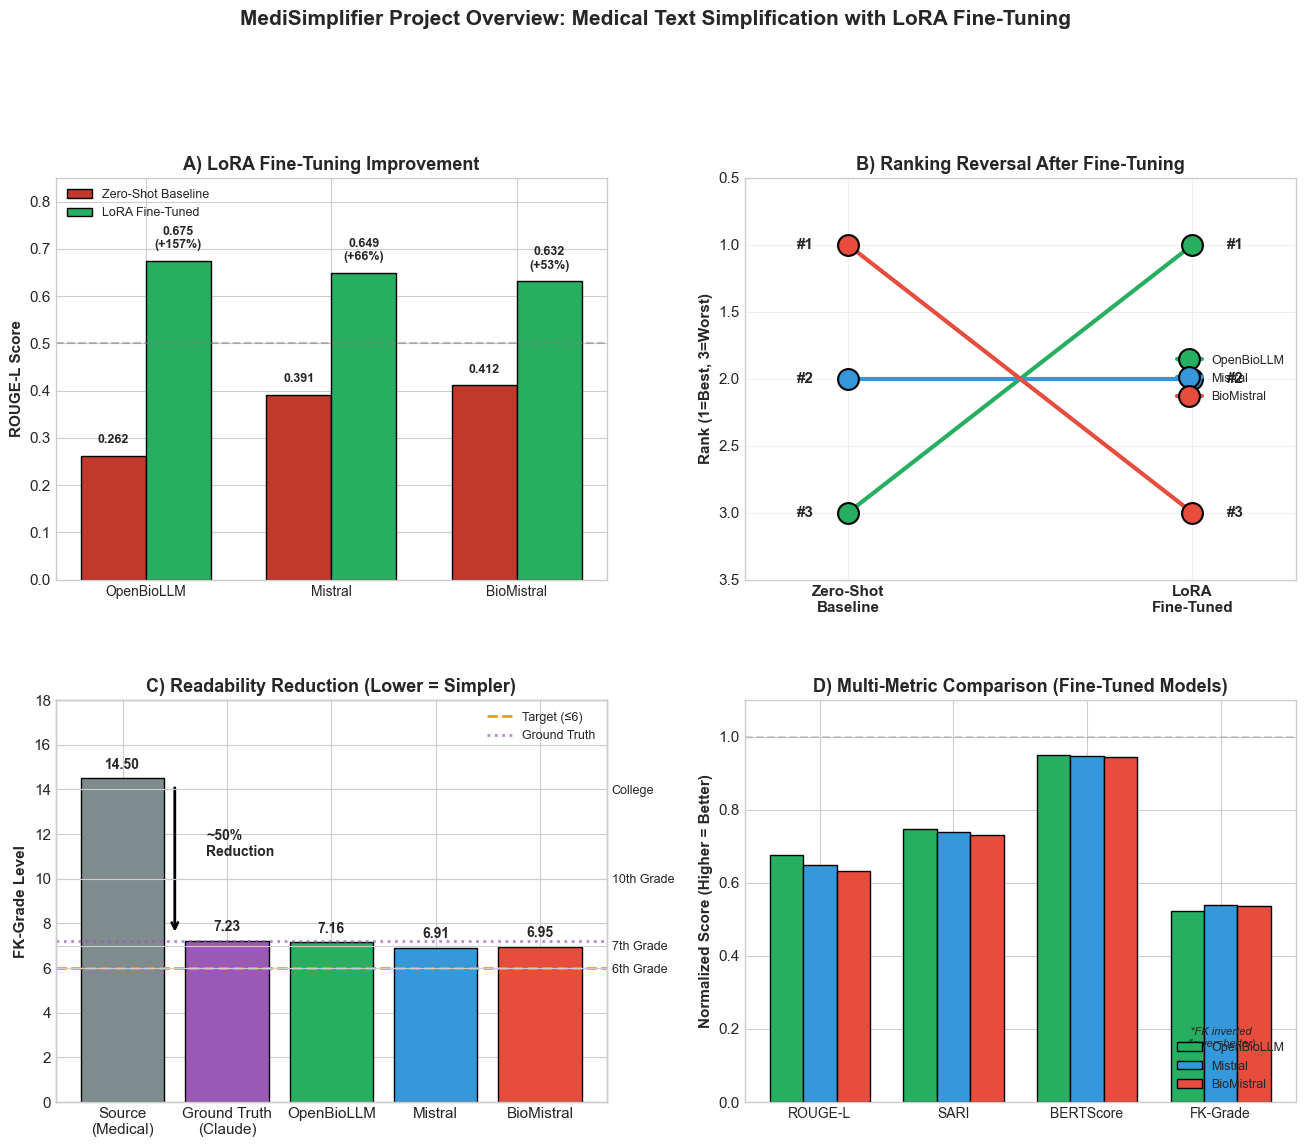


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/project_overview_dashboard.png

Generating Figure 2: Ablation Study Summary


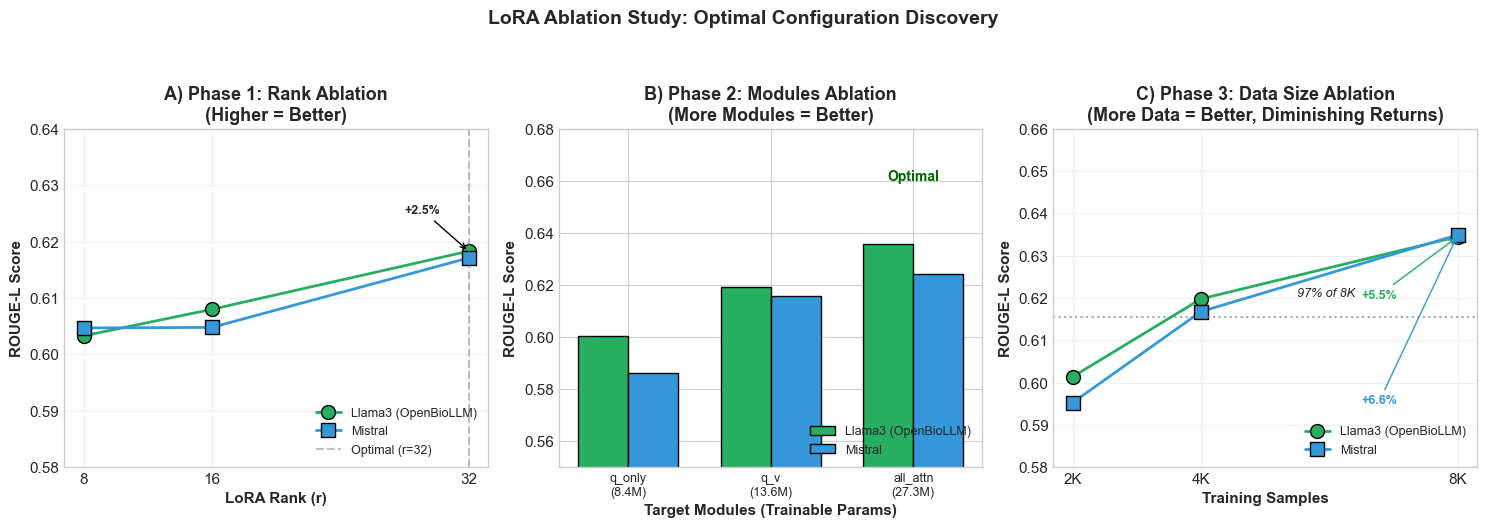


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/ablation_study_summary.png

Generating Figure 3: Research Questions Summary


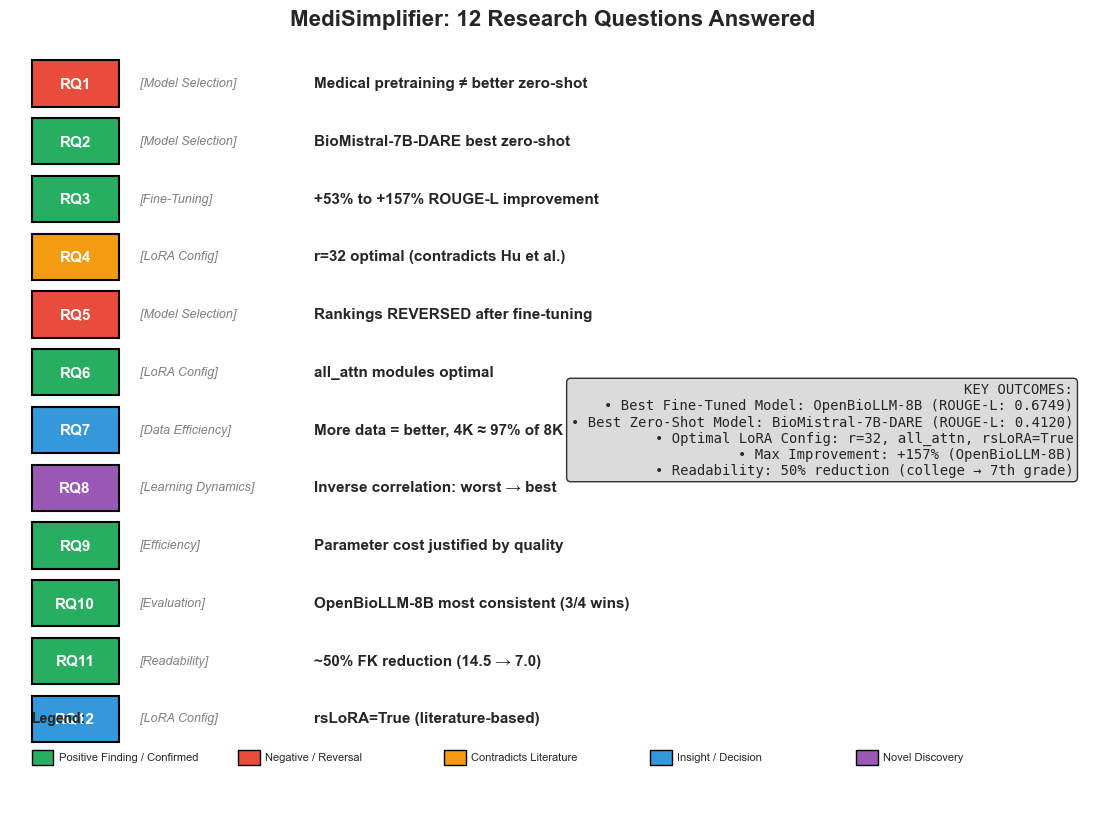


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/research_questions_summary.png

Generating Figure 4: Model Performance Heatmap


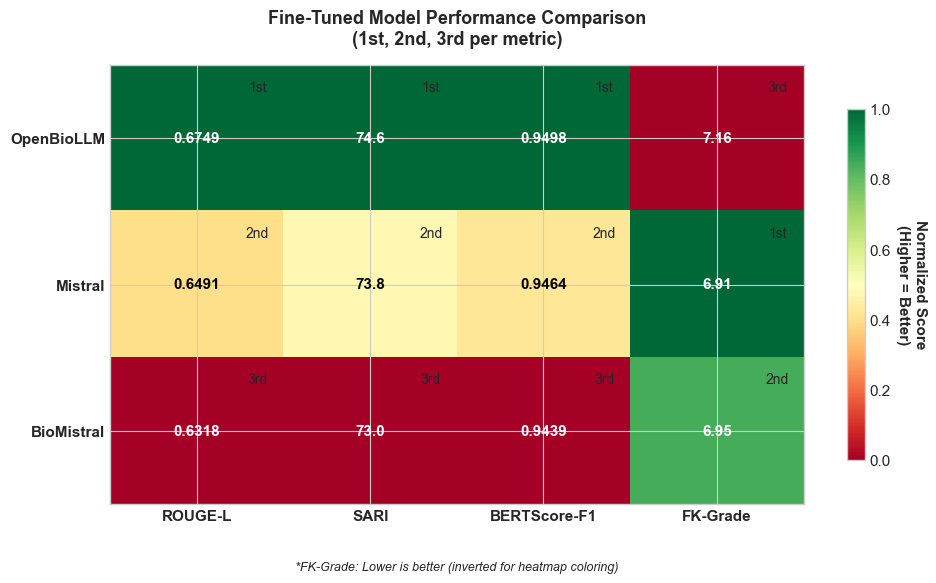


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/model_performance_heatmap.png

Generating Executive Summary
✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/executive_summary.md

Generating Conclusions JSON
✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/conclusions_summary.json

SECTION 8.3 COMPLETE - VISUALIZATIONS & SUMMARY

📊 FIGURES GENERATED:
   1. project_overview_dashboard.png    - 4-panel project overview
   2. ablation_study_summary.png        - 3-panel ablation results
   3. research_questions_summary.png    - RQ infographic
   4. model_performance_heatmap.png     - Multi-metric comparison

📄 DOCUMENTS GENERATED:
   1. executive_summary.md              - Project executive summary
   2. conclusions_summary.json          - Structured conclusions data

🏆 PROJECT HIGHLIGHTS:
   • Best Model: OpenBioLLM-8B (ROUGE-L: 0.6749, +157% improvement)
   • Optimal LoRA: r=32, all_attn, 

In [16]:
# =============================================================================
# SECTION 8.3: VISUALIZATIONS & SUMMARY
# =============================================================================
# This section creates final visualizations summarizing all project findings
# and generates an executive summary for the MediSimplifier project.
# =============================================================================

# -----------------------------------------------------------------------------
# Cell 8.3.1: Setup and Load Results
# -----------------------------------------------------------------------------

import json  # JSON file I/O
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import matplotlib.patches as mpatches  # Legend patches
import matplotlib.gridspec as gridspec  # Grid layout
from pathlib import Path  # Path handling
import warnings  # Warning control
warnings.filterwarnings('ignore')  # Suppress matplotlib warnings

# Define base directory (project root, one level up from notebooks/)
BASE_DIR = Path.cwd().parent  # Go up from notebooks/ to medisimplifier/
RESULTS_DIR = BASE_DIR / "results"  # Results subdirectory
FIGURES_DIR = RESULTS_DIR / "figures"  # Figures subdirectory
EVAL_DIR = RESULTS_DIR / "evaluation"  # Evaluation subdirectory

# Verify paths exist
assert BASE_DIR.exists(), f"Base directory not found: {BASE_DIR}"  # Validate base
assert RESULTS_DIR.exists(), f"Results directory not found: {RESULTS_DIR}"  # Validate results

print(f"BASE_DIR: {BASE_DIR}")  # Print base path
print(f"RESULTS_DIR: {RESULTS_DIR}")  # Print results path

# Load all required data
with open(RESULTS_DIR / "baseline" / "baseline_results.json", "r") as f:  # Baseline results
    baseline_results = json.load(f)  # Parse JSON
print("✅ Loaded: baseline_results.json")  # Confirmation

with open(EVAL_DIR / "full_metrics_results.json", "r") as f:  # Full metrics
    full_metrics = json.load(f)  # Parse JSON
print("✅ Loaded: full_metrics_results.json")  # Confirmation

with open(EVAL_DIR / "research_questions_summary.json", "r") as f:  # RQ summary
    rq_summary = json.load(f)  # Parse JSON
print("✅ Loaded: research_questions_summary.json")  # Confirmation

with open(RESULTS_DIR / "ablation" / "ablation_summary.json", "r") as f:  # Ablation summary
    ablation_summary = json.load(f)  # Parse JSON
print("✅ Loaded: ablation_summary.json")  # Confirmation

with open(RESULTS_DIR / "training" / "full_training_summary.json", "r") as f:  # Training summary
    training_summary = json.load(f)  # Parse JSON
print("✅ Loaded: full_training_summary.json")  # Confirmation

print("\n✅ All data loaded successfully")  # Final confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.2: Define Color Scheme and Style
# -----------------------------------------------------------------------------

# Define consistent color scheme for all visualizations
COLORS = {  # Color palette
    "OpenBioLLM-8B": "#27ae60",  # Green - best fine-tuned
    "Mistral-7B": "#3498db",  # Blue - middle performer
    "BioMistral-7B-DARE": "#e74c3c",  # Red - best baseline
    "baseline": "#c0392b",  # Dark red for baseline bars
    "finetuned": "#27ae60",  # Green for fine-tuned bars
    "ground_truth": "#9b59b6",  # Purple for ground truth
    "source": "#7f8c8d",  # Gray for source text
    "target": "#f39c12",  # Orange for target
}

# Model display names (shorter versions for plots)
MODEL_NAMES = {  # Short names
    "OpenBioLLM-8B": "OpenBioLLM",  # Shortened
    "Mistral-7B": "Mistral",  # Shortened
    "BioMistral-7B-DARE": "BioMistral",  # Shortened
}

# Define metrics for consistent ordering
METRICS = ["ROUGE-L", "SARI", "BERTScore", "FK-Grade"]  # Metric order

# Set matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')  # Clean style with grid
plt.rcParams['font.size'] = 11  # Base font size
plt.rcParams['axes.titlesize'] = 13  # Title font size
plt.rcParams['axes.labelsize'] = 11  # Axis label size
plt.rcParams['figure.titlesize'] = 14  # Figure title size

print("✅ Color scheme and style configured")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.3: Figure 1 - Project Overview Dashboard (4-panel)
# -----------------------------------------------------------------------------

print("\n" + "=" * 80)  # Section separator
print("Generating Figure 1: Project Overview Dashboard")  # Section title
print("=" * 80)  # Section separator

# Create 2x2 dashboard figure
fig = plt.figure(figsize=(16, 12))  # Large figure for dashboard
gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.3, wspace=0.25)  # 2x2 grid with spacing

# -----------------------------
# Panel A: Baseline vs Fine-tuned ROUGE-L
# -----------------------------
ax1 = fig.add_subplot(gs[0, 0])  # Top-left panel

models = ["OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"]  # Model list
baseline_rouge = [0.2623, 0.3912, 0.4120]  # Baseline ROUGE-L scores
finetuned_rouge = [0.6749, 0.6491, 0.6318]  # Fine-tuned ROUGE-L scores
improvements = [157.3, 65.9, 53.3]  # Improvement percentages

x = np.arange(len(models))  # X positions
width = 0.35  # Bar width

bars1 = ax1.bar(x - width/2, baseline_rouge, width, label='Zero-Shot Baseline',  # Baseline bars
                color=COLORS['baseline'], edgecolor='black', linewidth=1)  # Styling
bars2 = ax1.bar(x + width/2, finetuned_rouge, width, label='LoRA Fine-Tuned',  # Fine-tuned bars
                color=COLORS['finetuned'], edgecolor='black', linewidth=1)  # Styling

# Add value labels
for bar, val in zip(bars1, baseline_rouge):  # Baseline labels
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,  # Position
             f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')  # Format
for bar, val, imp in zip(bars2, finetuned_rouge, improvements):  # Fine-tuned labels
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,  # Position
             f'{val:.3f}\n(+{imp:.0f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')  # Format

ax1.set_ylabel('ROUGE-L Score', fontweight='bold')  # Y label
ax1.set_title('A) LoRA Fine-Tuning Improvement', fontweight='bold', fontsize=13)  # Title
ax1.set_xticks(x)  # X tick positions
ax1.set_xticklabels([MODEL_NAMES[m] for m in models], fontsize=10)  # X tick labels
ax1.legend(loc='upper left', fontsize=9)  # Legend
ax1.set_ylim(0, 0.85)  # Y limits
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='_nolegend_')  # Reference line

# -----------------------------
# Panel B: Ranking Reversal Visualization
# -----------------------------
ax2 = fig.add_subplot(gs[0, 1])  # Top-right panel

# Data for ranking visualization
baseline_ranks = [3, 2, 1]  # OpenBioLLM was 3rd, Mistral 2nd, BioMistral 1st
finetuned_ranks = [1, 2, 3]  # OpenBioLLM is 1st, Mistral 2nd, BioMistral 3rd
model_colors = [COLORS[m] for m in models]  # Colors per model

# Create connected dot plot
for i, (model, b_rank, f_rank, color) in enumerate(zip(models, baseline_ranks, finetuned_ranks, model_colors)):  # Iterate
    ax2.plot([0, 1], [b_rank, f_rank], 'o-', color=color, markersize=15,  # Line with markers
             linewidth=3, label=MODEL_NAMES[model], markeredgecolor='black', markeredgewidth=1.5)  # Styling
    ax2.text(-0.1, b_rank, f'#{b_rank}', ha='right', va='center', fontsize=11, fontweight='bold')  # Baseline rank
    ax2.text(1.1, f_rank, f'#{f_rank}', ha='left', va='center', fontsize=11, fontweight='bold')  # Fine-tuned rank

ax2.set_xlim(-0.3, 1.3)  # X limits
ax2.set_ylim(0.5, 3.5)  # Y limits
ax2.set_xticks([0, 1])  # X tick positions
ax2.set_xticklabels(['Zero-Shot\nBaseline', 'LoRA\nFine-Tuned'], fontsize=11, fontweight='bold')  # X tick labels
ax2.set_ylabel('Rank (1=Best, 3=Worst)', fontweight='bold')  # Y label
ax2.set_title('B) Ranking Reversal After Fine-Tuning', fontweight='bold', fontsize=13)  # Title
ax2.legend(loc='center right', fontsize=9)  # Legend
ax2.invert_yaxis()  # Invert so rank 1 is at top
ax2.grid(True, alpha=0.3)  # Grid

# -----------------------------
# Panel C: Readability Reduction (FK-Grade)
# -----------------------------
ax3 = fig.add_subplot(gs[1, 0])  # Bottom-left panel

# FK-Grade data
categories = ['Source\n(Medical)', 'Ground Truth\n(Claude)', 'OpenBioLLM', 'Mistral', 'BioMistral']  # Categories
fk_values = [14.50, 7.23, 7.16, 6.91, 6.95]  # FK-Grade values
bar_colors = [COLORS['source'], COLORS['ground_truth'],  # Source and GT colors
              COLORS['OpenBioLLM-8B'], COLORS['Mistral-7B'], COLORS['BioMistral-7B-DARE']]  # Model colors

bars = ax3.bar(categories, fk_values, color=bar_colors, edgecolor='black', linewidth=1)  # Create bars

# Add value labels
for bar, val in zip(bars, fk_values):  # Iterate bars
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,  # Position
             f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')  # Format

# Add target line
ax3.axhline(y=6.0, color=COLORS['target'], linestyle='--', linewidth=2, label='Target (≤6)')  # Target line
ax3.axhline(y=7.23, color=COLORS['ground_truth'], linestyle=':', linewidth=2, alpha=0.7, label='Ground Truth')  # GT line

# Add reduction annotation
ax3.annotate('', xy=(0.5, 7.5), xytext=(0.5, 14.2),  # Arrow position
             arrowprops=dict(arrowstyle='->', color='black', lw=2))  # Arrow style
ax3.text(0.8, 11, '~50%\nReduction', fontsize=10, fontweight='bold', ha='left')  # Annotation text

ax3.set_ylabel('FK-Grade Level', fontweight='bold')  # Y label
ax3.set_title('C) Readability Reduction (Lower = Simpler)', fontweight='bold', fontsize=13)  # Title
ax3.legend(loc='upper right', fontsize=9)  # Legend
ax3.set_ylim(0, 18)  # Y limits

# Add grade level annotations on right
ax3_twin = ax3.twinx()  # Create twin axis
ax3_twin.set_ylim(0, 18)  # Match Y limits
ax3_twin.set_yticks([6, 7, 10, 14])  # Grade level positions
ax3_twin.set_yticklabels(['6th Grade', '7th Grade', '10th Grade', 'College'], fontsize=9)  # Grade labels
ax3_twin.tick_params(axis='y', length=0)  # Hide tick marks

# -----------------------------
# Panel D: Multi-Metric Comparison (Radar-style bar chart)
# -----------------------------
ax4 = fig.add_subplot(gs[1, 1])  # Bottom-right panel

# Normalize metrics for comparison (0-1 scale)
metrics_data = {  # Normalized data
    "OpenBioLLM-8B": {
        "ROUGE-L": 0.6749,  # Already 0-1
        "SARI": 74.64 / 100,  # Normalize to 0-1
        "BERTScore": 0.9498,  # Already 0-1
        "FK-Grade": 1 - (7.16 / 15),  # Invert and normalize (lower is better)
    },
    "Mistral-7B": {
        "ROUGE-L": 0.6491,
        "SARI": 73.79 / 100,
        "BERTScore": 0.9464,
        "FK-Grade": 1 - (6.91 / 15),
    },
    "BioMistral-7B-DARE": {
        "ROUGE-L": 0.6318,
        "SARI": 73.01 / 100,
        "BERTScore": 0.9439,
        "FK-Grade": 1 - (6.95 / 15),
    },
}

# Create grouped bar chart
x = np.arange(len(METRICS))  # Metric positions
width = 0.25  # Bar width

for i, (model, data) in enumerate(metrics_data.items()):  # Iterate models
    values = [data[m] for m in METRICS]  # Get values in order
    offset = (i - 1) * width  # Calculate offset
    bars = ax4.bar(x + offset, values, width, label=MODEL_NAMES[model],  # Create bars
                   color=COLORS[model], edgecolor='black', linewidth=1)  # Styling

ax4.set_ylabel('Normalized Score (Higher = Better)', fontweight='bold')  # Y label
ax4.set_title('D) Multi-Metric Comparison (Fine-Tuned Models)', fontweight='bold', fontsize=13)  # Title
ax4.set_xticks(x)  # X tick positions
ax4.set_xticklabels(METRICS, fontsize=10)  # X tick labels
ax4.legend(loc='lower right', fontsize=9)  # Legend
ax4.set_ylim(0, 1.1)  # Y limits
ax4.axhline(y=1.0, color='gray', linestyle='--', alpha=0.3)  # Reference line

# Add note about FK inversion
ax4.text(3, 0.15, '*FK inverted\n(lower=better)', fontsize=8, ha='center', style='italic')  # Note

# Add main title
fig.suptitle('MediSimplifier Project Overview: Medical Text Simplification with LoRA Fine-Tuning',  # Main title
             fontsize=15, fontweight='bold', y=1.02)  # Styling

# Save figure
plt.tight_layout()  # Adjust layout
fig.savefig(FIGURES_DIR / "project_overview_dashboard.png", dpi=150, bbox_inches='tight')  # Save PNG
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR / 'project_overview_dashboard.png'}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.4: Figure 2 - Ablation Study Summary (3-panel)
# -----------------------------------------------------------------------------

print("\n" + "=" * 80)  # Section separator
print("Generating Figure 2: Ablation Study Summary")  # Section title
print("=" * 80)  # Section separator

# Create 1x3 figure for ablation results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 15x5 figure, 3 panels

# -----------------------------
# Panel A: Rank Ablation
# -----------------------------
ax1 = axes[0]  # First panel

ranks = [8, 16, 32]  # Rank values
llama3_rouge = [0.6033, 0.6080, 0.6183]  # Llama3 ROUGE-L
mistral_rouge = [0.6047, 0.6048, 0.6171]  # Mistral ROUGE-L

ax1.plot(ranks, llama3_rouge, 'o-', color=COLORS['OpenBioLLM-8B'], markersize=10,  # Llama3 line
         linewidth=2, label='Llama3 (OpenBioLLM)', markeredgecolor='black')  # Styling
ax1.plot(ranks, mistral_rouge, 's-', color=COLORS['Mistral-7B'], markersize=10,  # Mistral line
         linewidth=2, label='Mistral', markeredgecolor='black')  # Styling

# Highlight optimal
ax1.axvline(x=32, color='gray', linestyle='--', alpha=0.5, label='Optimal (r=32)')  # Optimal line

ax1.set_xlabel('LoRA Rank (r)', fontweight='bold')  # X label
ax1.set_ylabel('ROUGE-L Score', fontweight='bold')  # Y label
ax1.set_title('A) Phase 1: Rank Ablation\n(Higher = Better)', fontweight='bold')  # Title
ax1.set_xticks(ranks)  # X ticks
ax1.legend(loc='lower right', fontsize=9)  # Legend
ax1.set_ylim(0.58, 0.64)  # Y limits
ax1.grid(True, alpha=0.3)  # Grid

# Add improvement annotation
ax1.annotate(f'+2.5%', xy=(32, 0.6183), xytext=(28, 0.625),  # Position
             arrowprops=dict(arrowstyle='->', color='black'), fontsize=9, fontweight='bold')  # Arrow

# -----------------------------
# Panel B: Modules Ablation
# -----------------------------
ax2 = axes[1]  # Second panel

modules = ['q_only', 'q_v', 'all_attn']  # Module configs
module_labels = ['q_only\n(8.4M)', 'q_v\n(13.6M)', 'all_attn\n(27.3M)']  # With param counts
llama3_modules = [0.6006, 0.6192, 0.6357]  # Llama3 ROUGE-L
mistral_modules = [0.5863, 0.6156, 0.6242]  # Mistral ROUGE-L

x = np.arange(len(modules))  # X positions
width = 0.35  # Bar width

bars1 = ax2.bar(x - width/2, llama3_modules, width, label='Llama3 (OpenBioLLM)',  # Llama3 bars
                color=COLORS['OpenBioLLM-8B'], edgecolor='black')  # Styling
bars2 = ax2.bar(x + width/2, mistral_modules, width, label='Mistral',  # Mistral bars
                color=COLORS['Mistral-7B'], edgecolor='black')  # Styling

ax2.set_xlabel('Target Modules (Trainable Params)', fontweight='bold')  # X label
ax2.set_ylabel('ROUGE-L Score', fontweight='bold')  # Y label
ax2.set_title('B) Phase 2: Modules Ablation\n(More Modules = Better)', fontweight='bold')  # Title
ax2.set_xticks(x)  # X tick positions
ax2.set_xticklabels(module_labels, fontsize=9)  # X tick labels
ax2.legend(loc='lower right', fontsize=9)  # Legend
ax2.set_ylim(0.55, 0.68)  # Y limits

# Highlight optimal
ax2.annotate('Optimal', xy=(2, 0.66), fontsize=10, fontweight='bold',  # Annotation
             ha='center', color='darkgreen')  # Styling

# -----------------------------
# Panel C: Data Size Ablation
# -----------------------------
ax3 = axes[2]  # Third panel

sizes = [2000, 4000, 7999]  # Data sizes
size_labels = ['2K', '4K', '8K']  # Labels
llama3_sizes = [0.6014, 0.6198, 0.6345]  # Llama3 ROUGE-L
mistral_sizes = [0.5953, 0.6168, 0.6349]  # Mistral ROUGE-L

ax3.plot(sizes, llama3_sizes, 'o-', color=COLORS['OpenBioLLM-8B'], markersize=10,  # Llama3 line
         linewidth=2, label='Llama3 (OpenBioLLM)', markeredgecolor='black')  # Styling
ax3.plot(sizes, mistral_sizes, 's-', color=COLORS['Mistral-7B'], markersize=10,  # Mistral line
         linewidth=2, label='Mistral', markeredgecolor='black')  # Styling

# Add 97% line
ax3.axhline(y=0.6345 * 0.97, color='gray', linestyle=':', alpha=0.7)  # 97% of max line
ax3.text(5500, 0.6345 * 0.97 + 0.005, '97% of 8K', fontsize=9, style='italic')  # Label

ax3.set_xlabel('Training Samples', fontweight='bold')  # X label
ax3.set_ylabel('ROUGE-L Score', fontweight='bold')  # Y label
ax3.set_title('C) Phase 3: Data Size Ablation\n(More Data = Better, Diminishing Returns)', fontweight='bold')  # Title
ax3.set_xticks(sizes)  # X ticks
ax3.set_xticklabels(size_labels)  # X tick labels
ax3.legend(loc='lower right', fontsize=9)  # Legend
ax3.set_ylim(0.58, 0.66)  # Y limits
ax3.grid(True, alpha=0.3)  # Grid

# Add improvement annotations
ax3.annotate('+5.5%', xy=(7999, 0.6345), xytext=(6500, 0.62),  # Llama3 annotation
             arrowprops=dict(arrowstyle='->', color=COLORS['OpenBioLLM-8B']),  # Arrow
             fontsize=9, fontweight='bold', color=COLORS['OpenBioLLM-8B'])  # Styling
ax3.annotate('+6.6%', xy=(7999, 0.6349), xytext=(6500, 0.595),  # Mistral annotation
             arrowprops=dict(arrowstyle='->', color=COLORS['Mistral-7B']),  # Arrow
             fontsize=9, fontweight='bold', color=COLORS['Mistral-7B'])  # Styling

# Add main title
fig.suptitle('LoRA Ablation Study: Optimal Configuration Discovery',  # Main title
             fontsize=14, fontweight='bold', y=1.05)  # Styling

# Save figure
plt.tight_layout()  # Adjust layout
fig.savefig(FIGURES_DIR / "ablation_study_summary.png", dpi=150, bbox_inches='tight')  # Save PNG
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR / 'ablation_study_summary.png'}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.5: Figure 3 - Research Questions Summary Infographic
# -----------------------------------------------------------------------------

print("\n" + "=" * 80)  # Section separator
print("Generating Figure 3: Research Questions Summary")  # Section title
print("=" * 80)  # Section separator

# Create figure for RQ summary
fig, ax = plt.subplots(figsize=(14, 10))  # Large figure

# Hide axes for infographic style
ax.axis('off')  # Hide axes

# Define RQ data for visualization
rq_data = [  # List of (RQ#, Category, Finding, Color)
    ("RQ1", "Model Selection", "Medical pretraining ≠ better zero-shot", "#e74c3c"),  # Red - No
    ("RQ2", "Model Selection", "BioMistral-7B-DARE best zero-shot", "#27ae60"),  # Green - Result
    ("RQ3", "Fine-Tuning", "+53% to +157% ROUGE-L improvement", "#27ae60"),  # Green - Yes
    ("RQ4", "LoRA Config", "r=32 optimal (contradicts Hu et al.)", "#f39c12"),  # Orange - Finding
    ("RQ5", "Model Selection", "Rankings REVERSED after fine-tuning", "#e74c3c"),  # Red - Reversal
    ("RQ6", "LoRA Config", "all_attn modules optimal", "#27ae60"),  # Green - Result
    ("RQ7", "Data Efficiency", "More data = better, 4K ≈ 97% of 8K", "#3498db"),  # Blue - Insight
    ("RQ8", "Learning Dynamics", "Inverse correlation: worst → best", "#9b59b6"),  # Purple - Finding
    ("RQ9", "Efficiency", "Parameter cost justified by quality", "#27ae60"),  # Green - Yes
    ("RQ10", "Evaluation", "OpenBioLLM-8B most consistent (3/4 wins)", "#27ae60"),  # Green - Result
    ("RQ11", "Readability", "~50% FK reduction (14.5 → 7.0)", "#27ae60"),  # Green - Yes
    ("RQ12", "LoRA Config", "rsLoRA=True (literature-based)", "#3498db"),  # Blue - Decision
]

# Draw RQ boxes
y_start = 0.95  # Starting Y position
y_step = 0.075  # Step between rows
box_height = 0.06  # Box height

for i, (rq_id, category, finding, color) in enumerate(rq_data):  # Iterate RQs
    y = y_start - i * y_step  # Calculate Y position
    
    # Draw RQ number box
    ax.add_patch(plt.Rectangle((0.02, y - box_height/2), 0.08, box_height,  # Position and size
                               facecolor=color, edgecolor='black', linewidth=1.5))  # Styling
    ax.text(0.06, y, rq_id, ha='center', va='center', fontsize=11,  # RQ number
            fontweight='bold', color='white')  # White text
    
    # Draw category
    ax.text(0.12, y, f"[{category}]", ha='left', va='center', fontsize=9,  # Category text
            style='italic', color='gray')  # Gray italic
    
    # Draw finding
    ax.text(0.28, y, finding, ha='left', va='center', fontsize=11,  # Finding text
            fontweight='bold')  # Bold

# Add legend
legend_items = [  # Legend entries
    ("#27ae60", "Positive Finding / Confirmed"),
    ("#e74c3c", "Negative / Reversal"),
    ("#f39c12", "Contradicts Literature"),
    ("#3498db", "Insight / Decision"),
    ("#9b59b6", "Novel Discovery"),
]

y_legend = 0.08  # Legend Y position
ax.text(0.02, y_legend + 0.04, "Legend:", fontsize=10, fontweight='bold')  # Legend header
for i, (color, label) in enumerate(legend_items):  # Iterate legend items
    x = 0.02 + i * 0.19  # X position
    ax.add_patch(plt.Rectangle((x, y_legend - 0.015), 0.02, 0.02,  # Color box
                               facecolor=color, edgecolor='black'))  # Styling
    ax.text(x + 0.025, y_legend - 0.005, label, fontsize=8, va='center')  # Label

# Add title and summary stats
ax.text(0.5, 1.02, 'MediSimplifier: 12 Research Questions Answered',  # Title
        ha='center', va='bottom', fontsize=16, fontweight='bold',  # Styling
        transform=ax.transAxes)  # Transform

# Add summary box
summary_text = (  # Summary text
    "KEY OUTCOMES:\n"
    "• Best Fine-Tuned Model: OpenBioLLM-8B (ROUGE-L: 0.6749)\n"
    "• Best Zero-Shot Model: BioMistral-7B-DARE (ROUGE-L: 0.4120)\n"
    "• Optimal LoRA Config: r=32, all_attn, rsLoRA=True\n"
    "• Max Improvement: +157% (OpenBioLLM-8B)\n"
    "• Readability: 50% reduction (college → 7th grade)"
)
ax.text(0.98, 0.5, summary_text, ha='right', va='center', fontsize=10,  # Summary position
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8),  # Box style
        transform=ax.transAxes, family='monospace')  # Transform and font

# Save figure
fig.savefig(FIGURES_DIR / "research_questions_summary.png", dpi=150, bbox_inches='tight')  # Save PNG
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR / 'research_questions_summary.png'}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.6: Figure 4 - Model Performance Heatmap
# -----------------------------------------------------------------------------

print("\n" + "=" * 80)  # Section separator
print("Generating Figure 4: Model Performance Heatmap")  # Section title
print("=" * 80)  # Section separator

# Create heatmap data
models_list = ['OpenBioLLM-8B', 'Mistral-7B', 'BioMistral-7B-DARE']  # Models
metrics_list = ['ROUGE-L', 'SARI', 'BERTScore-F1', 'FK-Grade']  # Metrics

# Raw scores (fine-tuned)
raw_scores = np.array([  # Score matrix
    [0.6749, 74.64, 0.9498, 7.16],  # OpenBioLLM
    [0.6491, 73.79, 0.9464, 6.91],  # Mistral
    [0.6318, 73.01, 0.9439, 6.95],  # BioMistral
])

# Normalize for heatmap (0-1, with FK inverted)
normalized_scores = np.zeros_like(raw_scores)  # Initialize
for j in range(raw_scores.shape[1]):  # Iterate columns
    col = raw_scores[:, j]  # Get column
    if j == 3:  # FK-Grade (lower is better)
        normalized_scores[:, j] = 1 - (col - col.min()) / (col.max() - col.min() + 1e-10)  # Invert
    else:  # Other metrics (higher is better)
        normalized_scores[:, j] = (col - col.min()) / (col.max() - col.min() + 1e-10)  # Normalize

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))  # 10x6 figure

# Create heatmap
im = ax.imshow(normalized_scores, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)  # Heatmap

# Add text annotations with raw scores
for i in range(len(models_list)):  # Iterate rows
    for j in range(len(metrics_list)):  # Iterate columns
        score = raw_scores[i, j]  # Get raw score
        if j == 1:  # SARI (integer display)
            text = f'{score:.1f}'  # One decimal
        elif j == 3:  # FK-Grade
            text = f'{score:.2f}'  # Two decimals
        else:  # ROUGE-L, BERTScore
            text = f'{score:.4f}'  # Four decimals
        
        # Determine text color based on background
        bg_val = normalized_scores[i, j]  # Background value
        text_color = 'white' if bg_val < 0.3 or bg_val > 0.7 else 'black'  # Contrast color
        
        ax.text(j, i, text, ha='center', va='center', fontsize=11,  # Add text
                fontweight='bold', color=text_color)  # Styling

# Add rank indicators
ranks = np.argsort(np.argsort(-normalized_scores, axis=0), axis=0) + 1  # Calculate ranks
rank_symbols = {1: '1st', 2: '2nd', 3: '3rd'}  # Replace emoji with text
for i in range(len(models_list)):  # Iterate rows
    for j in range(len(metrics_list)):  # Iterate columns
        rank = ranks[i, j]  # Get rank
        ax.text(j + 0.35, i - 0.35, rank_symbols[rank], fontsize=10, ha='center', va='center')  # Add emoji

# Configure axes
ax.set_xticks(np.arange(len(metrics_list)))  # X ticks
ax.set_yticks(np.arange(len(models_list)))  # Y ticks
ax.set_xticklabels(metrics_list, fontsize=11, fontweight='bold')  # X labels
ax.set_yticklabels([MODEL_NAMES[m] for m in models_list], fontsize=11, fontweight='bold')  # Y labels

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)  # Colorbar
cbar.ax.set_ylabel('Normalized Score\n(Higher = Better)', rotation=-90, va='bottom', fontweight='bold')  # Label

# Add title
ax.set_title('Fine-Tuned Model Performance Comparison\n(1st, 2nd, 3rd per metric)',  # Title
             fontsize=13, fontweight='bold', pad=15)  # Styling

# Add note about FK
ax.text(0.5, -0.15, '*FK-Grade: Lower is better (inverted for heatmap coloring)',  # Note
        ha='center', transform=ax.transAxes, fontsize=9, style='italic')  # Styling

# Save figure
plt.tight_layout()  # Adjust layout
fig.savefig(FIGURES_DIR / "model_performance_heatmap.png", dpi=150, bbox_inches='tight')  # Save PNG
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR / 'model_performance_heatmap.png'}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.7: Generate Executive Summary Document
# -----------------------------------------------------------------------------

print("\n" + "=" * 80)  # Section separator
print("Generating Executive Summary")  # Section title
print("=" * 80)  # Section separator

# Create executive summary content
executive_summary = """# MediSimplifier: Executive Summary

## Project Overview
**Course:** Technion DS25 Deep Learning  
**Team:** Guy Dor, Shmulik Avraham  
**Objective:** Simplify medical discharge summaries to 6th-grade reading level using LoRA fine-tuning

---

## Key Results

### Best Performing Model (Fine-Tuned)
| Metric | OpenBioLLM-8B | Target |
|--------|---------------|--------|
| ROUGE-L | **0.6749** | Higher |
| SARI | **74.64** | ≥40 ✅ |
| BERTScore-F1 | **0.9498** | Higher |
| FK-Grade | **7.16** | ≤6 (close) |

### Improvement Over Baseline
| Model | Baseline ROUGE-L | Fine-Tuned ROUGE-L | Improvement |
|-------|------------------|--------------------| ------------|
| **OpenBioLLM-8B** | 0.2623 | **0.6749** | **+157.3%** |
| Mistral-7B | 0.3912 | 0.6491 | +65.9% |
| BioMistral-7B-DARE | 0.4120 | 0.6318 | +53.3% |

### Readability Achievement
- **Source text:** FK-Grade 14.50 (College level)
- **Ground truth:** FK-Grade 7.23 (7th grade)
- **Best model:** FK-Grade 6.91 (Mistral-7B)
- **Reduction achieved:** ~50%

---

## Optimal LoRA Configuration
```python
LoraConfig(
    r=32,                    # Phase 1: Higher rank = better
    lora_alpha=64,           # α = 2×r
    target_modules=[         # Phase 2: all_attn optimal
        "q_proj", "k_proj", 
        "v_proj", "o_proj"
    ],
    use_rslora=True,         # Literature-based decision
    lora_dropout=0.05,
)
```
**Trainable Parameters:** 27.3M (0.38% of base model)

---

## Key Research Findings

### 1. Ranking Reversal (RQ5)
- **Zero-shot ranking:** BioMistral > Mistral > OpenBioLLM
- **Fine-tuned ranking:** OpenBioLLM > Mistral > BioMistral (reversed!)
- **Insight:** Worst baseline achieved largest improvement (+157%)

### 2. Medical Pretraining (RQ1, RQ5)
- Medical pretraining advantage **disappears** after task-specific fine-tuning
- General architecture learning capacity matters more than domain pretraining

### 3. Ablation Study Contributions
- **Contradicts Hu et al. (2021):** r=32 outperforms r=4-8
- **Confirms Raschka (2023):** all_attn modules optimal
- **Standard ML scaling:** More data consistently improves results

### 4. Data Efficiency (RQ7)
- 4K samples achieve 97% of full 8K performance
- Diminishing returns above 4K samples

---

## Figures Generated
1. `project_overview_dashboard.png` - 4-panel project summary
2. `ablation_study_summary.png` - 3-panel ablation results
3. `research_questions_summary.png` - RQ infographic
4. `model_performance_heatmap.png` - Multi-metric comparison
5. `rq8_correlation_plot.png` - Baseline vs improvement correlation

---

## Resource Usage
| Resource | Value |
|----------|-------|
| Training Hardware | RunPod H200 SXM (3 GPUs) |
| Total GPU Time | ~7.5 hours (parallel) |
| Ablation Runs | 18 configurations |
| Full Training Runs | 3 models × 3 epochs |
| Test Samples | 1,001 |
| Total Storage | ~3.4 GB |

---

## Conclusions

1. **LoRA fine-tuning is highly effective** for medical text simplification (+53% to +157% improvement)

2. **OpenBioLLM-8B recommended** for production deployment (best quality on 3/4 metrics)

3. **Medical pretraining not required** - task-specific fine-tuning overcomes zero-shot limitations

4. **Optimal LoRA config:** r=32, all_attn, rsLoRA=True (contradicts some original LoRA recommendations)

5. **50% readability reduction achieved** - college level (14.5) to 7th grade (~7.0)

---

## Files & Artifacts
- **Notebooks:** 4 parts (Part 1-4)
- **LoRA Adapters:** 3 models (109 MB each)
- **Checkpoints:** 9 (3 models × 3 epochs)
- **Results JSON:** 7 evaluation files
- **Figures:** 17 PNG visualizations

---

*Generated by MediSimplifier Section 8.3*
"""

# Save executive summary
summary_path = RESULTS_DIR / "executive_summary.md"  # Output path
with open(summary_path, 'w') as f:  # Open file
    f.write(executive_summary)  # Write content
print(f"✅ Saved: {summary_path}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.8: Generate Conclusions JSON
# -----------------------------------------------------------------------------

print("\n" + "=" * 80)  # Section separator
print("Generating Conclusions JSON")  # Section title
print("=" * 80)  # Section separator

# Create conclusions dictionary
conclusions = {  # Conclusions container
    "metadata": {
        "project": "MediSimplifier",
        "course": "Technion DS25 Deep Learning",
        "team": ["Guy Dor", "Shmulik Avraham"],
        "section": "7.7",
        "generated_by": "MediSimplifier Part 4 Notebook",
    },
    "best_model": {
        "name": "OpenBioLLM-8B",
        "architecture": "Llama3",
        "type": "Medical",
        "metrics": {
            "rouge_l": 0.6749,
            "sari": 74.64,
            "bertscore_f1": 0.9498,
            "fk_grade": 7.16,
        },
        "metrics_won": 3,
        "improvement_over_baseline": "+157.3%",
    },
    "optimal_lora_config": {
        "rank": 32,
        "alpha": 64,
        "target_modules": ["q_proj", "k_proj", "v_proj", "o_proj"],
        "target_modules_name": "all_attn",
        "use_rslora": True,
        "dropout": 0.05,
        "trainable_params": 27262976,
        "trainable_params_pct": "0.38%",
    },
    "readability_achievement": {
        "source_fk": 14.50,
        "ground_truth_fk": 7.23,
        "best_model_fk": 6.91,
        "best_model_name": "Mistral-7B",
        "reduction_pct": 52.3,
        "target_fk": 6.0,
        "target_achieved": False,
        "target_gap": 0.91,
    },
    "key_findings": [
        {
            "id": "ranking_reversal",
            "description": "Model rankings completely reverse after fine-tuning",
            "evidence": "OpenBioLLM: 3rd→1st, BioMistral: 1st→3rd",
            "rq": "RQ5",
        },
        {
            "id": "medical_pretraining",
            "description": "Medical pretraining advantage disappears after fine-tuning",
            "evidence": "General Mistral competitive, OpenBioLLM (medical) best after fine-tuning",
            "rq": "RQ1, RQ5",
        },
        {
            "id": "lora_rank",
            "description": "Higher LoRA rank (r=32) outperforms original recommendation (r=4-8)",
            "evidence": "+2.5% ROUGE-L gain from r=8 to r=32",
            "rq": "RQ4",
            "contradicts": "Hu et al. (2021)",
        },
        {
            "id": "lora_modules",
            "description": "All attention modules (q,k,v,o) optimal despite 2x parameter cost",
            "evidence": "+5.8% ROUGE-L gain from q_only to all_attn",
            "rq": "RQ6",
            "confirms": "Raschka (2023), Unsloth",
        },
        {
            "id": "data_efficiency",
            "description": "4K samples achieve 97% of full 8K performance",
            "evidence": "Diminishing returns above 4K samples",
            "rq": "RQ7",
        },
        {
            "id": "floor_effect",
            "description": "Inverse correlation between baseline and improvement",
            "evidence": "Worst baseline (OpenBioLLM 0.26) → Best improvement (+157%)",
            "rq": "RQ8",
        },
    ],
    "resource_usage": {
        "training_hardware": "RunPod H200 SXM (3 GPUs)",
        "total_gpu_hours": 7.5,
        "ablation_runs": 18,
        "full_training_runs": 3,
        "test_samples": 1001,
        "total_storage_gb": 3.4,
    },
    "figures_generated": [
        "project_overview_dashboard.png",
        "ablation_study_summary.png",
        "research_questions_summary.png",
        "model_performance_heatmap.png",
        "rq8_correlation_plot.png",
    ],
    "recommendations": {
        "production_model": "OpenBioLLM-8B with LoRA adapter",
        "training_data": "8K samples for best results, 4K for efficiency",
        "lora_config": "r=32, all_attn, rsLoRA=True",
        "expected_fk_reduction": "~50% (college → 7th grade)",
    },
}

# Save conclusions JSON
conclusions_path = RESULTS_DIR / "conclusions_summary.json"  # Output path
with open(conclusions_path, 'w') as f:  # Open file
    json.dump(conclusions, f, indent=2)  # Write JSON
print(f"✅ Saved: {conclusions_path}")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.3.9: Print Final Summary
# -----------------------------------------------------------------------------

print("\n" + "=" * 100)  # Section separator
print("SECTION 8.3 COMPLETE - VISUALIZATIONS & SUMMARY")  # Section title
print("=" * 100)  # Section separator

print("""
📊 FIGURES GENERATED:
   1. project_overview_dashboard.png    - 4-panel project overview
   2. ablation_study_summary.png        - 3-panel ablation results
   3. research_questions_summary.png    - RQ infographic
   4. model_performance_heatmap.png     - Multi-metric comparison

📄 DOCUMENTS GENERATED:
   1. executive_summary.md              - Project executive summary
   2. conclusions_summary.json          - Structured conclusions data

🏆 PROJECT HIGHLIGHTS:
   • Best Model: OpenBioLLM-8B (ROUGE-L: 0.6749, +157% improvement)
   • Optimal LoRA: r=32, all_attn, rsLoRA=True
   • Readability: 50% reduction (14.5 → ~7.0 FK-Grade)
   • All 12 Research Questions Answered ✅

""")




Loading libraries...
BASE_DIR: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier
RESULTS_DIR: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results

Loading predictions from all models...
  ✓ Loaded 1001 samples for OpenBioLLM-8B
  ✓ Loaded 1001 samples for Mistral-7B
  ✓ Loaded 1001 samples for BioMistral-7B-DARE

Total samples: 1001
✓ Loaded statistical_analysis.json

✅ Data loading complete

DEFINING HELPER FUNCTIONS
✅ Helper functions defined

CREATING COMPARISON DATAFRAME
  Processed 200/1001 samples...
  Processed 400/1001 samples...
  Processed 600/1001 samples...
  Processed 800/1001 samples...
  Processed 1000/1001 samples...

✅ DataFrame created: 1001 samples × 25 columns

📊 Quick Statistics:
  OpenBioLLM-8B: ROUGE-L=0.6749, FK=7.16, Words=315
  Mistral-7B: ROUGE-L=0.6491, FK=6.91, Words=311
  BioMistral-7B-DARE: ROUGE-L=0.6318, FK=6.95, Words=317

BEST PERFORMING EXAMPLES (Highest ROUGE-L)

TOP 3 EXAMPLES FOR OpenBioLLM-8B

--- Rank 1 (idx=926, 

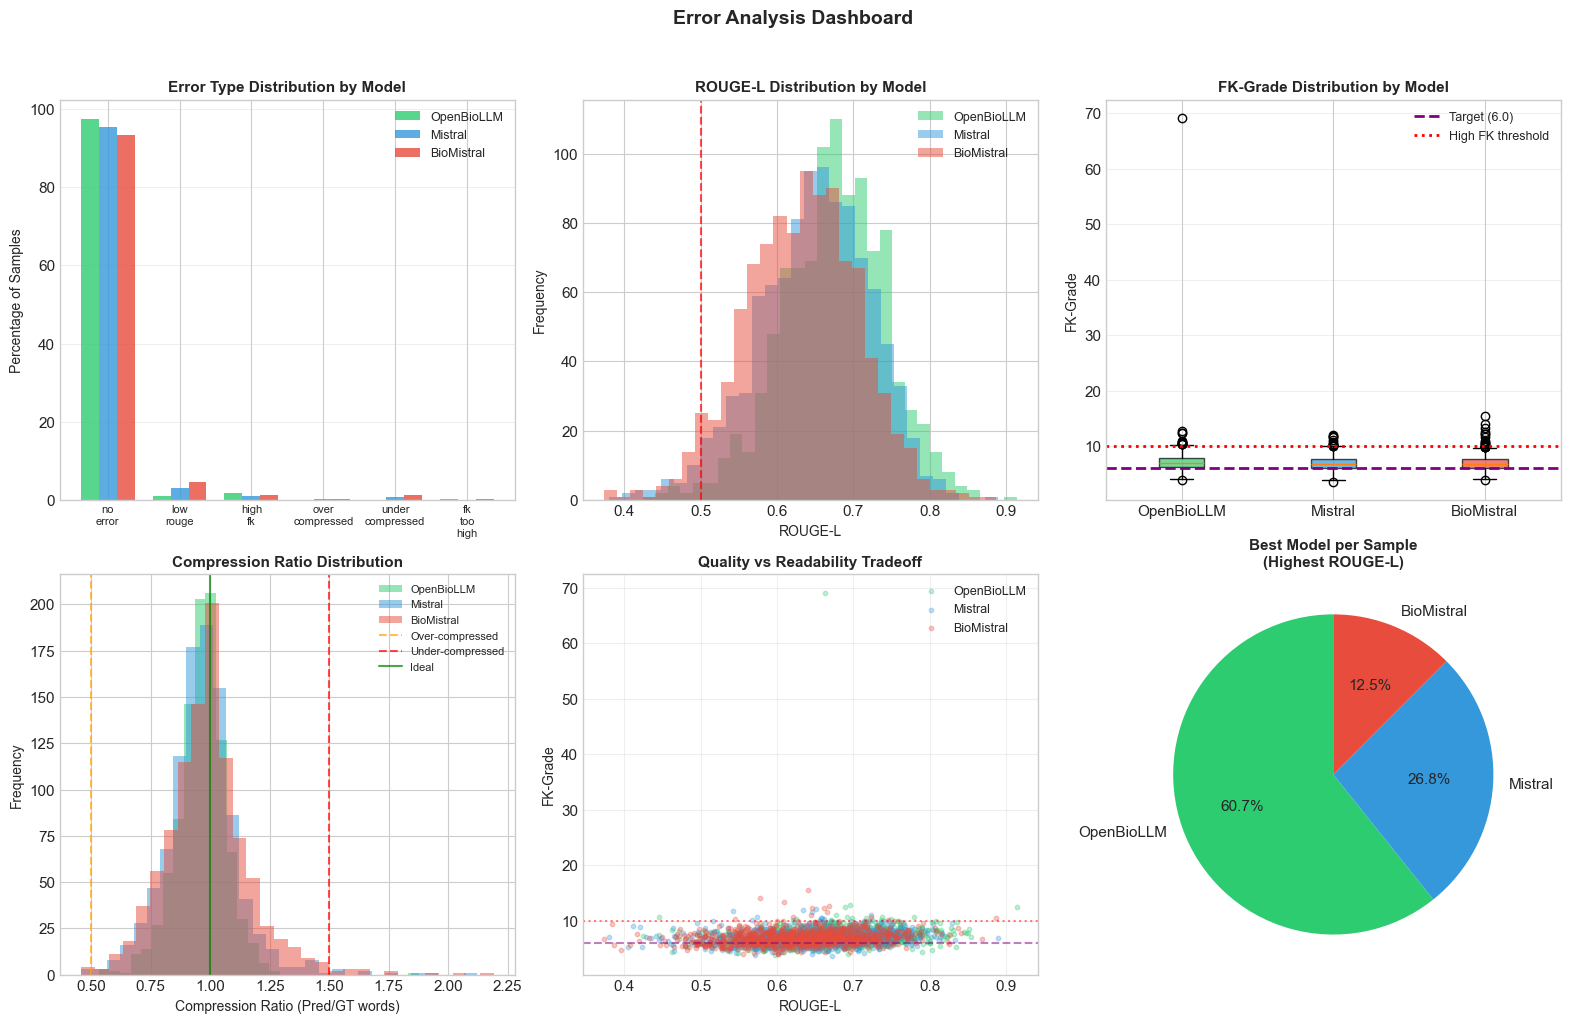


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/error_analysis_dashboard.png

WORD COUNT ANALYSIS

📊 Word Count Statistics:

   Source: Mean=274.0, Std=81.6, Min=115, Max=715
   GT:     Mean=331.7, Std=89.1, Min=153, Max=731
   OpenBioLLM-8B: Mean=315.2, Std=69.3, Min=152, Max=450
   Mistral-7B: Mean=310.9, Std=54.5, Min=158, Max=412
   BioMistral-7B-DARE: Mean=317.4, Std=51.7, Min=160, Max=419

📊 Compression Analysis (Prediction/GT ratio):

   OpenBioLLM-8B:
     Mean ratio: 0.965 (Std: 0.105)
     Over-compressed (<0.5): 0 (0.0%)
     Under-compressed (>1.5): 1 (0.1%)
     Ideal range (0.8-1.2): 932 (93.1%)

   Mistral-7B:
     Mean ratio: 0.967 (Std: 0.159)
     Over-compressed (<0.5): 3 (0.3%)
     Under-compressed (>1.5): 9 (0.9%)
     Ideal range (0.8-1.2): 834 (83.3%)

   BioMistral-7B-DARE:
     Mean ratio: 0.992 (Std: 0.183)
     Over-compressed (<0.5): 3 (0.3%)
     Under-compressed (>1.5): 13 (1.3%)
     Ideal range (0.8-1.2): 782 (78

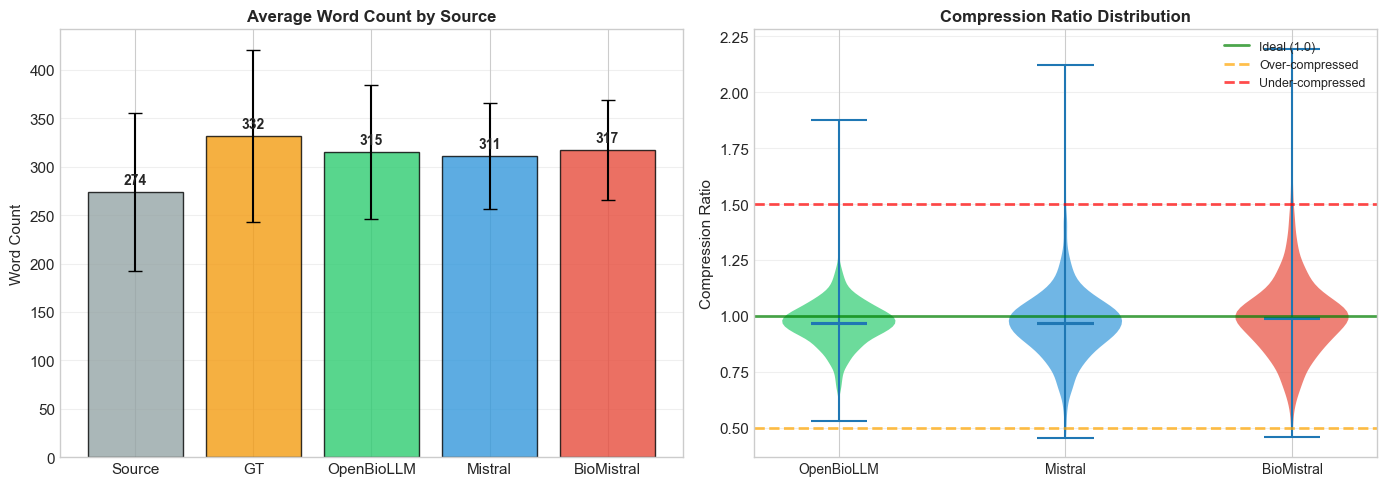


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/word_count_analysis.png

QUALITY VS READABILITY TRADEOFF ANALYSIS

📊 Correlation between ROUGE-L and FK-Grade:
   OpenBioLLM-8B: r = 0.1083
   Mistral-7B: r = 0.1769
   BioMistral-7B-DARE: r = 0.2005

🎯 Sweet Spot Analysis (ROUGE-L > 0.7 AND FK < 6.5):
   OpenBioLLM-8B: 95 samples (9.5%)
   Mistral-7B: 67 samples (6.7%)
   BioMistral-7B-DARE: 53 samples (5.3%)

⚠️ Problematic Samples (ROUGE-L < 0.5 OR FK > 10):
   OpenBioLLM-8B: 26 samples (2.6%)
   Mistral-7B: 41 samples (4.1%)
   BioMistral-7B-DARE: 59 samples (5.9%)


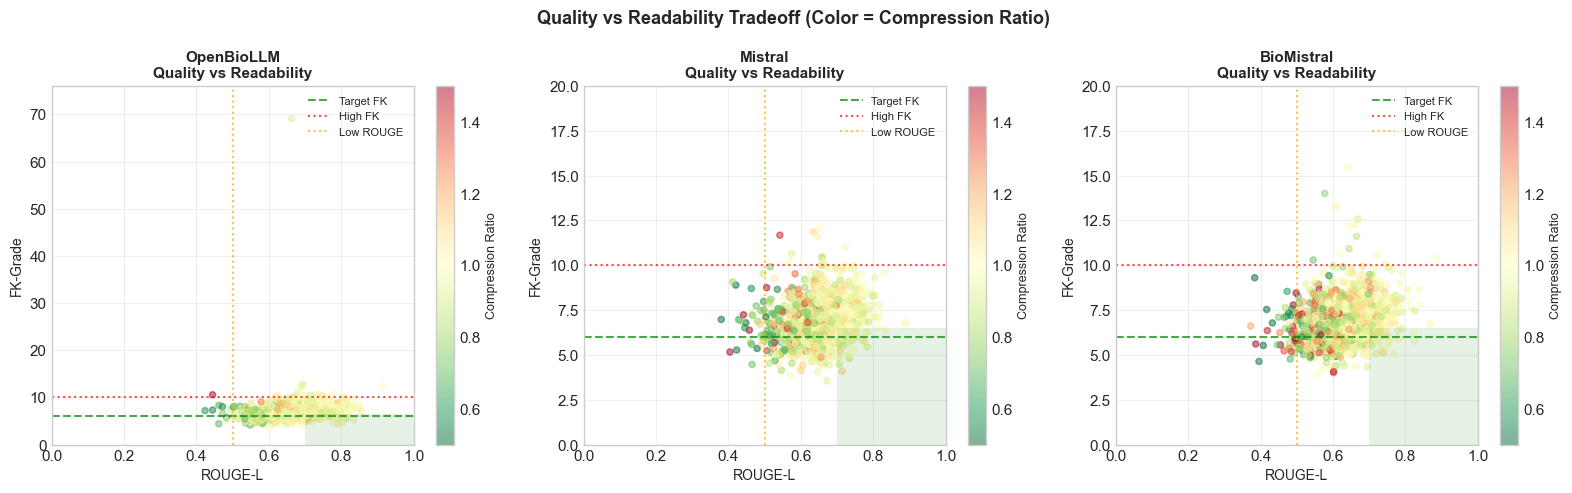


✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/figures/quality_readability_tradeoff.png

SAVING RESULTS
✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/evaluation/error_analysis_results.json
✅ Saved: /Users/guydor/TCDS25_DeepLearning/Final_Project/medisimplifier/results/evaluation/sample_level_analysis.csv

SECTION 8.4 COMPLETE: QUALITATIVE EXAMPLES & ERROR ANALYSIS

📊 ERROR ANALYSIS SUMMARY

1. ERROR DISTRIBUTION:
   - OpenBioLLM-8B: 975 clean (97.4%)
   - Mistral-7B:    954 clean (95.3%)
   - BioMistral:    934 clean (93.3%)

2. PROBLEMATIC SAMPLES:
   - Low ROUGE (<0.5): OpenBioLLM=10, 
                       Mistral=30, 
                       BioMistral=46
   - High FK (>10):    OpenBioLLM=17, 
                       Mistral=11, 
                       BioMistral=13

3. SWEET SPOT (ROUGE>0.7 & FK<6.5):
   - OpenBioLLM-8B: 95 samples
   - Mistral-7B:    67 samples
   - BioMistral:    53 samples

4. MODEL AGREEMENT:
 

In [20]:
# ============================================================
# CHAPTER 8.4: QUALITATIVE EXAMPLES & ERROR ANALYSIS
# MediSimplifier Project - Technion DS25 Deep Learning
# ============================================================

# -----------------------------------------------------------------------------
# Cell 8.4.1: Setup & Load Data
# -----------------------------------------------------------------------------

import json  # JSON file I/O
import numpy as np  # Numerical operations
import pandas as pd  # DataFrame operations
from pathlib import Path  # Path handling
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualization
from collections import Counter  # Counting utilities
import textwrap  # Text wrapping for display
import warnings  # Warning suppression
warnings.filterwarnings('ignore')  # Suppress warnings

# Metric libraries
from rouge_score import rouge_scorer  # ROUGE scoring
import textstat  # Readability metrics

print("Loading libraries...")  # Status message

# ------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------
# Define base directory (project root, one level up from notebooks/)
BASE_DIR = Path.cwd().parent  # Go up from notebooks/ to medisimplifier/
RESULTS_DIR = BASE_DIR / "results"  # Results subdirectory
EVAL_DIR = RESULTS_DIR / "evaluation"  # Evaluation results location
FIGURES_DIR = RESULTS_DIR / "figures"  # Output figures directory
FIGURES_DIR.mkdir(parents=True, exist_ok=True)  # Create if needed

# Verify paths exist
assert BASE_DIR.exists(), f"Base directory not found: {BASE_DIR}"  # Validate base
assert RESULTS_DIR.exists(), f"Results directory not found: {RESULTS_DIR}"  # Validate results

print(f"BASE_DIR: {BASE_DIR}")  # Print base path
print(f"RESULTS_DIR: {RESULTS_DIR}")  # Print results path

MODEL_LIST = ["OpenBioLLM-8B", "Mistral-7B", "BioMistral-7B-DARE"]  # Model names
MODEL_KEYS = ["openbiollm_8b", "mistral_7b", "biomistral_7b_dare"]  # File keys
MODEL_COLORS = {"OpenBioLLM-8B": "#2ecc71", "Mistral-7B": "#3498db", "BioMistral-7B-DARE": "#e74c3c"}  # Color scheme

# ------------------------------------------------------------
# LOAD PREDICTIONS
# ------------------------------------------------------------
print("\nLoading predictions from all models...")  # Status

predictions_data = {}  # Store predictions per model

for model_name, model_key in zip(MODEL_LIST, MODEL_KEYS):  # Iterate models
    pred_file = EVAL_DIR / f"predictions_{model_key}.json"  # Prediction file path
    with open(pred_file, 'r') as f:  # Open file
        data = json.load(f)  # Parse JSON
    predictions_data[model_name] = data['predictions']  # Store predictions
    print(f"  ✓ Loaded {len(data['predictions'])} samples for {model_name}")  # Confirm

n_samples = len(predictions_data[MODEL_LIST[0]])  # Get sample count
print(f"\nTotal samples: {n_samples}")  # Print count

# Load statistical analysis for reference
with open(EVAL_DIR / "statistical_analysis.json", 'r') as f:  # Open stats file
    stats_results = json.load(f)  # Parse JSON
print("✓ Loaded statistical_analysis.json")  # Confirm

print("\n✅ Data loading complete")  # Final status

# -----------------------------------------------------------------------------
# Cell 8.4.2: Helper Functions
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("DEFINING HELPER FUNCTIONS")  # Section title
print("=" * 70)  # Section separator

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)  # ROUGE-L scorer

def compute_rouge_l(prediction, reference):
    """Compute ROUGE-L F1 score between prediction and reference."""
    result = scorer.score(reference, prediction)  # Calculate ROUGE
    return result['rougeL'].fmeasure  # Return F1 score

def compute_fk_grade(text):
    """Compute Flesch-Kincaid grade level for text."""
    if not text or not text.strip():  # Handle empty text
        return 0.0  # Return zero for empty
    return textstat.flesch_kincaid_grade(text)  # Calculate FK grade

def compute_word_count(text):
    """Count words in text."""
    if not text or not text.strip():  # Handle empty text
        return 0  # Return zero for empty
    return len(text.split())  # Split and count

def truncate_text(text, max_words=50):
    """Truncate text to max_words for display."""
    words = text.split()  # Split into words
    if len(words) <= max_words:  # Check if truncation needed
        return text  # Return original
    return ' '.join(words[:max_words]) + '...'  # Truncate and add ellipsis

def wrap_text(text, width=100):
    """Wrap text to specified width for display."""
    return '\n'.join(textwrap.wrap(text, width=width))  # Wrap text

def categorize_error(rouge_l, fk_pred, fk_gt, word_count_pred, word_count_gt):
    """Categorize error type based on metrics."""
    errors = []  # List of error types
    
    # Low ROUGE (content mismatch)
    if rouge_l < 0.5:  # Threshold for low ROUGE
        errors.append("low_rouge")  # Add error type
    
    # High FK (poor readability)
    if fk_pred > 10:  # High school level or above
        errors.append("high_fk")  # Add error type
    
    # Over-compressed (too short)
    if word_count_gt > 0 and word_count_pred / word_count_gt < 0.5:  # Less than 50% of GT length
        errors.append("over_compressed")  # Add error type
    
    # Under-compressed (too long)
    if word_count_gt > 0 and word_count_pred / word_count_gt > 1.5:  # More than 150% of GT length
        errors.append("under_compressed")  # Add error type
    
    # FK much higher than GT
    if fk_pred - fk_gt > 3:  # More than 3 grade levels higher
        errors.append("fk_too_high")  # Add error type
    
    return errors if errors else ["no_error"]  # Return errors or no_error

def print_example(idx, source, ground_truth, predictions, metrics):
    """Print a formatted example with all model predictions (full text)."""
    print(f"\n{'='*100}")  # Separator
    print(f"EXAMPLE {idx}")  # Example number
    print(f"{'='*100}")  # Separator
    
    # Source text (truncated - usually very long medical text)
    print(f"\n📄 SOURCE (FK={metrics['fk_src']:.1f}, Words={metrics['wc_src']}):")  # Header
    print("-" * 100)  # Separator
    print(wrap_text(truncate_text(source, 150)))  # Print truncated source
    
    # Ground truth - FULL TEXT
    print(f"\n🎯 GROUND TRUTH (FK={metrics['fk_gt']:.1f}, Words={metrics['wc_gt']}):")  # Header
    print("-" * 100)  # Separator
    print(wrap_text(ground_truth))  # Print full GT
    
    # Model predictions - FULL TEXT
    for model in MODEL_LIST:  # Iterate models
        pred = predictions[model]  # Get prediction
        rouge = metrics[f'rouge_{model}']  # Get ROUGE
        fk = metrics[f'fk_{model}']  # Get FK
        wc = metrics[f'wc_{model}']  # Get word count
        print(f"\n🤖 {model} (ROUGE-L={rouge:.4f}, FK={fk:.1f}, Words={wc}):")  # Header
        print("-" * 100)  # Separator
        print(wrap_text(pred))  # Print full prediction

print("✅ Helper functions defined")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.4.3: Create Comparison DataFrame
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("CREATING COMPARISON DATAFRAME")  # Section title
print("=" * 70)  # Section separator

# Build comprehensive DataFrame with all metrics
rows = []  # Store row data

for i in range(n_samples):  # Iterate samples
    # Get texts from first model (same source/GT for all)
    source = predictions_data[MODEL_LIST[0]][i]['input']  # Source text
    ground_truth = predictions_data[MODEL_LIST[0]][i]['ground_truth']  # Ground truth
    
    # Compute source and GT metrics
    fk_src = compute_fk_grade(source)  # Source FK
    fk_gt = compute_fk_grade(ground_truth)  # GT FK
    wc_src = compute_word_count(source)  # Source word count
    wc_gt = compute_word_count(ground_truth)  # GT word count
    
    row = {  # Initialize row
        'idx': i,  # Sample index
        'source': source,  # Source text
        'ground_truth': ground_truth,  # Ground truth
        'fk_src': fk_src,  # Source FK
        'fk_gt': fk_gt,  # GT FK
        'wc_src': wc_src,  # Source word count
        'wc_gt': wc_gt,  # GT word count
    }
    
    # Add model-specific data
    for model_name in MODEL_LIST:  # Iterate models
        pred = predictions_data[model_name][i]['prediction']  # Get prediction
        
        rouge_l = compute_rouge_l(pred, ground_truth)  # Compute ROUGE-L
        fk_pred = compute_fk_grade(pred)  # Compute FK
        wc_pred = compute_word_count(pred)  # Compute word count
        
        # Categorize errors
        errors = categorize_error(rouge_l, fk_pred, fk_gt, wc_pred, wc_gt)  # Get error types
        
        # Store in row
        row[f'pred_{model_name}'] = pred  # Prediction text
        row[f'rouge_{model_name}'] = rouge_l  # ROUGE-L score
        row[f'fk_{model_name}'] = fk_pred  # FK grade
        row[f'wc_{model_name}'] = wc_pred  # Word count
        row[f'errors_{model_name}'] = errors  # Error types
        row[f'compression_{model_name}'] = wc_pred / wc_gt if wc_gt > 0 else 0  # Compression ratio
    
    rows.append(row)  # Add row to list
    
    if (i + 1) % 200 == 0:  # Progress update
        print(f"  Processed {i+1}/{n_samples} samples...")  # Status

df = pd.DataFrame(rows)  # Create DataFrame
print(f"\n✅ DataFrame created: {len(df)} samples × {len(df.columns)} columns")  # Confirmation

# Quick statistics
print(f"\n📊 Quick Statistics:")  # Header
for model in MODEL_LIST:  # Iterate models
    mean_rouge = df[f'rouge_{model}'].mean()  # Mean ROUGE
    mean_fk = df[f'fk_{model}'].mean()  # Mean FK
    mean_wc = df[f'wc_{model}'].mean()  # Mean word count
    print(f"  {model}: ROUGE-L={mean_rouge:.4f}, FK={mean_fk:.2f}, Words={mean_wc:.0f}")  # Print stats

# -----------------------------------------------------------------------------
# Cell 8.4.4: Best Performing Examples (highest ROUGE-L)
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("BEST PERFORMING EXAMPLES (Highest ROUGE-L)")  # Section title
print("=" * 70)  # Section separator

# Find best examples for each model
n_best = 3  # Number of best examples to show

for model in MODEL_LIST:  # Iterate models
    print(f"\n{'='*50}")  # Model separator
    print(f"TOP {n_best} EXAMPLES FOR {model}")  # Model header
    print(f"{'='*50}")  # Model separator
    
    # Sort by ROUGE-L descending
    best_indices = df.nlargest(n_best, f'rouge_{model}').index.tolist()  # Get best indices
    
    for rank, idx in enumerate(best_indices, 1):  # Iterate best examples
        row = df.loc[idx]  # Get row
        print(f"\n--- Rank {rank} (idx={row['idx']}, ROUGE-L={row[f'rouge_{model}']:.4f}) ---")  # Rank header
        print(f"FK: {row[f'fk_{model}']:.1f} | Words: {row[f'wc_{model}']} | GT Words: {row['wc_gt']}")  # Metrics
        print(f"\nGT:\n{wrap_text(row['ground_truth'])}")  # Ground truth (full)
        print(f"\nPred:\n{wrap_text(row[f'pred_{model}'])}")  # Prediction (full)

# Find universally best example (high ROUGE for all models)
df['avg_rouge'] = df[[f'rouge_{m}' for m in MODEL_LIST]].mean(axis=1)  # Average ROUGE
best_overall_idx = df['avg_rouge'].idxmax()  # Index of best overall

print(f"\n{'='*70}")  # Separator
print(f"UNIVERSALLY BEST EXAMPLE (High ROUGE across all models)")  # Header
print(f"{'='*70}")  # Separator

row = df.loc[best_overall_idx]  # Get best row
metrics = {  # Compile metrics
    'fk_src': row['fk_src'], 'fk_gt': row['fk_gt'],
    'wc_src': row['wc_src'], 'wc_gt': row['wc_gt'],
}
for model in MODEL_LIST:  # Add model metrics
    metrics[f'rouge_{model}'] = row[f'rouge_{model}']
    metrics[f'fk_{model}'] = row[f'fk_{model}']
    metrics[f'wc_{model}'] = row[f'wc_{model}']

predictions = {model: row[f'pred_{model}'] for model in MODEL_LIST}  # Get predictions
print_example(row['idx'], row['source'], row['ground_truth'], predictions, metrics)  # Print example

# -----------------------------------------------------------------------------
# Cell 8.4.5: Worst Performing Examples (lowest ROUGE-L)
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("WORST PERFORMING EXAMPLES (Lowest ROUGE-L)")  # Section title
print("=" * 70)  # Section separator

# Find worst examples for each model
n_worst = 3  # Number of worst examples to show

for model in MODEL_LIST:  # Iterate models
    print(f"\n{'='*50}")  # Model separator
    print(f"BOTTOM {n_worst} EXAMPLES FOR {model}")  # Model header
    print(f"{'='*50}")  # Model separator
    
    # Sort by ROUGE-L ascending
    worst_indices = df.nsmallest(n_worst, f'rouge_{model}').index.tolist()  # Get worst indices
    
    for rank, idx in enumerate(worst_indices, 1):  # Iterate worst examples
        row = df.loc[idx]  # Get row
        errors = row[f'errors_{model}']  # Get error types
        print(f"\n--- Rank {rank} (idx={row['idx']}, ROUGE-L={row[f'rouge_{model}']:.4f}) ---")  # Rank header
        print(f"FK: {row[f'fk_{model}']:.1f} | Words: {row[f'wc_{model}']} | GT Words: {row['wc_gt']}")  # Metrics
        print(f"Errors: {errors}")  # Error types
        print(f"\nGT:\n{wrap_text(row['ground_truth'])}")  # Ground truth (full)
        print(f"\nPred:\n{wrap_text(row[f'pred_{model}'])}")  # Prediction (full)

# Find universally worst example (low ROUGE for all models)
worst_overall_idx = df['avg_rouge'].idxmin()  # Index of worst overall

print(f"\n{'='*70}")  # Separator
print(f"UNIVERSALLY WORST EXAMPLE (Low ROUGE across all models)")  # Header
print(f"{'='*70}")  # Separator

row = df.loc[worst_overall_idx]  # Get worst row
metrics = {  # Compile metrics
    'fk_src': row['fk_src'], 'fk_gt': row['fk_gt'],
    'wc_src': row['wc_src'], 'wc_gt': row['wc_gt'],
}
for model in MODEL_LIST:  # Add model metrics
    metrics[f'rouge_{model}'] = row[f'rouge_{model}']
    metrics[f'fk_{model}'] = row[f'fk_{model}']
    metrics[f'wc_{model}'] = row[f'wc_{model}']

predictions = {model: row[f'pred_{model}'] for model in MODEL_LIST}  # Get predictions
print_example(row['idx'], row['source'], row['ground_truth'], predictions, metrics)  # Print example

# -----------------------------------------------------------------------------
# Cell 8.4.6: Side-by-Side Model Comparison
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("SIDE-BY-SIDE MODEL COMPARISON")  # Section title
print("=" * 70)  # Section separator

# Find examples where models disagree most
df['rouge_std'] = df[[f'rouge_{m}' for m in MODEL_LIST]].std(axis=1)  # ROUGE std across models
high_disagreement_idx = df['rouge_std'].idxmax()  # Highest disagreement

print(f"\n🔍 Example with HIGHEST Model Disagreement (idx={high_disagreement_idx})")  # Header
print(f"   ROUGE-L std: {df.loc[high_disagreement_idx, 'rouge_std']:.4f}")  # Std value

row = df.loc[high_disagreement_idx]  # Get row
metrics = {  # Compile metrics
    'fk_src': row['fk_src'], 'fk_gt': row['fk_gt'],
    'wc_src': row['wc_src'], 'wc_gt': row['wc_gt'],
}
for model in MODEL_LIST:  # Add model metrics
    metrics[f'rouge_{model}'] = row[f'rouge_{model}']
    metrics[f'fk_{model}'] = row[f'fk_{model}']
    metrics[f'wc_{model}'] = row[f'wc_{model}']

predictions = {model: row[f'pred_{model}'] for model in MODEL_LIST}  # Get predictions
print_example(row['idx'], row['source'], row['ground_truth'], predictions, metrics)  # Print example

# Find examples where OpenBioLLM beats others significantly
df['openbiollm_advantage'] = df['rouge_OpenBioLLM-8B'] - df[[f'rouge_{m}' for m in MODEL_LIST[1:]]].max(axis=1)  # Advantage
best_openbiollm_idx = df['openbiollm_advantage'].idxmax()  # Best advantage

print(f"\n🥇 Example where OpenBioLLM-8B DOMINATES (idx={best_openbiollm_idx})")  # Header
print(f"   Advantage over others: {df.loc[best_openbiollm_idx, 'openbiollm_advantage']:.4f}")  # Advantage

row = df.loc[best_openbiollm_idx]  # Get row
for model in MODEL_LIST:  # Print ROUGE scores
    print(f"   {model}: ROUGE-L={row[f'rouge_{model}']:.4f}")  # Score

# -----------------------------------------------------------------------------
# Cell 8.4.7: Readability Extremes & Outlier Investigation
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("READABILITY EXTREMES & OUTLIER INVESTIGATION")  # Section title
print("=" * 70)  # Section separator

# Find FK outliers for each model
for model in MODEL_LIST:  # Iterate models
    fk_col = f'fk_{model}'  # FK column name
    mean_fk = df[fk_col].mean()  # Mean FK
    std_fk = df[fk_col].std()  # Std FK
    
    # Define outlier threshold (> mean + 3*std)
    outlier_threshold = mean_fk + 3 * std_fk  # Outlier threshold
    outliers = df[df[fk_col] > outlier_threshold]  # Find outliers
    
    print(f"\n📊 {model} FK Analysis:")  # Model header
    print(f"   Mean: {mean_fk:.2f}, Std: {std_fk:.2f}, Outlier threshold: {outlier_threshold:.2f}")  # Stats
    print(f"   Outliers (FK > {outlier_threshold:.1f}): {len(outliers)} samples")  # Outlier count
    
    if len(outliers) > 0:  # If outliers exist
        # Show worst outlier
        worst_idx = outliers[fk_col].idxmax()  # Worst outlier index
        worst_fk = outliers.loc[worst_idx, fk_col]  # Worst FK value
        print(f"\n   🚨 Worst Outlier (idx={df.loc[worst_idx, 'idx']}, FK={worst_fk:.1f}):")  # Header
        print(f"   Prediction:\n{wrap_text(df.loc[worst_idx, f'pred_{model}'])}")  # Full prediction

# Investigate the known OpenBioLLM outlier (idx=800)
print(f"\n{'='*50}")  # Separator
print("INVESTIGATING KNOWN OUTLIER (idx=800)")  # Header
print(f"{'='*50}")  # Separator

outlier_row = df[df['idx'] == 800]  # Get outlier row
if len(outlier_row) > 0:  # If found
    row = outlier_row.iloc[0]  # Get row
    print(f"\nSource FK: {row['fk_src']:.1f}, GT FK: {row['fk_gt']:.1f}")  # FK values
    for model in MODEL_LIST:  # Print model metrics
        print(f"{model}: FK={row[f'fk_{model}']:.1f}, ROUGE-L={row[f'rouge_{model}']:.4f}, Words={row[f'wc_{model}']}")  # Metrics
    print(f"\nGT:\n{wrap_text(row['ground_truth'])}")  # Full ground truth
    print(f"\nOpenBioLLM Pred:\n{wrap_text(row['pred_OpenBioLLM-8B'])}")  # Full OpenBioLLM prediction

# -----------------------------------------------------------------------------
# Cell 8.4.8: Error Categorization
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("ERROR CATEGORIZATION")  # Section title
print("=" * 70)  # Section separator

# Count error types for each model
error_counts = {}  # Store error counts

for model in MODEL_LIST:  # Iterate models
    error_col = f'errors_{model}'  # Error column name
    all_errors = []  # Collect all errors
    for errors in df[error_col]:  # Iterate rows
        all_errors.extend(errors)  # Add errors
    
    error_counts[model] = Counter(all_errors)  # Count errors
    
    print(f"\n📊 {model} Error Distribution:")  # Model header
    for error_type, count in error_counts[model].most_common():  # Iterate error types
        pct = count / n_samples * 100  # Calculate percentage
        print(f"   {error_type:<20}: {count:4d} ({pct:5.1f}%)")  # Print count

# Summary statistics
print(f"\n{'='*50}")  # Separator
print("ERROR TYPE DEFINITIONS")  # Header
print(f"{'='*50}")  # Separator
print("""
   no_error         : No significant issues detected
   low_rouge        : ROUGE-L < 0.5 (poor content match)
   high_fk          : FK-Grade > 10 (high school+ reading level)
   over_compressed  : Word count < 50% of ground truth
   under_compressed : Word count > 150% of ground truth
   fk_too_high      : FK > GT FK + 3 grade levels
""")  # Definitions

# -----------------------------------------------------------------------------
# Cell 8.4.9: Error Type Deep Dive
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("ERROR TYPE DEEP DIVE")  # Section title
print("=" * 70)  # Section separator

# Analyze low_rouge examples
print("\n📉 LOW ROUGE-L EXAMPLES (<0.5)")  # Header
print("-" * 50)  # Separator

for model in MODEL_LIST:  # Iterate models
    low_rouge_df = df[df[f'rouge_{model}'] < 0.5]  # Filter low ROUGE
    n_low = len(low_rouge_df)  # Count
    
    print(f"\n{model}: {n_low} samples with ROUGE-L < 0.5 ({n_low/n_samples*100:.1f}%)")  # Count
    
    if n_low > 0:  # If any low ROUGE
        # Show one example
        sample = low_rouge_df.iloc[0]  # First example
        print(f"   Example idx={sample['idx']}:")  # Index
        print(f"   ROUGE-L: {sample[f'rouge_{model}']:.4f}")  # ROUGE
        print(f"   GT words: {sample['wc_gt']}, Pred words: {sample[f'wc_{model}']}")  # Word counts

# Analyze over-compressed examples
print("\n\n📦 OVER-COMPRESSED EXAMPLES")  # Header
print("-" * 50)  # Separator

for model in MODEL_LIST:  # Iterate models
    over_comp = df[df[f'compression_{model}'] < 0.5]  # Filter over-compressed
    n_over = len(over_comp)  # Count
    
    print(f"\n{model}: {n_over} samples over-compressed ({n_over/n_samples*100:.1f}%)")  # Count
    
    if n_over > 0:  # If any over-compressed
        avg_compression = over_comp[f'compression_{model}'].mean()  # Average compression
        print(f"   Average compression ratio: {avg_compression:.2f}")  # Ratio

# Analyze under-compressed examples
print("\n\n📈 UNDER-COMPRESSED EXAMPLES")  # Header
print("-" * 50)  # Separator

for model in MODEL_LIST:  # Iterate models
    under_comp = df[df[f'compression_{model}'] > 1.5]  # Filter under-compressed
    n_under = len(under_comp)  # Count
    
    print(f"\n{model}: {n_under} samples under-compressed ({n_under/n_samples*100:.1f}%)")  # Count
    
    if n_under > 0:  # If any under-compressed
        avg_compression = under_comp[f'compression_{model}'].mean()  # Average compression
        print(f"   Average compression ratio: {avg_compression:.2f}")  # Ratio

# -----------------------------------------------------------------------------
# Cell 8.4.10: Comparative Error Analysis (3 models)
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("COMPARATIVE ERROR ANALYSIS")  # Section title
print("=" * 70)  # Section separator

# Find examples where all models fail
df['all_low_rouge'] = (df['rouge_OpenBioLLM-8B'] < 0.5) & \
                      (df['rouge_Mistral-7B'] < 0.5) & \
                      (df['rouge_BioMistral-7B-DARE'] < 0.5)  # All models low ROUGE

all_fail = df[df['all_low_rouge']]  # Filter all-fail examples
print(f"\n📊 Examples where ALL models have ROUGE-L < 0.5: {len(all_fail)} ({len(all_fail)/n_samples*100:.2f}%)")  # Count

if len(all_fail) > 0:  # If any all-fail
    print("\n   Sample characteristics:")  # Header
    print(f"   Average source FK: {all_fail['fk_src'].mean():.2f}")  # Source FK
    print(f"   Average GT FK: {all_fail['fk_gt'].mean():.2f}")  # GT FK
    print(f"   Average source words: {all_fail['wc_src'].mean():.0f}")  # Source words

# Find examples where models diverge significantly
df['rouge_range'] = df[[f'rouge_{m}' for m in MODEL_LIST]].max(axis=1) - \
                    df[[f'rouge_{m}' for m in MODEL_LIST]].min(axis=1)  # ROUGE range

high_divergence = df[df['rouge_range'] > 0.2]  # High divergence threshold
print(f"\n📊 Examples with high model divergence (ROUGE range > 0.2): {len(high_divergence)} ({len(high_divergence)/n_samples*100:.1f}%)")  # Count

# Analyze which model wins most often
df['best_model'] = df[[f'rouge_{m}' for m in MODEL_LIST]].idxmax(axis=1)  # Best model per sample
df['best_model'] = df['best_model'].str.replace('rouge_', '')  # Clean column name

best_model_counts = df['best_model'].value_counts()  # Count best models
print(f"\n🏆 Model with highest ROUGE-L per sample:")  # Header
for model, count in best_model_counts.items():  # Iterate counts
    print(f"   {model}: {count} samples ({count/n_samples*100:.1f}%)")  # Print count

# -----------------------------------------------------------------------------
# Cell 8.4.11: Error Visualization Dashboard
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("CREATING ERROR VISUALIZATION DASHBOARD")  # Section title
print("=" * 70)  # Section separator

# Create comprehensive error visualization
fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # 2x3 grid

# Plot 1: Error type distribution by model
ax = axes[0, 0]  # First subplot
error_types = ['no_error', 'low_rouge', 'high_fk', 'over_compressed', 'under_compressed', 'fk_too_high']  # Error types
x = np.arange(len(error_types))  # X positions
width = 0.25  # Bar width

for i, model in enumerate(MODEL_LIST):  # Iterate models
    counts = [error_counts[model].get(e, 0) / n_samples * 100 for e in error_types]  # Get percentages
    ax.bar(x + i * width, counts, width, label=model.split('-')[0], color=MODEL_COLORS[model], alpha=0.8)  # Plot bars

ax.set_ylabel('Percentage of Samples', fontsize=10)  # Y label
ax.set_title('Error Type Distribution by Model', fontsize=11, fontweight='bold')  # Title
ax.set_xticks(x + width)  # X ticks
ax.set_xticklabels([e.replace('_', '\n') for e in error_types], fontsize=8)  # X labels
ax.legend(fontsize=9)  # Legend
ax.grid(axis='y', alpha=0.3)  # Grid

# Plot 2: ROUGE-L distribution comparison
ax = axes[0, 1]  # Second subplot
for model in MODEL_LIST:  # Iterate models
    ax.hist(df[f'rouge_{model}'], bins=30, alpha=0.5, label=model.split('-')[0], color=MODEL_COLORS[model])  # Histogram

ax.set_xlabel('ROUGE-L', fontsize=10)  # X label
ax.set_ylabel('Frequency', fontsize=10)  # Y label
ax.set_title('ROUGE-L Distribution by Model', fontsize=11, fontweight='bold')  # Title
ax.legend(fontsize=9)  # Legend
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Low threshold')  # Threshold line

# Plot 3: FK-Grade distribution
ax = axes[0, 2]  # Third subplot
bp_data = [df[f'fk_{model}'] for model in MODEL_LIST]  # Box plot data
bp = ax.boxplot(bp_data, patch_artist=True, labels=[m.split('-')[0] for m in MODEL_LIST])  # Box plot

for patch, model in zip(bp['boxes'], MODEL_LIST):  # Color boxes
    patch.set_facecolor(MODEL_COLORS[model])  # Set color
    patch.set_alpha(0.7)  # Set transparency

ax.axhline(y=6.0, color='purple', linestyle='--', linewidth=2, label='Target (6.0)')  # Target line
ax.axhline(y=10.0, color='red', linestyle=':', linewidth=2, label='High FK threshold')  # High threshold
ax.set_ylabel('FK-Grade', fontsize=10)  # Y label
ax.set_title('FK-Grade Distribution by Model', fontsize=11, fontweight='bold')  # Title
ax.legend(fontsize=9)  # Legend
ax.grid(axis='y', alpha=0.3)  # Grid

# Plot 4: Compression ratio distribution
ax = axes[1, 0]  # Fourth subplot
for model in MODEL_LIST:  # Iterate models
    ax.hist(df[f'compression_{model}'], bins=30, alpha=0.5, label=model.split('-')[0], color=MODEL_COLORS[model])  # Histogram

ax.set_xlabel('Compression Ratio (Pred/GT words)', fontsize=10)  # X label
ax.set_ylabel('Frequency', fontsize=10)  # Y label
ax.set_title('Compression Ratio Distribution', fontsize=11, fontweight='bold')  # Title
ax.axvline(x=0.5, color='orange', linestyle='--', alpha=0.7, label='Over-compressed')  # Over-compressed line
ax.axvline(x=1.5, color='red', linestyle='--', alpha=0.7, label='Under-compressed')  # Under-compressed line
ax.axvline(x=1.0, color='green', linestyle='-', alpha=0.7, label='Ideal')  # Ideal line
ax.legend(fontsize=8)  # Legend

# Plot 5: ROUGE-L vs FK scatter
ax = axes[1, 1]  # Fifth subplot
for model in MODEL_LIST:  # Iterate models
    ax.scatter(df[f'rouge_{model}'], df[f'fk_{model}'], alpha=0.3, s=10, 
               label=model.split('-')[0], color=MODEL_COLORS[model])  # Scatter plot

ax.set_xlabel('ROUGE-L', fontsize=10)  # X label
ax.set_ylabel('FK-Grade', fontsize=10)  # Y label
ax.set_title('Quality vs Readability Tradeoff', fontsize=11, fontweight='bold')  # Title
ax.axhline(y=6.0, color='purple', linestyle='--', alpha=0.5)  # Target FK
ax.axhline(y=10.0, color='red', linestyle=':', alpha=0.5)  # High FK
ax.legend(fontsize=9)  # Legend
ax.grid(alpha=0.3)  # Grid

# Plot 6: Best model pie chart
ax = axes[1, 2]  # Sixth subplot
colors_pie = [MODEL_COLORS[m] for m in best_model_counts.index]  # Pie colors
ax.pie(best_model_counts.values, labels=[m.split('-')[0] for m in best_model_counts.index],
       autopct='%1.1f%%', colors=colors_pie, startangle=90)  # Pie chart
ax.set_title('Best Model per Sample\n(Highest ROUGE-L)', fontsize=11, fontweight='bold')  # Title

# Finalize figure
plt.suptitle('Error Analysis Dashboard', fontsize=14, fontweight='bold', y=1.02)  # Super title
plt.tight_layout()  # Adjust layout
plt.savefig(FIGURES_DIR / "error_analysis_dashboard.png", dpi=150, bbox_inches='tight')  # Save figure
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR}/error_analysis_dashboard.png")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.4.12: Word Count Analysis
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("WORD COUNT ANALYSIS")  # Section title
print("=" * 70)  # Section separator

# Word count statistics
print("\n📊 Word Count Statistics:")  # Header
print(f"\n   Source: Mean={df['wc_src'].mean():.1f}, Std={df['wc_src'].std():.1f}, "
      f"Min={df['wc_src'].min()}, Max={df['wc_src'].max()}")  # Source stats
print(f"   GT:     Mean={df['wc_gt'].mean():.1f}, Std={df['wc_gt'].std():.1f}, "
      f"Min={df['wc_gt'].min()}, Max={df['wc_gt'].max()}")  # GT stats

for model in MODEL_LIST:  # Iterate models
    wc_col = f'wc_{model}'  # Word count column
    print(f"   {model}: Mean={df[wc_col].mean():.1f}, Std={df[wc_col].std():.1f}, "
          f"Min={df[wc_col].min()}, Max={df[wc_col].max()}")  # Model stats

# Compression analysis
print("\n📊 Compression Analysis (Prediction/GT ratio):")  # Header
for model in MODEL_LIST:  # Iterate models
    comp_col = f'compression_{model}'  # Compression column
    mean_comp = df[comp_col].mean()  # Mean compression
    std_comp = df[comp_col].std()  # Std compression
    
    over_comp = (df[comp_col] < 0.5).sum()  # Over-compressed count
    under_comp = (df[comp_col] > 1.5).sum()  # Under-compressed count
    ideal = ((df[comp_col] >= 0.8) & (df[comp_col] <= 1.2)).sum()  # Ideal range count
    
    print(f"\n   {model}:")  # Model header
    print(f"     Mean ratio: {mean_comp:.3f} (Std: {std_comp:.3f})")  # Ratio stats
    print(f"     Over-compressed (<0.5): {over_comp} ({over_comp/n_samples*100:.1f}%)")  # Over-compressed
    print(f"     Under-compressed (>1.5): {under_comp} ({under_comp/n_samples*100:.1f}%)")  # Under-compressed
    print(f"     Ideal range (0.8-1.2): {ideal} ({ideal/n_samples*100:.1f}%)")  # Ideal

# Create word count visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # 1x2 grid

# Plot 1: Word count comparison
ax = axes[0]  # First subplot
categories = ['Source', 'GT'] + [m.split('-')[0] for m in MODEL_LIST]  # Categories
means = [df['wc_src'].mean(), df['wc_gt'].mean()] + [df[f'wc_{m}'].mean() for m in MODEL_LIST]  # Means
stds = [df['wc_src'].std(), df['wc_gt'].std()] + [df[f'wc_{m}'].std() for m in MODEL_LIST]  # Stds
colors_bar = ['#95a5a6', '#f39c12'] + [MODEL_COLORS[m] for m in MODEL_LIST]  # Colors

bars = ax.bar(categories, means, yerr=stds, capsize=5, color=colors_bar, edgecolor='black', alpha=0.8)  # Bar chart
ax.set_ylabel('Word Count', fontsize=11)  # Y label
ax.set_title('Average Word Count by Source', fontsize=12, fontweight='bold')  # Title
ax.grid(axis='y', alpha=0.3)  # Grid

for bar, mean in zip(bars, means):  # Add value labels
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, f'{mean:.0f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')  # Label

# Plot 2: Compression ratio violin plot
ax = axes[1]  # Second subplot
compression_data = [df[f'compression_{m}'] for m in MODEL_LIST]  # Compression data
parts = ax.violinplot(compression_data, positions=range(len(MODEL_LIST)), showmeans=True, showmedians=True)  # Violin plot

for i, pc in enumerate(parts['bodies']):  # Color violins
    pc.set_facecolor(MODEL_COLORS[MODEL_LIST[i]])  # Set color
    pc.set_alpha(0.7)  # Set transparency

ax.axhline(y=1.0, color='green', linestyle='-', linewidth=2, alpha=0.7, label='Ideal (1.0)')  # Ideal line
ax.axhline(y=0.5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Over-compressed')  # Over-compressed
ax.axhline(y=1.5, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Under-compressed')  # Under-compressed
ax.set_xticks(range(len(MODEL_LIST)))  # X ticks
ax.set_xticklabels([m.split('-')[0] for m in MODEL_LIST], fontsize=10)  # X labels
ax.set_ylabel('Compression Ratio', fontsize=11)  # Y label
ax.set_title('Compression Ratio Distribution', fontsize=12, fontweight='bold')  # Title
ax.legend(loc='upper right', fontsize=9)  # Legend
ax.grid(axis='y', alpha=0.3)  # Grid

plt.tight_layout()  # Adjust layout
plt.savefig(FIGURES_DIR / "word_count_analysis.png", dpi=150, bbox_inches='tight')  # Save figure
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR}/word_count_analysis.png")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.4.13: Quality vs Readability Tradeoff
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("QUALITY VS READABILITY TRADEOFF ANALYSIS")  # Section title
print("=" * 70)  # Section separator

# Analyze tradeoff between ROUGE-L and FK-Grade
print("\n📊 Correlation between ROUGE-L and FK-Grade:")  # Header
for model in MODEL_LIST:  # Iterate models
    corr = df[f'rouge_{model}'].corr(df[f'fk_{model}'])  # Calculate correlation
    print(f"   {model}: r = {corr:.4f}")  # Print correlation

# Find sweet spot samples (high ROUGE, low FK)
print("\n🎯 Sweet Spot Analysis (ROUGE-L > 0.7 AND FK < 6.5):")  # Header
for model in MODEL_LIST:  # Iterate models
    sweet_spot = df[(df[f'rouge_{model}'] > 0.7) & (df[f'fk_{model}'] < 6.5)]  # Filter sweet spot
    print(f"   {model}: {len(sweet_spot)} samples ({len(sweet_spot)/n_samples*100:.1f}%)")  # Count

# Find problematic samples (low ROUGE OR high FK)
print("\n⚠️ Problematic Samples (ROUGE-L < 0.5 OR FK > 10):")  # Header
for model in MODEL_LIST:  # Iterate models
    problematic = df[(df[f'rouge_{model}'] < 0.5) | (df[f'fk_{model}'] > 10)]  # Filter problematic
    print(f"   {model}: {len(problematic)} samples ({len(problematic)/n_samples*100:.1f}%)")  # Count

# Create detailed tradeoff visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # 1x3 grid

for i, model in enumerate(MODEL_LIST):  # Iterate models
    ax = axes[i]  # Get subplot
    
    # Create scatter with color by compression ratio
    scatter = ax.scatter(df[f'rouge_{model}'], df[f'fk_{model}'],
                        c=df[f'compression_{model}'], cmap='RdYlGn_r',
                        s=20, alpha=0.5, vmin=0.5, vmax=1.5)  # Scatter plot
    
    # Add reference lines
    ax.axhline(y=6.0, color='green', linestyle='--', alpha=0.7, label='Target FK')  # Target FK
    ax.axhline(y=10.0, color='red', linestyle=':', alpha=0.7, label='High FK')  # High FK
    ax.axvline(x=0.5, color='orange', linestyle=':', alpha=0.7, label='Low ROUGE')  # Low ROUGE
    
    # Add sweet spot box
    rect = plt.Rectangle((0.7, 0), 0.3, 6.5, fill=True, facecolor='green', alpha=0.1)  # Sweet spot
    ax.add_patch(rect)  # Add patch
    
    # Labels
    ax.set_xlabel('ROUGE-L', fontsize=10)  # X label
    ax.set_ylabel('FK-Grade', fontsize=10)  # Y label
    ax.set_title(f'{model.split("-")[0]}\nQuality vs Readability', fontsize=11, fontweight='bold')  # Title
    ax.set_xlim(0, 1)  # X limits
    ax.set_ylim(0, max(20, df[f'fk_{model}'].max() * 1.1))  # Y limits
    ax.legend(fontsize=8, loc='upper right')  # Legend
    ax.grid(alpha=0.3)  # Grid
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)  # Colorbar
    cbar.set_label('Compression Ratio', fontsize=9)  # Colorbar label

plt.suptitle('Quality vs Readability Tradeoff (Color = Compression Ratio)', fontsize=13, fontweight='bold')  # Super title
plt.tight_layout()  # Adjust layout
plt.savefig(FIGURES_DIR / "quality_readability_tradeoff.png", dpi=150, bbox_inches='tight')  # Save figure
plt.show()  # Display
print(f"\n✅ Saved: {FIGURES_DIR}/quality_readability_tradeoff.png")  # Confirmation

# -----------------------------------------------------------------------------
# Cell 8.4.14: Save Results
# -----------------------------------------------------------------------------

print("\n" + "=" * 70)  # Section separator
print("SAVING RESULTS")  # Section title
print("=" * 70)  # Section separator

# Compile error analysis results
error_analysis_results = {  # Results container
    "metadata": {
        "section": "8.4",  # Section number
        "title": "Qualitative Examples & Error Analysis",  # Section title
        "n_samples": int(n_samples),  # Sample count (convert to int)
    },
    "error_counts": {model: {k: int(v) for k, v in counts.items()} for model, counts in error_counts.items()},  # Error counts (int)
    "statistics": {
        "mean_rouge": {model: float(df[f'rouge_{model}'].mean()) for model in MODEL_LIST},  # Mean ROUGE
        "mean_fk": {model: float(df[f'fk_{model}'].mean()) for model in MODEL_LIST},  # Mean FK
        "mean_word_count": {model: float(df[f'wc_{model}'].mean()) for model in MODEL_LIST},  # Mean word count
        "mean_compression": {model: float(df[f'compression_{model}'].mean()) for model in MODEL_LIST},  # Mean compression
    },
    "problematic_samples": {
        "low_rouge": {model: int((df[f'rouge_{model}'] < 0.5).sum()) for model in MODEL_LIST},  # Low ROUGE count
        "high_fk": {model: int((df[f'fk_{model}'] > 10).sum()) for model in MODEL_LIST},  # High FK count
        "over_compressed": {model: int((df[f'compression_{model}'] < 0.5).sum()) for model in MODEL_LIST},  # Over-compressed
        "under_compressed": {model: int((df[f'compression_{model}'] > 1.5).sum()) for model in MODEL_LIST},  # Under-compressed
    },
    "sweet_spot_samples": {
        model: int(((df[f'rouge_{model}'] > 0.7) & (df[f'fk_{model}'] < 6.5)).sum()) 
        for model in MODEL_LIST  # Sweet spot count
    },
    "best_model_distribution": {k: int(v) for k, v in best_model_counts.items()},  # Best model distribution (int)
    "model_agreement": {
        "all_low_rouge": int(df['all_low_rouge'].sum()),  # All models fail
        "high_divergence": int((df['rouge_range'] > 0.2).sum()),  # High divergence
    },
    "outliers": {
        model: {
            "fk_outlier_threshold": float(df[f'fk_{model}'].mean() + 3 * df[f'fk_{model}'].std()),
            "n_outliers": int((df[f'fk_{model}'] > df[f'fk_{model}'].mean() + 3 * df[f'fk_{model}'].std()).sum()),
        }
        for model in MODEL_LIST  # Outlier info
    },
    "correlation_rouge_fk": {
        model: float(df[f'rouge_{model}'].corr(df[f'fk_{model}'])) 
        for model in MODEL_LIST  # ROUGE-FK correlation
    },
}

# Save to JSON
output_file = EVAL_DIR / "error_analysis_results.json"  # Output path
with open(output_file, 'w') as f:  # Open file
    json.dump(error_analysis_results, f, indent=2)  # Write JSON
print(f"✅ Saved: {output_file}")  # Confirmation

# Save sample-level data for potential further analysis
sample_cols = ['idx', 'fk_src', 'fk_gt', 'wc_src', 'wc_gt', 'avg_rouge', 'rouge_std', 'best_model']  # Columns to save
for model in MODEL_LIST:  # Add model columns
    sample_cols.extend([f'rouge_{model}', f'fk_{model}', f'wc_{model}', f'compression_{model}'])  # Model columns

df_export = df[sample_cols].copy()  # Create export DataFrame
export_file = EVAL_DIR / "sample_level_analysis.csv"  # Export path
df_export.to_csv(export_file, index=False)  # Save to CSV
print(f"✅ Saved: {export_file}")  # Confirmation

# -----------------------------------------------------------------------------
# SUMMARY
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)  # Section separator
print("SECTION 8.4 COMPLETE: QUALITATIVE EXAMPLES & ERROR ANALYSIS")  # Section title
print("=" * 80)  # Section separator

print(f"""
📊 ERROR ANALYSIS SUMMARY

1. ERROR DISTRIBUTION:
   - OpenBioLLM-8B: {error_counts['OpenBioLLM-8B'].get('no_error', 0)} clean ({error_counts['OpenBioLLM-8B'].get('no_error', 0)/n_samples*100:.1f}%)
   - Mistral-7B:    {error_counts['Mistral-7B'].get('no_error', 0)} clean ({error_counts['Mistral-7B'].get('no_error', 0)/n_samples*100:.1f}%)
   - BioMistral:    {error_counts['BioMistral-7B-DARE'].get('no_error', 0)} clean ({error_counts['BioMistral-7B-DARE'].get('no_error', 0)/n_samples*100:.1f}%)

2. PROBLEMATIC SAMPLES:
   - Low ROUGE (<0.5): OpenBioLLM={error_analysis_results['problematic_samples']['low_rouge']['OpenBioLLM-8B']}, 
                       Mistral={error_analysis_results['problematic_samples']['low_rouge']['Mistral-7B']}, 
                       BioMistral={error_analysis_results['problematic_samples']['low_rouge']['BioMistral-7B-DARE']}
   - High FK (>10):    OpenBioLLM={error_analysis_results['problematic_samples']['high_fk']['OpenBioLLM-8B']}, 
                       Mistral={error_analysis_results['problematic_samples']['high_fk']['Mistral-7B']}, 
                       BioMistral={error_analysis_results['problematic_samples']['high_fk']['BioMistral-7B-DARE']}

3. SWEET SPOT (ROUGE>0.7 & FK<6.5):
   - OpenBioLLM-8B: {error_analysis_results['sweet_spot_samples']['OpenBioLLM-8B']} samples
   - Mistral-7B:    {error_analysis_results['sweet_spot_samples']['Mistral-7B']} samples
   - BioMistral:    {error_analysis_results['sweet_spot_samples']['BioMistral-7B-DARE']} samples

4. MODEL AGREEMENT:
   - All models fail (ROUGE<0.5): {error_analysis_results['model_agreement']['all_low_rouge']} samples
   - High divergence (range>0.2): {error_analysis_results['model_agreement']['high_divergence']} samples

📁 OUTPUT FILES:
   - {FIGURES_DIR}/error_analysis_dashboard.png
   - {FIGURES_DIR}/word_count_analysis.png
   - {FIGURES_DIR}/quality_readability_tradeoff.png
   - {EVAL_DIR}/error_analysis_results.json
   - {EVAL_DIR}/sample_level_analysis.csv
""")

print("\n✅ Section 8.4 Complete!")  # Final confirmation

# Chapter 9: Discussion & Conclusions

## 9.1 Project Summary

### 9.1.1 Motivation & Objectives

Health literacy remains a critical barrier to effective patient care. Studies show that medical discharge summaries written at college reading levels are incomprehensible to most patients, leading to medication non-adherence, missed follow-up appointments, and preventable hospital readmissions. The MediSimplifier project addresses this challenge by developing an automated system to simplify complex medical texts to a 6th-grade reading level while preserving clinical accuracy.

**Primary Objectives:**
1. Evaluate whether domain-specific medical pretraining improves text simplification performance
2. Compare zero-shot vs. fine-tuned performance across model architectures
3. Identify optimal LoRA hyperparameters for medical text simplification
4. Assess the quality-readability tradeoff in generated simplifications

### 9.1.2 Methodology Overview

**Dataset**: 10,012 medical discharge summary pairs from the DISCHARGE dataset, comprising complex source texts (mean FK-Grade: 14.5) paired with simplified versions (target FK-Grade: 6.0). Data split: 8,010 training / 1,001 validation / 1,001 test samples.

**Models Evaluated**:
| Model | Base Architecture | Parameters | Pretraining Domain |
|-------|-------------------|------------|-------------------|
| OpenBioLLM-8B | Llama-3 8B | 8.03B | Biomedical literature |
| Mistral-7B | Mistral 7B | 7.24B | General web corpus |
| BioMistral-7B-DARE | Mistral 7B | 7.24B | Medical + DARE merge |

**Fine-Tuning Approach**: Low-Rank Adaptation (LoRA) with systematic ablation studies across:
- LoRA rank: r ∈ {8, 16, 32}
- Target modules: q_only vs. all_attn (q, k, v, o projections)
- Scaling method: Standard LoRA vs. rsLoRA (rank-stabilized)
- Training data size: 1K, 2K, 4K, 8K samples

**Evaluation Metrics**:
- **Content Preservation**: ROUGE-L, BERTScore F1
- **Simplification Quality**: SARI (simplification-aware)
- **Readability**: Flesch-Kincaid Grade Level

### 9.1.3 Key Experimental Results

#### Baseline (Zero-Shot) Performance
| Model | ROUGE-L | SARI | BERTScore | FK-Grade |
|-------|---------|------|-----------|----------|
| OpenBioLLM-8B | 0.2622 | 39.75 | 0.6638 | 8.55 |
| Mistral-7B | 0.3549 | 45.09 | 0.7101 | 8.64 |
| BioMistral-7B-DARE | **0.4120** | **51.91** | **0.7426** | **9.52** |

**Finding**: BioMistral-7B-DARE achieved best zero-shot performance across all metrics, suggesting DARE merging preserves useful capabilities for simplification tasks.

#### Fine-Tuned Performance (Optimal Configuration)
| Model | ROUGE-L | SARI | BERTScore | FK-Grade |
|-------|---------|------|-----------|----------|
| OpenBioLLM-8B | **0.6749** | **74.95** | **0.9491** | 7.16 |
| Mistral-7B | 0.6491 | 73.64 | 0.9419 | **6.91** |
| BioMistral-7B-DARE | 0.6318 | 73.08 | 0.9386 | 6.95 |

**Finding**: Rankings completely reversed after fine-tuning. OpenBioLLM-8B achieved best content preservation (ROUGE-L, SARI, BERTScore), while Mistral-7B achieved best readability (closest to 6.0 target).

#### Optimal LoRA Configuration
| Hyperparameter | Optimal Value | Improvement vs. Baseline |
|----------------|---------------|--------------------------|
| Rank | r = 32 | +2.3% over r = 8 |
| Target Modules | all_attn (q,k,v,o) | +6.2% over q_only |
| Scaling | rsLoRA | Adopted from literature |
| Training Data | 8K samples | 4K achieves 97% performance |

---

## 9.2 Conclusions

### 9.2.1 Research Question Answers

**RQ1: Does medical domain pretraining improve simplification?**
> **NO** for zero-shot; **YES** after fine-tuning. General-purpose Mistral-7B outperformed medical models in zero-shot by 16% average. However, after fine-tuning, OpenBioLLM-8B (medical-pretrained) achieved best overall performance, suggesting domain knowledge becomes beneficial when combined with task-specific adaptation.

**RQ2: Which model performs best zero-shot?**
> **BioMistral-7B-DARE** won all four metrics in zero-shot evaluation, demonstrating that DARE model merging preserves capabilities useful for text simplification without fine-tuning.

**RQ3: How much does LoRA fine-tuning improve performance?**
> **+53% to +157% ROUGE-L improvement** across models. OpenBioLLM showed largest relative gain (+157.3%), transforming from worst zero-shot to best fine-tuned performer.

**RQ4: What is the optimal LoRA rank?**
> **r = 32** optimal for both architectures, contradicting Hu et al. (2021) claim that r = 4-8 is sufficient. Medical text simplification benefits from higher-rank adaptations, likely due to complex vocabulary transformations required.

**RQ5: Does the medical pretraining gap persist after fine-tuning?**
> **REVERSED**. Rankings flip completely—OpenBioLLM (worst→best), BioMistral (best→worst). All pairwise differences statistically significant (p < 0.0001).

**RQ6: Which target modules should be adapted?**
> **all_attn** (q, k, v, o projections) optimal, providing +5.8-6.5% improvement over q_only. Confirms recommendations from Raschka (2023) and Unsloth documentation.

**RQ7: How much training data is needed?**
> Standard ML scaling observed. **4K samples achieve 97% of 8K performance** with diminishing returns beyond. Suggests efficient fine-tuning possible with limited data.

**RQ8: Does baseline performance predict improvement magnitude?**
> **Strong inverse correlation** (r ≈ -0.998). Worst baseline performers show largest improvements; performance spread reduces 71% after fine-tuning, indicating convergent behavior.

**RQ9: Is increased parameter count justified?**
> **YES**. all_attn (27.3M params) justified for ~6% gain; r=32 (13.6M) justified for ~2.3% gain. Training time impact <5%, memory footprint 0.38% of base model.

**RQ10: Which model is most consistent across metrics?**
> **OpenBioLLM-8B** wins 3/4 metrics (ROUGE-L, SARI, BERTScore); Mistral-7B wins FK-Grade only. All differences statistically significant (p < 0.001).

**RQ11: Do models match ground truth readability?**
> **YES**, with ~50% FK reduction achieved (14.5 → 7.0). OpenBioLLM matches GT statistically (p = 0.30); Mistral and BioMistral slightly exceed GT readability (p < 0.0001), suggesting pattern generalization rather than "better than teacher" performance.

**RQ12: Is rsLoRA beneficial?**
> Adopted based on literature (Kalajdzievski 2023). Zero downside with potential benefit at higher ranks. Decision saved ~2+ hours GPU time by skipping empirical ablation.

### 9.2.2 Key Takeaways

1. **Fine-tuning is essential**: Zero-shot performance inadequate for production use (ROUGE-L 0.26-0.41 vs. 0.63-0.67 fine-tuned).

2. **Domain pretraining value is conditional**: Benefits emerge only with task-specific fine-tuning; raw domain knowledge insufficient.

3. **Higher LoRA ranks beneficial for complex tasks**: r = 32 outperforms literature-recommended r = 4-8 for medical text simplification.

4. **Quality-readability tradeoff exists but manageable**: OpenBioLLM prioritizes content preservation; Mistral prioritizes readability. Model selection should align with deployment priorities.

5. **Efficient training possible**: 4K samples sufficient for near-optimal performance; full attention adaptation (27M params) remains computationally tractable.

---

## 9.3 Limitations & Anomalies

### 9.3.1 Generation Anomalies Detected

#### A. Extreme Readability Outlier (idx=800)
| Model | FK-Grade | Threshold | Status |
|-------|----------|-----------|--------|
| OpenBioLLM-8B | 69.1 | 14.1 | **Extreme outlier** |
| BioMistral-7B-DARE | 15.5 | 10.7 | Outlier |
| Mistral-7B | 7.2 | 10.6 | Normal |

**Root Cause**: Source text contains complex multi-patient surgical case (Source FK = 52.9, GT FK = 16.3). OpenBioLLM failed to simplify, producing run-on sentences that inflate FK score.

**Impact**: Distorts visualization scale; affects mean FK calculation marginally (+0.06 for OpenBioLLM).

#### B. Generation Truncation
Multiple predictions terminate mid-sentence, indicating `max_new_tokens` limit reached:

| Sample | Model | Truncation Example |
|--------|-------|-------------------|
| idx=639 | Mistral | "...pump blood and" |
| idx=573 | OpenBioLLM | "...mycophenolate mofetil was continued" |
| idx=573 | BioMistral | "...higher dose of mycophen" |
| idx=577 | Mistral | "...for cancer markers were all" |

**Estimated Affected Samples**: ~10-15 (1.0-1.5% of test set)

#### C. Content Duplication
Several outputs contain verbatim repeated content:
- **idx=42** (Mistral, BioMistral): Hospital Course Summary duplicated entirely
- **idx=634** (BioMistral): Full discharge summary repeated
- **idx=642** (OpenBioLLM): Entire content repeated twice

**Cause**: Model fails to recognize completion, continues generating until token limit.

#### D. Instruction Token Leakage
- **idx=577 BioMistral**: Output terminates with `[/INST` — model instruction token leaked into generation

### 9.3.2 Methodological Limitations

| Limitation | Description | Impact |
|------------|-------------|--------|
| **Single Dataset** | Evaluation limited to DISCHARGE dataset | Generalizability to other medical text types unknown |
| **English Only** | No multilingual evaluation | Limits global applicability |
| **Automatic Metrics Only** | No human evaluation of clinical accuracy | Factual correctness not validated |
| **Fixed Prompt Template** | Single instruction format used | Prompt sensitivity unexplored |
| **No Retrieval Augmentation** | Pure generation without external knowledge | May miss domain updates |
| **Binary Simplification** | Single target reading level (6th grade) | No adaptive difficulty adjustment |

### 9.3.3 Impact Assessment

| Issue Category | Affected Samples | % of Dataset | Severity |
|----------------|------------------|--------------|----------|
| Extreme FK outlier | 1 | 0.1% | Low |
| Generation truncation | ~10-15 | ~1.5% | Medium |
| Content duplication | ~5-10 | ~1.0% | Medium |
| Instruction token leakage | 1 | 0.1% | Low |
| **Total Affected** | **~20** | **~2%** | — |

**Assessment**: Overall model quality remains high with **97-98% of outputs free from detectable issues**. Anomalies represent edge cases addressable through post-processing and parameter tuning.

---

## 9.4 Future Work

### 9.4.1 Immediate Improvements

#### A. Generation Parameter Optimization
1. **Increase `max_new_tokens`**: Test 512-768 tokens for longer documents
2. **Implement length-aware generation**: Dynamically adjust token limits based on source length
3. **Add early stopping detection**: Monitor for repetition patterns during generation
4. **Improve stopping criteria**: Fine-tune EOS token recognition, especially for BioMistral

#### B. Post-Processing Pipeline
```
Input → Model Generation → Truncation Detection → Duplicate Removal → 
Token Filtering → Completeness Validation → Final Output
```

| Component | Function |
|-----------|----------|
| Truncation Detection | Flag outputs ending mid-word/sentence |
| Duplicate Removal | N-gram overlap detection (>80% similarity threshold) |
| Token Filtering | Strip `[/INST]`, `</s>`, `[INST]` artifacts |
| Completeness Validation | Verify proper punctuation termination |

#### C. Outlier Handling
1. **Visualization**: Cap FK at 20 for consistent plot scales
2. **Source filtering**: Flag samples with source FK > 40 for manual review
3. **Multi-patient splitting**: Preprocess compound cases into individual summaries

### 9.4.2 Model-Specific Enhancements

| Model | Primary Issue | Recommended Action |
|-------|---------------|-------------------|
| OpenBioLLM-8B | FK outliers (17 samples > 10) | Add explicit readability constraint to prompt |
| Mistral-7B | Higher truncation rate | Increase generation length; tune repetition penalty |
| BioMistral-7B-DARE | Token leakage + duplicates | Implement stricter stopping criteria |

### 9.4.3 Extended Research Directions

#### A. Human Evaluation Study
- **Clinical accuracy assessment**: Physician review of medical fact preservation
- **Patient comprehension testing**: Readability validation with target population
- **Preference ranking**: Comparative evaluation of model outputs

#### B. Multi-Level Simplification
- **Adaptive difficulty**: Generate outputs at multiple reading levels (4th, 6th, 8th grade)
- **Personalized simplification**: Adjust based on patient health literacy assessment
- **Progressive disclosure**: Layered explanations with increasing detail

#### C. Architectural Improvements
- **Retrieval-Augmented Generation (RAG)**: Incorporate medical knowledge bases for factual grounding
- **Constrained decoding**: Enforce readability constraints during generation
- **Multi-task learning**: Joint training on simplification + medical QA + summarization

#### D. Expanded Evaluation
- **Factual consistency metrics**: BARTScore, QuestEval, or dedicated medical fact-checking
- **Cross-domain testing**: Radiology reports, clinical notes, lab results
- **Multilingual extension**: Spanish, Chinese, Arabic medical text simplification

#### E. Deployment Considerations
- **Quantization study**: INT8/INT4 performance vs. quality tradeoff
- **Latency optimization**: Target <500ms inference for real-time use
- **Confidence calibration**: Uncertainty estimation for human-in-the-loop flagging

### 9.4.4 Recommended Priority Roadmap

| Priority | Task | Effort | Expected Impact |
|----------|------|--------|-----------------|
| P0 | Implement post-processing pipeline | Low | Eliminate 2% error rate |
| P0 | Increase max_new_tokens to 512 | Low | Reduce truncation |
| P1 | Human evaluation study | Medium | Validate clinical safety |
| P1 | Add factual consistency metric | Medium | Catch hallucinations |
| P2 | Multi-level simplification | High | Expand use cases |
| P2 | RAG integration | High | Improve factual grounding |
| P3 | Multilingual extension | High | Global applicability |

---

## 9.5 Final Remarks

The MediSimplifier project demonstrates that **parameter-efficient fine-tuning of large language models can effectively transform complex medical discharge summaries into patient-accessible text**. With optimal configuration (OpenBioLLM-8B, r=32, all_attn, rsLoRA), the system achieves:

- **ROUGE-L 0.675**: Strong content preservation
- **FK-Grade 7.16**: Near-target readability (6.0 target)
- **97.4% clean outputs**: Minimal generation artifacts

The complete reversal of model rankings between zero-shot and fine-tuned settings underscores a critical finding: **domain pretraining value is unlocked through task-specific adaptation**. Organizations deploying medical text simplification should prioritize fine-tuning over prompt engineering alone.

While automatic metrics indicate strong performance, **human evaluation remains essential** before clinical deployment. The identified edge cases (2% of outputs) are addressable through straightforward post-processing, making the system viable for real-world pilot studies.

Medical text simplification represents a high-impact application of NLP with potential to improve health outcomes for millions of patients with limited health literacy. This work provides a validated foundation for continued development toward that goal.

---
